# ML-based macroscopic traffic flow prediction from microscopic sources

# Part I. Machine Learning for Traffic Flow Estimation

## Data-cleaning/preparation:
*   removing data row with low confidence value in INRIX dataset
*   removing data row with all NULL value in MCS dataset (already done in the input data)
*   smoothening: moving average
*   time-lag shifting
*   timesteps matching (between static MCS sensors and probe INRIX sensors)
*   add temporal factor as feature (day/night)
*   add spatial factor as feature (current/adjacent road links)

## ML Models
Part I of this notebook aims to implement machine learning models (regression models) to estimate the traffic flow based on Mcs data and INRIX data: 
* Polynomial Linear Regression
* Decision Tree 
* Random Forest 

## 0. Environment Setting

### 0.1 Import Libraries & Define Constants

In [1]:
from google.colab import drive
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator, AutoDateFormatter, HourLocator
from matplotlib.ticker import PercentFormatter
import seaborn
from datetime import datetime
from datetime import timedelta


# Constants
# constants for Smoothening:
MOVING_AVERAGE_WINDOW = 30
SCORE_THRESHOLD = 20

# temporal factor constants
DAYTIME = 1.0
DAYTIMESTARTHOUR = 6 #6
DAYTIMEENDHOUR = 20 #20


#MCS decision tree parameters:

#INRIX decision tree parameters:

#MCS random forest parameters:

#INRIX random forest parameters:


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 0.2 Mount Google drive, Set working directory

In [2]:
drive.mount('/content/gdrive')
print(os.path.abspath('.'))
root_path = '/content/gdrive/My Drive/degree_project/' 
os.chdir(root_path + 'Data')
print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/degree_project/Data


## 0.3 Helper functions

In [3]:
# helper function used to get the index of the first timestamp of certain day
def idx(dataFrame, date):
  
  if (date == 1): 
    return 0

  targerDatetime = datetime(year=2018, month=10, day=date, hour=0, minute=0, second=0)
  try:
    index = dataFrame[dataFrame.date == targerDatetime].index.values[0]
  except:
    targerDatetime2 = datetime(year=2018, month=10, day=date, hour=0, minute= 10, second=0)
    index = dataFrame[dataFrame.date == targerDatetime2].index.values[0]

  return index

In [4]:
# helper function to plot 1 attributes (vs. Epochs) from 2 different dataframes in a same diagram
def plotAttr2DF(days, dataFrame1, dataFrame2, xAxis, attribute, label1, label2):
  plt.style.use('default')
  plt.plot(dataFrame1[xAxis], dataFrame1[attribute], 'b',linewidth = 0.8, label = label1)
  plt.plot(dataFrame2[xAxis], dataFrame2[attribute], 'r', linewidth = 2, label = label2)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute + ' vs. time (' + str(days) + ' day)', fontsize = 14)
  plt.grid()
  plt.legend()
  plt.show()

In [5]:
# function to plot 1 attributes (vs. Epochs) from 1 sensor
def plotAttr(days, dataFrame, attribute, sensor_name):
  plt.style.use('default')
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute], 'r', linewidth = 0.8, label = sensor_name)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute + ' vs. time (' + str(days) + ' )', fontsize = 18)
  plt.legend()
  plt.grid()
  plt.show()

In [6]:
# function to plot 2 attributes (vs. Epochs) from 2 different senesors in a same diagram
def plot2Attr(days, dataFrame, attribute1, attribute2, location):
  plt.style.use('default')
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute1], 'r',linewidth = 1.2, label = 'mcs_' + location)
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute2], 'b', linewidth = 1.2, label = 'inrix_' + location)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute1, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute1 + ' vs. time (' + str(days) + ' )', fontsize = 14)
  plt.legend()
  plt.show()

In [7]:
# function to plot 1 attribute vs. atrribute from 1 sensor
def plotAttrDatetime(days, dataFrame, xAttr, yAttr, sensor_name):
  plt.style.use('default')
  fig, ax = plt.subplot()
  ax.plot(dataFrame[xAttr], dataFrame[yAttr], 'r', linewidth = 1.2, label = sensor_name)
  myFmt = DateFormatter("%H:%M")
  ax.xaxis.set_major_formatter(myFmt)
  plt.gcf().autofmt_xdate()
  ax.xlabel(xAttr, fontsize= 14)
  ax.xticks(fontsize=14)
  ax.ylabel(yAttr, fontsize=14)
  ax.yticks(fontsize=14)
  ax.title(yAttr + ' vs. ' + xAttr + ' (' + str(days) + ' )', fontsize = 18)
  ax.legend()
  ax.show()

In [8]:
def plotScatter(data1, data2, attribute1, attribute2, Label):
  plt.scatter(data1[attribute1], data2[attribute2], s=1.5, label=Label)
  plt.xlabel(attribute1, fontsize = 15)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.ylabel(attribute2, fontsize = 15)
  plt.title(attribute2 + '  vs. ' + attribute1, fontsize = 20)
  plt.legend()
  plt.show()

## 1. Import Data


*   mcs north (processed)
*   mcs south (processed)
*   inrix (un-processed)

Note: north (upstream)->south(downstream), southbound road segment



In [9]:
# import processed mcs datasets(North/South)
mcsNorth_raw = pd.read_csv("OutData/mcsNorth.csv", delimiter = ';')
mcsSouth_raw = pd.read_csv("OutData/mcsSouth.csv", delimiter= ';')

In [10]:
mcsSouth_raw.head(5)

fk_id                 date    speed  ...    used_lanes  Epoch_mcs   Density
0   1159  2018-10-01 00:00:00  26.6028  ...     {1,1,1,1}        0.0  0.103373
1   1159  2018-10-01 00:01:00  26.0600  ...  {1,1,1,NULL}       60.0  0.102328
2   1159  2018-10-01 00:02:00  25.0705  ...     {1,1,1,1}      120.0  0.069803
3   1159  2018-10-01 00:03:00  27.2009  ...  {1,1,1,NULL}      180.0  0.134799
4   1159  2018-10-01 00:04:00  24.9600  ...  {1,1,1,NULL}      240.0  0.120192

[5 rows x 8 columns]

In [11]:
# import un-processed inrix dataset
inrix = pd.read_csv("InData/inrix_225285973_1071883675_oct2018.csv", delimiter= ',')

# 2. Data Preprocessing for INRIX data

## 2.1 Pre-process INRIX data: 

*   transfer units
*   transfer 'registered' to datetime format





In [12]:
inrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89193 entries, 0 to 89192
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   segmentid          89193 non-null  int64  
 1   timestamputc       89193 non-null  object 
 2   segmenttype        89193 non-null  object 
 3   speed              89193 non-null  int64  
 4   average            89193 non-null  int64  
 5   reference          89193 non-null  int64  
 6   traveltimeminutes  89193 non-null  float64
 7   score              89193 non-null  int64  
 8   cvalue             89193 non-null  int64  
 9   speedbucket        89193 non-null  int64  
 10  registered         89193 non-null  object 
dtypes: float64(1), int64(7), object(3)
memory usage: 7.5+ MB


In [13]:
inrix.describe()

segmentid         speed  ...        cvalue   speedbucket
count  8.919300e+04  89193.000000  ...  89193.000000  89193.000000
mean   6.485896e+08     72.411523  ...     76.437512      2.866178
std    4.233012e+08     13.314561  ...     30.278143      0.459020
min    2.252860e+08      6.000000  ...     -1.000000      0.000000
25%    2.252860e+08     68.000000  ...     66.000000      3.000000
50%    1.071884e+09     74.000000  ...     90.000000      3.000000
75%    1.071884e+09     79.000000  ...     99.000000      3.000000
max    1.071884e+09    138.000000  ...    100.000000      3.000000

[8 rows x 8 columns]

In [14]:
# Convert unit of speed from km/s to m/s
transferSpeed = lambda x: x * 1000.0 / 3600.0 

inrix['speed'] = inrix.speed.apply(transferSpeed)
inrix['average'] = inrix.average.apply(transferSpeed)
inrix['reference'] = inrix.reference.apply(transferSpeed)

# Convert unit of travel_time from minute to sec
inrix['travel_time_secs'] = inrix.traveltimeminutes * 60

# drop unnecessary columns
inrix.drop(columns = ['segmenttype', 'traveltimeminutes', 'speedbucket'], inplace=True)

In [15]:
inrix.head(10)

segmentid         timestamputc  ...               registered  travel_time_secs
0  225285973  2018-10-01 00:00:14  ...   2018-10-01 02:00:14.49             19.92
1  225285973  2018-10-01 00:01:12  ...  2018-10-01 02:01:12.193             19.92
2  225285973  2018-10-01 00:02:10  ...   2018-10-01 02:02:10.25             19.92
3  225285973  2018-10-01 00:03:11  ...  2018-10-01 02:03:11.093             19.92
4  225285973  2018-10-01 00:04:11  ...  2018-10-01 02:04:11.653             19.92
5  225285973  2018-10-01 00:05:13  ...  2018-10-01 02:05:13.403             20.34
6  225285973  2018-10-01 00:06:12  ...   2018-10-01 02:06:12.52             20.34
7  225285973  2018-10-01 00:07:10  ...   2018-10-01 02:07:10.75             20.34
8  225285973  2018-10-01 00:08:11  ...  2018-10-01 02:08:11.057             29.88
9  225285973  2018-10-01 00:09:12  ...  2018-10-01 02:09:12.127             29.88

[10 rows x 9 columns]

In [16]:
# strip the unnecessary tail of 'registered
stripTail = lambda x: x.split('.')[0]
inrix['registered'] = inrix.registered.apply(stripTail)

# convert column "registered" into Datetime objects, add into a new column "date_inrix"
convertToDateR = lambda row: datetime.strptime(row['registered'], "%Y-%m-%d %H:%M:%S")
inrix['date_inrix'] = inrix.apply(convertToDateR, axis=1)

# convert column "timestamputc" into Datetime objects, add into original column "timestamputc"
convertToDateU = lambda row: datetime.strptime(row['timestamputc'], "%Y-%m-%d %H:%M:%S")
inrix['timestamputc'] = inrix.apply(convertToDateU, axis=1)

print(inrix.info())
inrix.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89193 entries, 0 to 89192
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   segmentid         89193 non-null  int64         
 1   timestamputc      89193 non-null  datetime64[ns]
 2   speed             89193 non-null  float64       
 3   average           89193 non-null  float64       
 4   reference         89193 non-null  float64       
 5   score             89193 non-null  int64         
 6   cvalue            89193 non-null  int64         
 7   registered        89193 non-null  object        
 8   travel_time_secs  89193 non-null  float64       
 9   date_inrix        89193 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 6.8+ MB
None


segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  225285973 2018-10-01 00:00:14  ...             19.92 2018-10-01 02:00:14
1  225285973 2018-10-01 00:01:12  ...             19.92 2018-10-01 02:01:12
2  225285973 2018-10-01 00:02:10  ...             19.92 2018-10-01 02:02:10
3  225285973 2018-10-01 00:03:11  ...             19.92 2018-10-01 02:03:11
4  225285973 2018-10-01 00:04:11  ...             19.92 2018-10-01 02:04:11
5  225285973 2018-10-01 00:05:13  ...             20.34 2018-10-01 02:05:13
6  225285973 2018-10-01 00:06:12  ...             20.34 2018-10-01 02:06:12
7  225285973 2018-10-01 00:07:10  ...             20.34 2018-10-01 02:07:10
8  225285973 2018-10-01 00:08:11  ...             29.88 2018-10-01 02:08:11
9  225285973 2018-10-01 00:09:12  ...             29.88 2018-10-01 02:09:12

[10 rows x 10 columns]

In [17]:
# drop columns 'registered'
inrix.drop(columns='registered', inplace=True)
inrix.head(5)

segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  225285973 2018-10-01 00:00:14  ...             19.92 2018-10-01 02:00:14
1  225285973 2018-10-01 00:01:12  ...             19.92 2018-10-01 02:01:12
2  225285973 2018-10-01 00:02:10  ...             19.92 2018-10-01 02:02:10
3  225285973 2018-10-01 00:03:11  ...             19.92 2018-10-01 02:03:11
4  225285973 2018-10-01 00:04:11  ...             19.92 2018-10-01 02:04:11

[5 rows x 9 columns]

## 2.2 Split Inrix_South and Inrix_North
    * Split INRIX into South and North dataframe
    * Use new date object to calculate epoch
    * Remove data point with low Confidence score


In [18]:
# Split Inrix South and North
inrixSouth_raw = inrix[inrix.segmentid == 1071883675]
inrixNorth_raw = inrix[inrix.segmentid == 225285973]
inrixSouth_raw.reset_index(drop=True, inplace=True)
inrixNorth_raw.reset_index(drop=True, inplace=True)
print(len(inrixSouth_raw))
print(len(inrixNorth_raw))
print(len(inrix))

44597
44596
89193


In [19]:
inrixSouth_raw[:5]

segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  1071883675 2018-10-01 00:00:12  ...             44.28 2018-10-01 02:00:12
1  1071883675 2018-10-01 00:01:10  ...             44.28 2018-10-01 02:01:10
2  1071883675 2018-10-01 00:02:08  ...             42.90 2018-10-01 02:02:08
3  1071883675 2018-10-01 00:03:09  ...             42.90 2018-10-01 02:03:09
4  1071883675 2018-10-01 00:04:10  ...             42.90 2018-10-01 02:04:10

[5 rows x 9 columns]

## 2.2.1 Calculate the INRIX's Epoch from Utctimestamp

In [20]:
# function to calculate Epoch between start timestep and current timestep
# Output: float Epoch (sec)
def calEpoch(dataFrame, colName, i):
  delta = dataFrame.loc[i, colName] - dataFrame.loc[0, colName]
  return delta.total_seconds()

In [21]:
inrixSouth_raw['Epoch_inrix'] = 0.0
inrixNorth_raw['Epoch_inrix'] = 0.0

# calculate the epoch of inrix from their timestamp
for i in range(len(inrixSouth_raw)):
  inrixSouth_raw.at[i, 'Epoch_inrix'] = calEpoch(inrixSouth_raw, 'timestamputc', i)

for i in range(len(inrixNorth_raw)):
  inrixNorth_raw.at[i, 'Epoch_inrix'] = calEpoch(inrixNorth_raw, 'timestamputc', i)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
#inrixSouth_raw[inrixSouth_raw.timestamputc == '2018-10-29 00:00:12']
inrixNorth_raw.head(5)

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0  225285973 2018-10-01 00:00:14  ... 2018-10-01 02:00:14          0.0
1  225285973 2018-10-01 00:01:12  ... 2018-10-01 02:01:12         58.0
2  225285973 2018-10-01 00:02:10  ... 2018-10-01 02:02:10        116.0
3  225285973 2018-10-01 00:03:11  ... 2018-10-01 02:03:11        177.0
4  225285973 2018-10-01 00:04:11  ... 2018-10-01 02:04:11        237.0

[5 rows x 10 columns]

In [23]:
# test datetime delta
datetime1 = datetime(2018, 10, 1, 0, 0, 0)
datetime2 = datetime1 + timedelta(minutes=5)

a = inrixNorth_raw.iloc[1]['timestamputc']
print(datetime1)
print(datetime2)
print(a >= datetime1)
print(a < datetime2)

2018-10-01 00:00:00
2018-10-01 00:05:00
True
True


## 2.3 Remove Low Socre Rows in INRIX dataset

In [24]:
inrixSouth_raw.score.value_counts()

30    42426
10     2065
20      106
Name: score, dtype: int64

In [ ]:
inrixNorth_raw.score.value_counts()

30    42215
10     2179
20      202
Name: score, dtype: int64

In [ ]:
# remove INRIX data points with low score
inrixSouth_removed = inrixSouth_raw[inrixSouth_raw.score >= SCORE_THRESHOLD]
inrixSouth_removed.reset_index(drop=True, inplace=True)

inrixNorth_removed = inrixNorth_raw[inrixNorth_raw.score >= SCORE_THRESHOLD]
inrixNorth_removed.reset_index(drop=True, inplace=True)

In [ ]:
inrixSouth_removed.score.value_counts()

30    42426
20      106
Name: score, dtype: int64

In [ ]:
inrixNorth_removed.score.value_counts()

30    42215
20      202
Name: score, dtype: int64

## 2.4 Smoothen the INRIX Curve


*   Centered Moving Average: 5/10/15 timesteps
*   Aggregation?



### 2.4.1 smoothen the INRIX South

In [ ]:
# observe the first x rows and last x rows of inrix dataset (before smoothening)
inrixSouth_removed

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      1071883675 2018-10-01 00:00:12  ... 2018-10-01 02:00:12          0.0
1      1071883675 2018-10-01 00:01:10  ... 2018-10-01 02:01:10         58.0
2      1071883675 2018-10-01 00:02:08  ... 2018-10-01 02:02:08        116.0
3      1071883675 2018-10-01 00:03:09  ... 2018-10-01 02:03:09        177.0
4      1071883675 2018-10-01 00:04:10  ... 2018-10-01 02:04:10        238.0
...           ...                 ...  ...                 ...          ...
42527  1071883675 2018-10-31 23:55:12  ... 2018-11-01 00:55:11    2678100.0
42528  1071883675 2018-10-31 23:56:08  ... 2018-11-01 00:56:08    2678156.0
42529  1071883675 2018-10-31 23:57:08  ... 2018-11-01 00:57:08    2678216.0
42530  1071883675 2018-10-31 23:58:09  ... 2018-11-01 00:58:08    2678277.0
42531  1071883675 2018-10-31 23:59:08  ... 2018-11-01 00:59:08    2678336.0

[42532 rows x 10 columns]

In [ ]:
# smoothen the inrixSouth speed column by centered moving average
rolling_speed = inrixSouth_removed.speed.rolling(window=MOVING_AVERAGE_WINDOW, center=True)
rolling_mean_speed = rolling_speed.mean()
rolling_mean_speed

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
42527   NaN
42528   NaN
42529   NaN
42530   NaN
42531   NaN
Name: speed, Length: 42532, dtype: float64

In [ ]:
# smoothen the inrixSouth travel time column by centered moving average
rolling_travelTime = inrixSouth_removed.travel_time_secs.rolling(window=MOVING_AVERAGE_WINDOW, center=True)
rolling_mean_travelTime = rolling_travelTime.mean()
rolling_mean_travelTime

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
42527   NaN
42528   NaN
42529   NaN
42530   NaN
42531   NaN
Name: travel_time_secs, Length: 42532, dtype: float64

In [ ]:
# add the smoothened columns back to the inrixSouth datafram
inrixSouth_MA = inrixSouth_removed.copy()
inrixSouth_MA.speed = rolling_mean_speed
inrixSouth_MA.travel_time_secs = rolling_mean_travelTime
inrixSouth_MA

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      1071883675 2018-10-01 00:00:12  ... 2018-10-01 02:00:12          0.0
1      1071883675 2018-10-01 00:01:10  ... 2018-10-01 02:01:10         58.0
2      1071883675 2018-10-01 00:02:08  ... 2018-10-01 02:02:08        116.0
3      1071883675 2018-10-01 00:03:09  ... 2018-10-01 02:03:09        177.0
4      1071883675 2018-10-01 00:04:10  ... 2018-10-01 02:04:10        238.0
...           ...                 ...  ...                 ...          ...
42527  1071883675 2018-10-31 23:55:12  ... 2018-11-01 00:55:11    2678100.0
42528  1071883675 2018-10-31 23:56:08  ... 2018-11-01 00:56:08    2678156.0
42529  1071883675 2018-10-31 23:57:08  ... 2018-11-01 00:57:08    2678216.0
42530  1071883675 2018-10-31 23:58:09  ... 2018-11-01 00:58:08    2678277.0
42531  1071883675 2018-10-31 23:59:08  ... 2018-11-01 00:59:08    2678336.0

[42532 rows x 10 columns]

In [ ]:
# remove the speed, travel time rows with NaN value due to the moving average process
inrixSouth_MA = inrixSouth_MA.dropna()
inrixSouth_MA.reset_index(inplace=True, drop=True)
inrixSouth_MA

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      1071883675 2018-10-01 00:15:11  ... 2018-10-01 02:15:11        899.0
1      1071883675 2018-10-01 00:16:09  ... 2018-10-01 02:16:09        957.0
2      1071883675 2018-10-01 00:17:14  ... 2018-10-01 02:17:14       1022.0
3      1071883675 2018-10-01 00:18:08  ... 2018-10-01 02:18:08       1076.0
4      1071883675 2018-10-01 00:19:09  ... 2018-10-01 02:19:09       1137.0
...           ...                 ...  ...                 ...          ...
42498  1071883675 2018-10-31 23:41:08  ... 2018-11-01 00:41:08    2677256.0
42499  1071883675 2018-10-31 23:42:09  ... 2018-11-01 00:42:09    2677317.0
42500  1071883675 2018-10-31 23:43:08  ... 2018-11-01 00:43:08    2677376.0
42501  1071883675 2018-10-31 23:44:09  ... 2018-11-01 00:44:08    2677437.0
42502  1071883675 2018-10-31 23:45:15  ... 2018-11-01 00:45:15    2677503.0

[42503 rows x 10 columns]

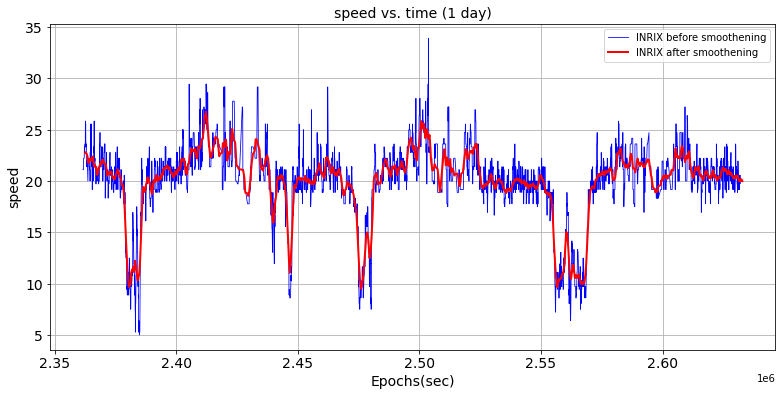

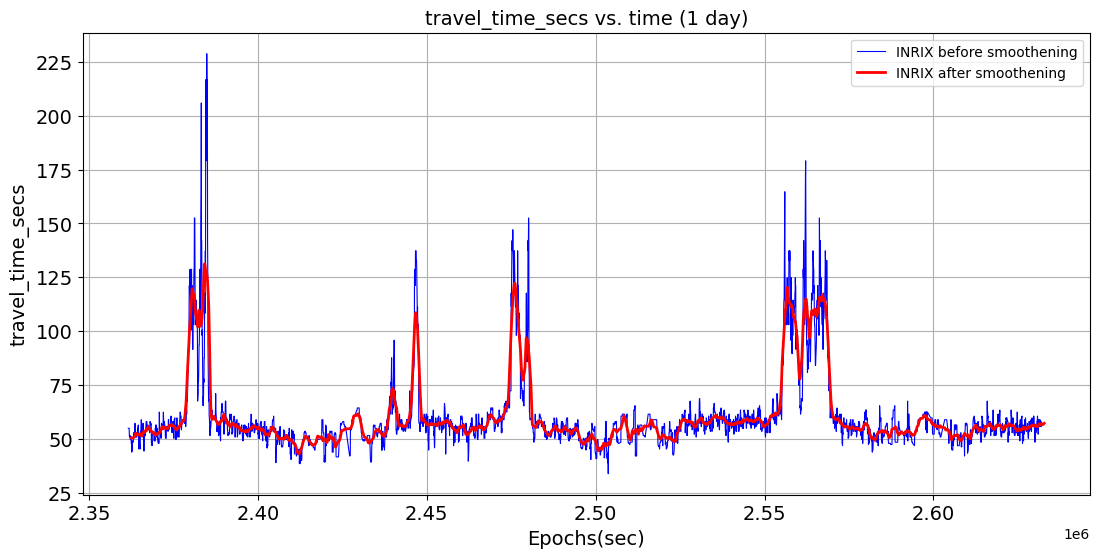

In [ ]:
# Plot original speed and smoothened speed for INRIX
plt.figure(figsize=(13, 6))
plotAttr2DF(1, inrixSouth_removed.iloc[1440*26:1440*29], inrixSouth_MA.iloc[1440*26:1440*29], 
            'Epoch_inrix', 'speed', 'INRIX before smoothening', 'INRIX after smoothening')

# Plot original travel time and smoothened one for INRIX
plt.figure(figsize=(13, 6))
plotAttr2DF(1, inrixSouth_removed.iloc[1440*26:1440*29], inrixSouth_MA.iloc[1440*26:1440*29], 
            'Epoch_inrix', 'travel_time_secs', 'INRIX before smoothening', 'INRIX after smoothening')

### 2.4.2 smoothen the INRIX North

In [ ]:
# observe the first x rows and last x rows of inrix dataset (before smoothening)
inrixNorth_removed

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      225285973 2018-10-01 00:00:14  ... 2018-10-01 02:00:14          0.0
1      225285973 2018-10-01 00:01:12  ... 2018-10-01 02:01:12         58.0
2      225285973 2018-10-01 00:02:10  ... 2018-10-01 02:02:10        116.0
3      225285973 2018-10-01 00:03:11  ... 2018-10-01 02:03:11        177.0
4      225285973 2018-10-01 00:04:11  ... 2018-10-01 02:04:11        237.0
...          ...                 ...  ...                 ...          ...
42412  225285973 2018-10-31 23:55:13  ... 2018-11-01 00:55:13    2678099.0
42413  225285973 2018-10-31 23:56:09  ... 2018-11-01 00:56:09    2678155.0
42414  225285973 2018-10-31 23:57:10  ... 2018-11-01 00:57:09    2678216.0
42415  225285973 2018-10-31 23:58:11  ... 2018-11-01 00:58:10    2678277.0
42416  225285973 2018-10-31 23:59:10  ... 2018-11-01 00:59:10    2678336.0

[42417 rows x 10 columns]

In [ ]:
# smoothen the north speed column by centered moving average
rolling_speed = inrixNorth_removed.speed.rolling(window=MOVING_AVERAGE_WINDOW, center=True)
rolling_mean_speed = rolling_speed.mean()
rolling_mean_speed

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
42412   NaN
42413   NaN
42414   NaN
42415   NaN
42416   NaN
Name: speed, Length: 42417, dtype: float64

In [ ]:
# smoothen the north travel time column by centered moving average
rolling_travelTime = inrixNorth_removed.travel_time_secs.rolling(window=MOVING_AVERAGE_WINDOW, center=True)
rolling_mean_travelTime = rolling_travelTime.mean()
rolling_mean_travelTime

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
42412   NaN
42413   NaN
42414   NaN
42415   NaN
42416   NaN
Name: travel_time_secs, Length: 42417, dtype: float64

In [ ]:
# add the smoothened columns back to the inrixSouth datafram
inrixNorth_MA = inrixNorth_removed.copy()
inrixNorth_MA.speed = rolling_mean_speed
inrixNorth_MA.travel_time_secs = rolling_mean_travelTime
inrixNorth_MA

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      225285973 2018-10-01 00:00:14  ... 2018-10-01 02:00:14          0.0
1      225285973 2018-10-01 00:01:12  ... 2018-10-01 02:01:12         58.0
2      225285973 2018-10-01 00:02:10  ... 2018-10-01 02:02:10        116.0
3      225285973 2018-10-01 00:03:11  ... 2018-10-01 02:03:11        177.0
4      225285973 2018-10-01 00:04:11  ... 2018-10-01 02:04:11        237.0
...          ...                 ...  ...                 ...          ...
42412  225285973 2018-10-31 23:55:13  ... 2018-11-01 00:55:13    2678099.0
42413  225285973 2018-10-31 23:56:09  ... 2018-11-01 00:56:09    2678155.0
42414  225285973 2018-10-31 23:57:10  ... 2018-11-01 00:57:09    2678216.0
42415  225285973 2018-10-31 23:58:11  ... 2018-11-01 00:58:10    2678277.0
42416  225285973 2018-10-31 23:59:10  ... 2018-11-01 00:59:10    2678336.0

[42417 rows x 10 columns]

In [ ]:
# remove the speed, travel time rows with NaN value due to the moving average process
inrixNorth_MA = inrixNorth_MA.dropna()
inrixNorth_MA.reset_index(inplace=True, drop=True)
inrixNorth_MA

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      225285973 2018-10-01 00:15:14  ... 2018-10-01 02:15:14        900.0
1      225285973 2018-10-01 00:16:11  ... 2018-10-01 02:16:11        957.0
2      225285973 2018-10-01 00:17:16  ... 2018-10-01 02:17:16       1022.0
3      225285973 2018-10-01 00:18:10  ... 2018-10-01 02:18:10       1076.0
4      225285973 2018-10-01 00:19:11  ... 2018-10-01 02:19:11       1137.0
...          ...                 ...  ...                 ...          ...
42383  225285973 2018-10-31 23:41:10  ... 2018-11-01 00:41:09    2677256.0
42384  225285973 2018-10-31 23:42:11  ... 2018-11-01 00:42:10    2677317.0
42385  225285973 2018-10-31 23:43:11  ... 2018-11-01 00:43:11    2677377.0
42386  225285973 2018-10-31 23:44:10  ... 2018-11-01 00:44:10    2677436.0
42387  225285973 2018-10-31 23:45:19  ... 2018-11-01 00:45:19    2677505.0

[42388 rows x 10 columns]

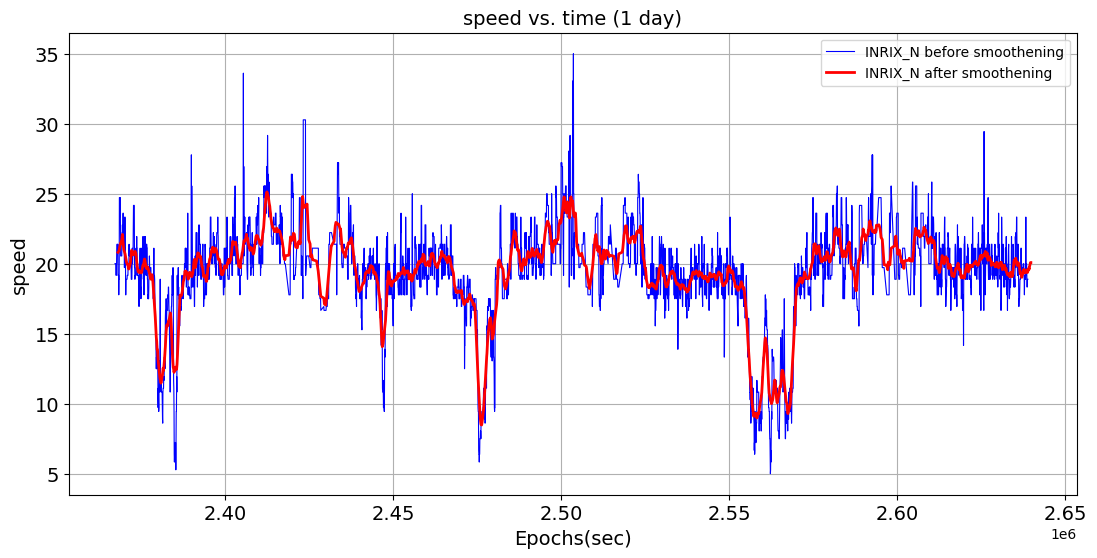

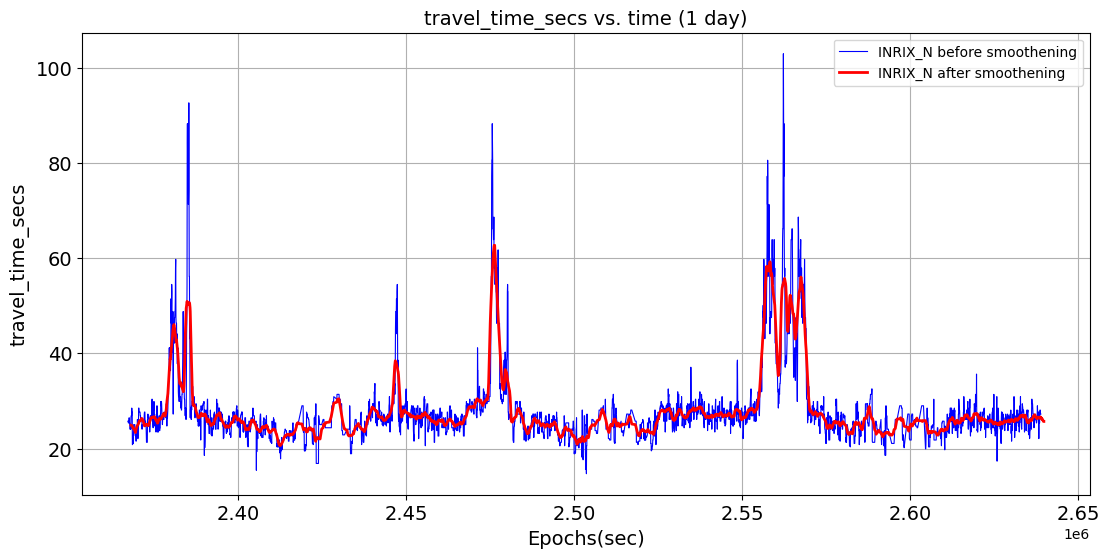

In [ ]:
# Plot original speed and smoothened speed for INRIX North
plt.figure(figsize=(13, 6))
plotAttr2DF(1, inrixNorth_removed.iloc[1440*26:1440*29], inrixNorth_MA.iloc[1440*26:1440*29], 
            'Epoch_inrix', 'speed', 'INRIX_N before smoothening', 'INRIX_N after smoothening')

# Plot original travel time and smoothened one for INRIX North
plt.figure(figsize=(13, 6))
plotAttr2DF(1, inrixNorth_removed.iloc[1440*26:1440*29], inrixNorth_MA.iloc[1440*26:1440*29], 
            'Epoch_inrix', 'travel_time_secs', 'INRIX_N before smoothening', 'INRIX_N after smoothening')

### 2.4.3 compare the inrix south with north after smoothening

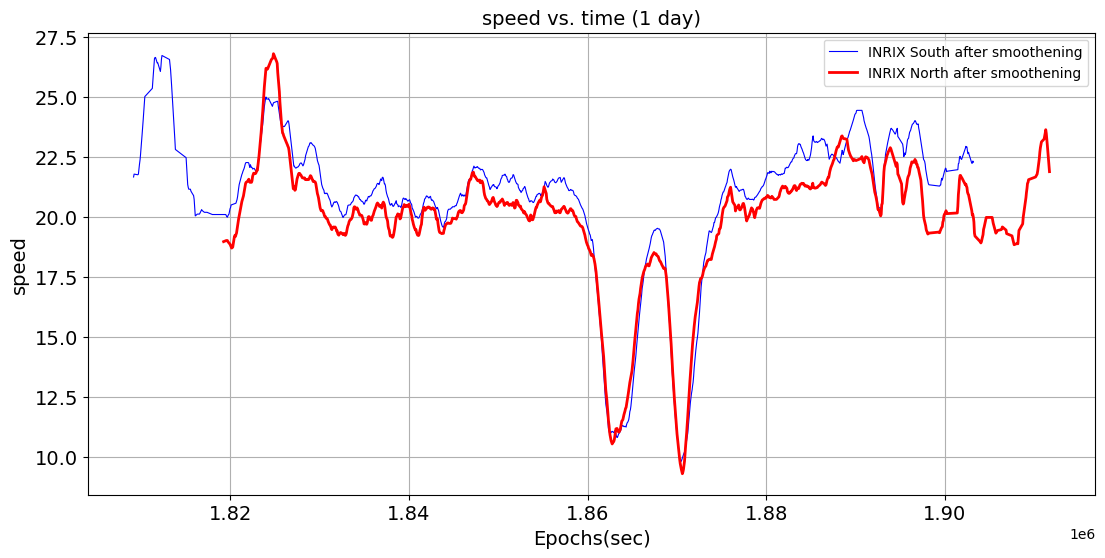

In [ ]:
# Plot smoothened south speed and smoothened north speed
ST = 20
END = 21
plt.figure(figsize=(13, 6))
plotAttr2DF(1, inrixSouth_MA.iloc[1440*ST:1440*END], inrixNorth_MA.iloc[1440*ST:1440*END], 
            'Epoch_inrix', 'speed', 'INRIX South after smoothening', 'INRIX North after smoothening')

# 3. Explore and Pre-process MCS data

# 3.1 Check distribution of speed and flow

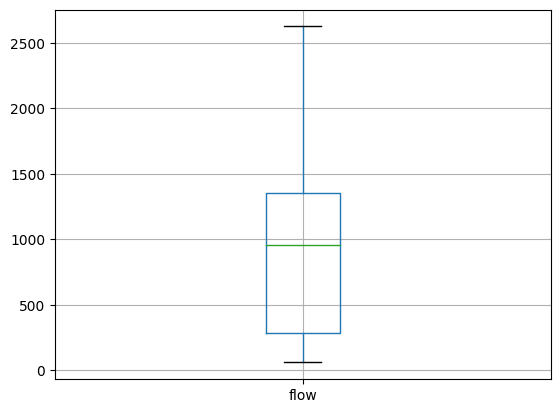

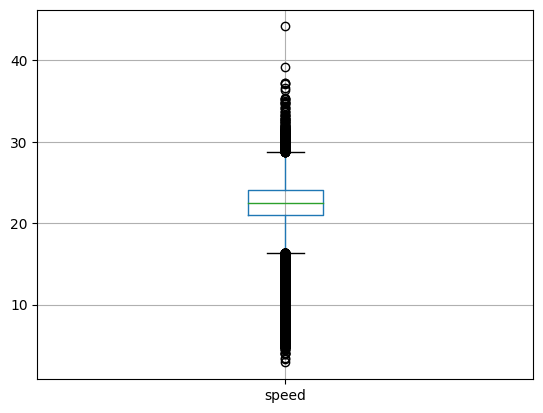

In [ ]:
#check the distribution of MCS speed and flow
# check is there any outlier needs to be filtered
mcsSouth = mcsSouth_raw.copy()

plt.style.use('default')
plt.figure(1)
boxplot1 = mcsSouth.boxplot(column=['flow'])

plt.figure(2)
boxplot2 = mcsSouth.boxplot(column=['speed']) 

## 3.2 Convert to Datetime & Calculate the Epoch

In [ ]:
print(mcsSouth.head(10))
mcsSouth.info()

   fk_id                 date    speed  ...    used_lanes  Epoch_mcs   Density
0   1159  2018-10-01 00:00:00  26.6028  ...     {1,1,1,1}        0.0  0.103373
1   1159  2018-10-01 00:01:00  26.0600  ...  {1,1,1,NULL}       60.0  0.102328
2   1159  2018-10-01 00:02:00  25.0705  ...     {1,1,1,1}      120.0  0.069803
3   1159  2018-10-01 00:03:00  27.2009  ...  {1,1,1,NULL}      180.0  0.134799
4   1159  2018-10-01 00:04:00  24.9600  ...  {1,1,1,NULL}      240.0  0.120192
5   1159  2018-10-01 00:05:00  24.5883  ...     {1,1,1,1}      300.0  0.142344
6   1159  2018-10-01 00:06:00  25.9390  ...     {1,1,1,1}      360.0  0.096380
7   1159  2018-10-01 00:07:00  25.6567  ...  {1,1,1,NULL}      420.0  0.129921
8   1159  2018-10-01 00:08:00  26.5114  ...  {1,1,1,NULL}      480.0  0.163452
9   1159  2018-10-01 00:09:00  23.9637  ...  {1,1,1,NULL}      540.0  0.083460

[10 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44275 entries, 0 to 44274
Data columns (total 8 columns):


In [ ]:
# convert column "date" into Datetime objects, add back into original column "date"
convertToDateD = lambda row: datetime.strptime(row['date'], "%Y-%m-%d %H:%M:%S")
mcsSouth['date'] = mcsSouth.apply(convertToDateD, axis=1)

# check the datatype after convertion
print(mcsSouth.info())
mcsSouth.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44275 entries, 0 to 44274
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fk_id          44275 non-null  int64         
 1   date           44275 non-null  datetime64[ns]
 2   speed          44275 non-null  float64       
 3   speed_std_dev  44275 non-null  float64       
 4   flow           44275 non-null  int64         
 5   used_lanes     44275 non-null  object        
 6   Epoch_mcs      44275 non-null  float64       
 7   Density        44275 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 2.7+ MB
None


fk_id                date    speed  ...    used_lanes  Epoch_mcs   Density
0   1159 2018-10-01 00:00:00  26.6028  ...     {1,1,1,1}        0.0  0.103373
1   1159 2018-10-01 00:01:00  26.0600  ...  {1,1,1,NULL}       60.0  0.102328
2   1159 2018-10-01 00:02:00  25.0705  ...     {1,1,1,1}      120.0  0.069803
3   1159 2018-10-01 00:03:00  27.2009  ...  {1,1,1,NULL}      180.0  0.134799
4   1159 2018-10-01 00:04:00  24.9600  ...  {1,1,1,NULL}      240.0  0.120192
5   1159 2018-10-01 00:05:00  24.5883  ...     {1,1,1,1}      300.0  0.142344
6   1159 2018-10-01 00:06:00  25.9390  ...     {1,1,1,1}      360.0  0.096380
7   1159 2018-10-01 00:07:00  25.6567  ...  {1,1,1,NULL}      420.0  0.129921
8   1159 2018-10-01 00:08:00  26.5114  ...  {1,1,1,NULL}      480.0  0.163452
9   1159 2018-10-01 00:09:00  23.9637  ...  {1,1,1,NULL}      540.0  0.083460

[10 rows x 8 columns]

In [ ]:
# calculate the Epoch according to the date
mcsSouth['Epoch_test'] = 0.0

for i in range(len(mcsSouth)):
  mcsSouth.at[i, 'Epoch_test'] = calEpoch(mcsSouth, 'date', i)

mcsSouth.iloc[idx(mcsSouth,28)+140:idx(mcsSouth, 28) + 150]

fk_id                date    speed  ...  Epoch_mcs   Density Epoch_test
38718   1159 2018-10-28 02:20:00  27.0953  ...  2341200.0  0.147627  2341200.0
38719   1159 2018-10-28 02:21:00  25.3771  ...  2341260.0  0.197028  2341260.0
38720   1159 2018-10-28 02:22:00  26.7140  ...  2341320.0  0.159093  2341320.0
38721   1159 2018-10-28 02:23:00  25.6813  ...  2341380.0  0.165490  2341380.0
38722   1159 2018-10-28 02:24:00  25.5556  ...  2341440.0  0.156521  2341440.0
38723   1159 2018-10-28 02:25:00  25.7075  ...  2341500.0  0.207462  2341500.0
38724   1159 2018-10-28 02:26:00  25.9797  ...  2345160.0  0.128305  2341560.0
38725   1159 2018-10-28 02:27:00  25.4681  ...  2345220.0  0.137427  2341620.0
38726   1159 2018-10-28 02:28:00  24.9351  ...  2345280.0  0.140364  2341680.0
38727   1159 2018-10-28 02:29:00  26.4942  ...  2345340.0  0.103796  2341740.0

[10 rows x 9 columns]

In [ ]:
# assign the new epoch to 'Epoch_mcs', drop the test epoch column
mcsSouth.Epoch_mcs = mcsSouth.Epoch_test
mcsSouth.drop(columns='Epoch_test', inplace=True)
mcsSouth

fk_id                date    speed  ...    used_lanes  Epoch_mcs   Density
0       1159 2018-10-01 00:00:00  26.6028  ...     {1,1,1,1}        0.0  0.103373
1       1159 2018-10-01 00:01:00  26.0600  ...  {1,1,1,NULL}       60.0  0.102328
2       1159 2018-10-01 00:02:00  25.0705  ...     {1,1,1,1}      120.0  0.069803
3       1159 2018-10-01 00:03:00  27.2009  ...  {1,1,1,NULL}      180.0  0.134799
4       1159 2018-10-01 00:04:00  24.9600  ...  {1,1,1,NULL}      240.0  0.120192
...      ...                 ...      ...  ...           ...        ...       ...
44270   1159 2018-10-31 23:40:00  23.0849  ...     {1,1,1,1}  2677200.0  0.140785
44271   1159 2018-10-31 23:41:00  23.8088  ...     {1,1,1,1}  2677260.0  0.220507
44272   1159 2018-10-31 23:42:00  22.5673  ...     {1,1,1,1}  2677320.0  0.265871
44273   1159 2018-10-31 23:43:00  24.9865  ...     {1,1,1,1}  2677380.0  0.190103
44274   1159 2018-10-31 23:44:00  23.0582  ...     {1,1,1,1}  2677440.0  0.140948

[44275 rows x 8 columns]

## 3.3 Smoothen MCS Speed and Flow

In [ ]:
# smoothen the speed column by centered moving average
rolling_speed = mcsSouth.speed.rolling(window=MOVING_AVERAGE_WINDOW, center=True)
rolling_mean_speed = rolling_speed.mean()
rolling_mean_speed

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
44270   NaN
44271   NaN
44272   NaN
44273   NaN
44274   NaN
Name: speed, Length: 44275, dtype: float64

In [ ]:
# smoothen the flow column by centered moving average
rolling_flow = mcsSouth.flow.rolling(window=MOVING_AVERAGE_WINDOW, center=True)
rolling_mean_flow = rolling_flow.mean()
rolling_mean_flow

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
44270   NaN
44271   NaN
44272   NaN
44273   NaN
44274   NaN
Name: flow, Length: 44275, dtype: float64

In [ ]:
# add the smoothened columns back to the datafram
mcsSouth_MA = mcsSouth.copy()
mcsSouth_MA.speed = rolling_mean_speed
mcsSouth_MA.flow = rolling_mean_flow
mcsSouth_MA

fk_id                date  speed  ...    used_lanes  Epoch_mcs   Density
0       1159 2018-10-01 00:00:00    NaN  ...     {1,1,1,1}        0.0  0.103373
1       1159 2018-10-01 00:01:00    NaN  ...  {1,1,1,NULL}       60.0  0.102328
2       1159 2018-10-01 00:02:00    NaN  ...     {1,1,1,1}      120.0  0.069803
3       1159 2018-10-01 00:03:00    NaN  ...  {1,1,1,NULL}      180.0  0.134799
4       1159 2018-10-01 00:04:00    NaN  ...  {1,1,1,NULL}      240.0  0.120192
...      ...                 ...    ...  ...           ...        ...       ...
44270   1159 2018-10-31 23:40:00    NaN  ...     {1,1,1,1}  2677200.0  0.140785
44271   1159 2018-10-31 23:41:00    NaN  ...     {1,1,1,1}  2677260.0  0.220507
44272   1159 2018-10-31 23:42:00    NaN  ...     {1,1,1,1}  2677320.0  0.265871
44273   1159 2018-10-31 23:43:00    NaN  ...     {1,1,1,1}  2677380.0  0.190103
44274   1159 2018-10-31 23:44:00    NaN  ...     {1,1,1,1}  2677440.0  0.140948

[44275 rows x 8 columns]

In [ ]:
# remove the rows with NaN value due to the moving average process
mcsSouth_MA = mcsSouth_MA.dropna()
mcsSouth_MA.reset_index(inplace=True, drop=True)
mcsSouth_MA

fk_id                date  ...  Epoch_mcs   Density
0       1159 2018-10-01 00:15:00  ...      900.0  0.065712
1       1159 2018-10-01 00:16:00  ...      960.0  0.137527
2       1159 2018-10-01 00:17:00  ...     1020.0  0.076174
3       1159 2018-10-01 00:18:00  ...     1080.0  0.189890
4       1159 2018-10-01 00:19:00  ...     1140.0  0.060373
...      ...                 ...  ...        ...       ...
44241   1159 2018-10-31 23:26:00  ...  2676360.0  0.141372
44242   1159 2018-10-31 23:27:00  ...  2676420.0  0.165950
44243   1159 2018-10-31 23:28:00  ...  2676480.0  0.201262
44244   1159 2018-10-31 23:29:00  ...  2676540.0  0.181899
44245   1159 2018-10-31 23:30:00  ...  2676600.0  0.114146

[44246 rows x 8 columns]

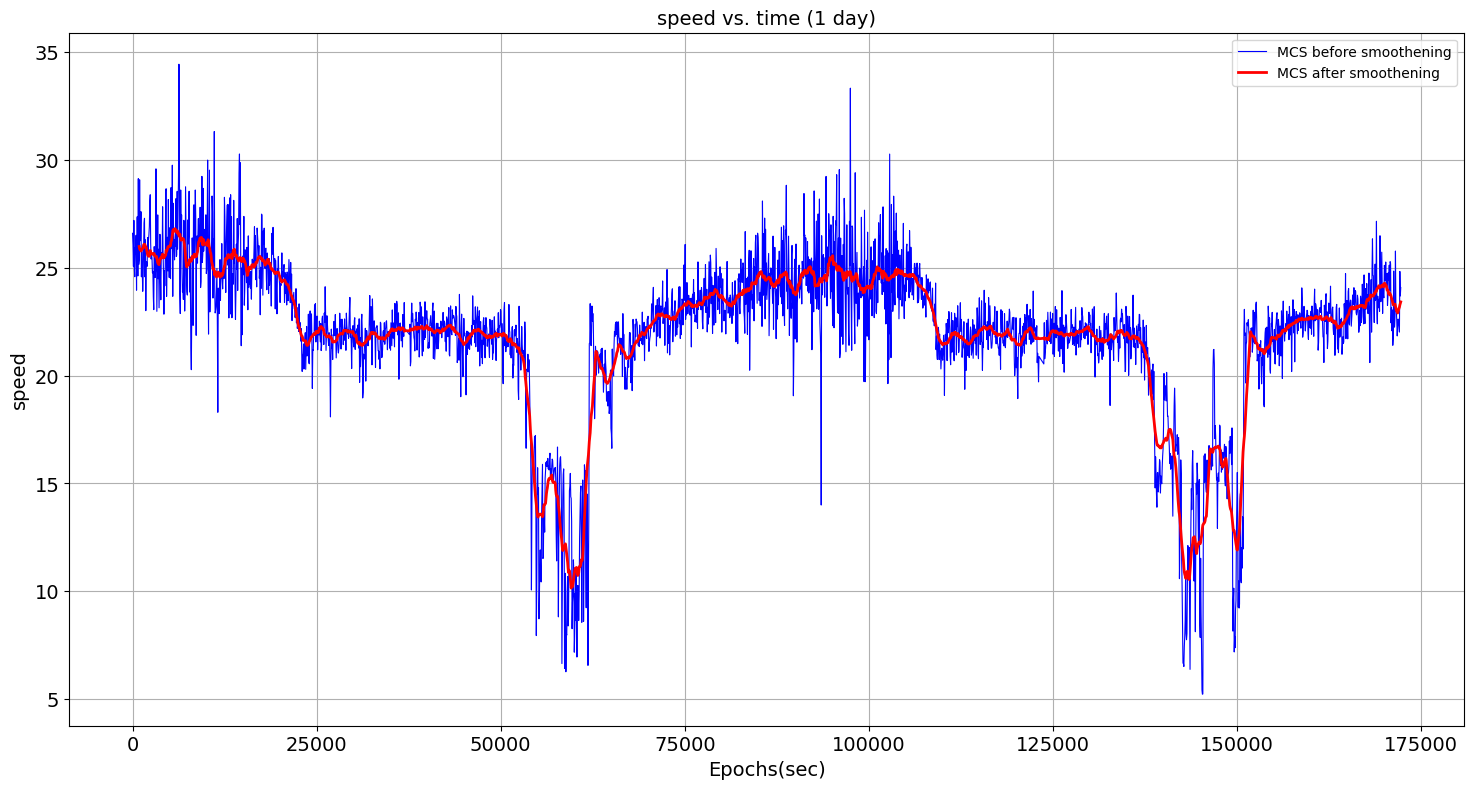

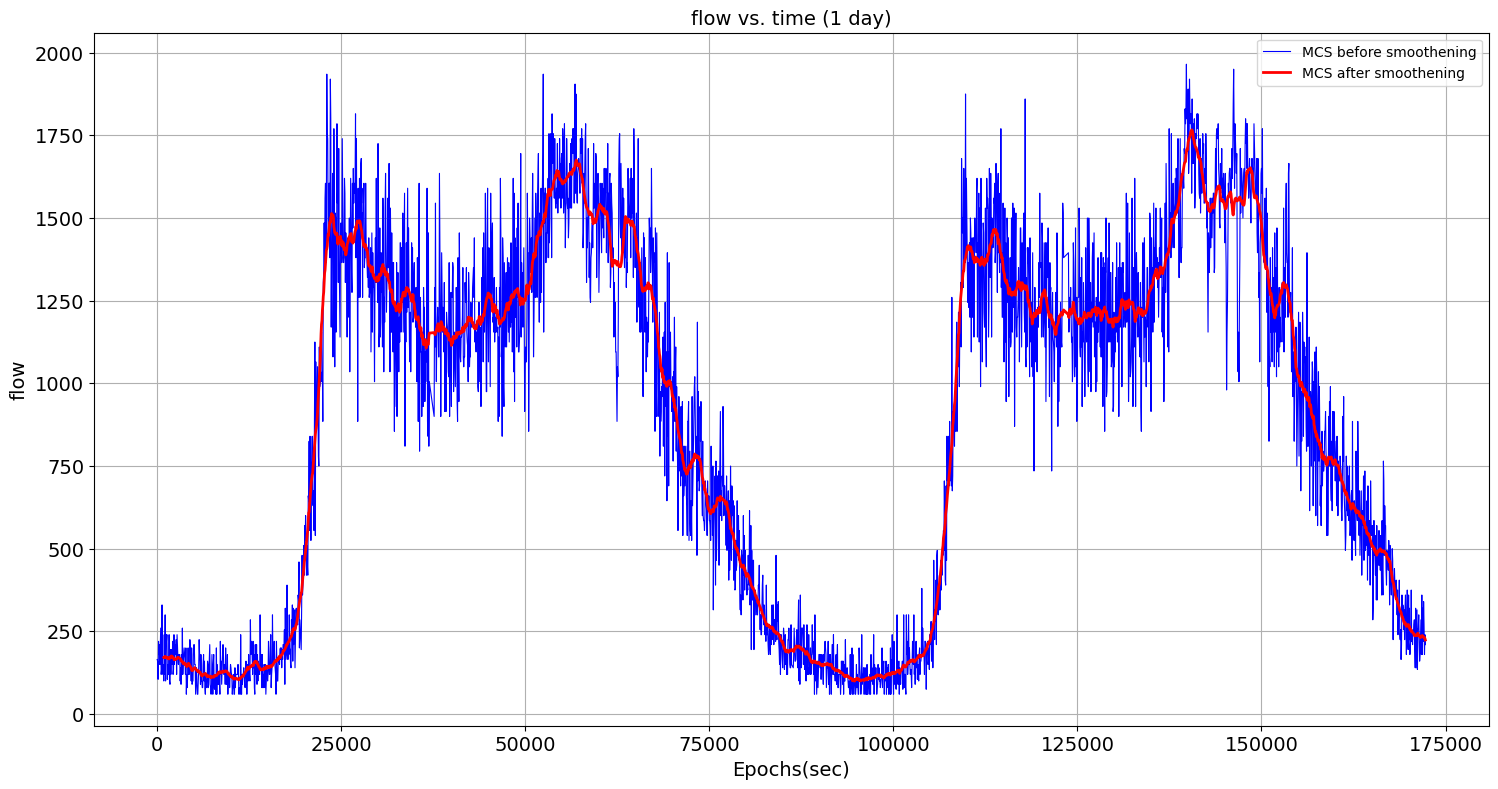

In [ ]:
# Plot original speed and smoothened speed for MCS
plt.figure(figsize=(18, 9))
plotAttr2DF(1, mcsSouth.iloc[:idx(mcsSouth, 3)], mcsSouth_MA.iloc[:idx(mcsSouth_MA, 3)], 
            'Epoch_mcs', 'speed', 'MCS before smoothening', 'MCS after smoothening')

# Plot original flow and smoothened flow for MCS
plt.figure(figsize=(18, 9))
plotAttr2DF(1, mcsSouth.iloc[:idx(mcsSouth, 3)], mcsSouth_MA.iloc[:idx(mcsSouth_MA, 3)], 
            'Epoch_mcs', 'flow', 'MCS before smoothening', 'MCS after smoothening')

# 4. Pre-process(Combine) both MCS and INRIX South/North dataframes

*  Match the corresponding timesteps between MCS and INRIX

## 4.1 Shift the time-lag of INRIX South

In [ ]:
# Shift Epoch_inrix of INRIX south by adding 114 mins in order to eliminate the time-gap  
inrixSouth_shifted = inrixSouth_MA
print(inrixSouth_shifted)
inrixSouth_shifted['Epoch_inrix'] = inrixSouth_shifted.Epoch_inrix + (114 * 60)
print(inrixSouth_shifted)

        segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      1071883675 2018-10-01 00:15:11  ... 2018-10-01 02:15:11        899.0
1      1071883675 2018-10-01 00:16:09  ... 2018-10-01 02:16:09        957.0
2      1071883675 2018-10-01 00:17:14  ... 2018-10-01 02:17:14       1022.0
3      1071883675 2018-10-01 00:18:08  ... 2018-10-01 02:18:08       1076.0
4      1071883675 2018-10-01 00:19:09  ... 2018-10-01 02:19:09       1137.0
...           ...                 ...  ...                 ...          ...
42498  1071883675 2018-10-31 23:41:08  ... 2018-11-01 00:41:08    2677256.0
42499  1071883675 2018-10-31 23:42:09  ... 2018-11-01 00:42:09    2677317.0
42500  1071883675 2018-10-31 23:43:08  ... 2018-11-01 00:43:08    2677376.0
42501  1071883675 2018-10-31 23:44:09  ... 2018-11-01 00:44:08    2677437.0
42502  1071883675 2018-10-31 23:45:15  ... 2018-11-01 00:45:15    2677503.0

[42503 rows x 10 columns]
        segmentid        timestamputc  ...          date_inri

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Shift Epoch_inrix of INRIX north by adding 114 mins in order to eliminate the time-gap  
inrixNorth_shifted = inrixNorth_MA
print(inrixNorth_shifted)
inrixNorth_shifted['Epoch_inrix'] = inrixNorth_shifted.Epoch_inrix + (114 * 60)
print(inrixNorth_shifted)

       segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      225285973 2018-10-01 00:15:14  ... 2018-10-01 02:15:14        900.0
1      225285973 2018-10-01 00:16:11  ... 2018-10-01 02:16:11        957.0
2      225285973 2018-10-01 00:17:16  ... 2018-10-01 02:17:16       1022.0
3      225285973 2018-10-01 00:18:10  ... 2018-10-01 02:18:10       1076.0
4      225285973 2018-10-01 00:19:11  ... 2018-10-01 02:19:11       1137.0
...          ...                 ...  ...                 ...          ...
42383  225285973 2018-10-31 23:41:10  ... 2018-11-01 00:41:09    2677256.0
42384  225285973 2018-10-31 23:42:11  ... 2018-11-01 00:42:10    2677317.0
42385  225285973 2018-10-31 23:43:11  ... 2018-11-01 00:43:11    2677377.0
42386  225285973 2018-10-31 23:44:10  ... 2018-11-01 00:44:10    2677436.0
42387  225285973 2018-10-31 23:45:19  ... 2018-11-01 00:45:19    2677505.0

[42388 rows x 10 columns]
       segmentid        timestamputc  ...          date_inrix  Epoch_inri

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## 4.2 Match the MCS and INRIX south data rows in the same timesteps




In [ ]:
# function to match inrix timesteps to mcs, and merge them
# Input: mcs dataframe, inrix dataframe
# output: return a new dataframe combines both dataframes after the time-step matching
def matchTimeStep (mcsDf, inrixDf):
  DELTATIME = 26.0
  mcsMatched = pd.DataFrame(columns = mcsDf.columns)
  inrixMatched = pd.DataFrame(columns = inrixDf.columns)
  print(mcsMatched)
  print(inrixMatched)
  i = 0
  j = 0
  while ((j < len(inrixDf)) & (i < len(mcsDf))):
    mcsEpoch = mcsDf.iloc[i]['Epoch_mcs']
    inrixEpoch = inrixDf.iloc[j]['Epoch_inrix']
    # if the difference in epoch between mcs and inrix is smaller than 25 sec,
    # they are in the same time step (within same min interval)
    if (abs(inrixEpoch - mcsEpoch) < DELTATIME ):
      mcsMatched = mcsMatched.append(mcsDf.iloc[i], ignore_index = True)
      inrixMatched = inrixMatched.append(inrixDf.iloc[j], ignore_index = True)
      i += 1
      j += 1
      if(i % 1000.0 == 0): print(mcsMatched)
    elif ((inrixEpoch - mcsEpoch) < 0.0):
      j += 1
      print('missing mcs', j)
    elif ((inrixEpoch -mcsEpoch) > 0.0):
      i +=1
      print('missing inrix', i)
  
  print('length of mcsMatched: ', len(mcsMatched))
  print('length of inrixMatched: ', len(inrixMatched))

  print(inrixMatched.columns)
  inrixMatched.rename(columns = {'speed': 'speed_inrix'}, inplace = True)
  print(inrixMatched.columns)
  
  combinedDf = pd.concat([mcsMatched, inrixMatched], axis=1)
  print('length of combined df:', len(combinedDf))
  
  return combinedDf
  

In [ ]:
# match the shifted inrix with mcs dataframe and combined them
# Notice: a lot of log will be printed out for progress monitoring 
combinedSouth_shifted = matchTimeStep(mcsSouth_MA, inrixSouth_shifted)

Empty DataFrame
Columns: [fk_id, date, speed, speed_std_dev, flow, used_lanes, Epoch_mcs, Density]
Index: []
Empty DataFrame
Columns: [segmentid, timestamputc, speed, average, reference, score, cvalue, travel_time_secs, date_inrix, Epoch_inrix]
Index: []
missing inrix 1
missing inrix 2
missing inrix 3
missing inrix 4
missing inrix 5
missing inrix 6
missing inrix 7
missing inrix 8
missing inrix 9
missing inrix 10
missing inrix 11
missing inrix 12
missing inrix 13
missing inrix 14
missing inrix 15
missing inrix 16
missing inrix 17
missing inrix 18
missing inrix 19
missing inrix 20
missing inrix 21
missing inrix 22
missing inrix 23
missing inrix 24
missing inrix 25
missing inrix 26
missing inrix 27
missing inrix 28
missing inrix 29
missing inrix 30
missing inrix 31
missing inrix 32
missing inrix 33
missing inrix 34
missing inrix 35
missing inrix 36
missing inrix 37
missing inrix 38
missing inrix 39
missing inrix 40
missing inrix 41
missing inrix 42
missing inrix 43
missing inrix 44
missin

In [ ]:
combinedSouth_shifted[['date', 'speed', 'Epoch_mcs', 'timestamputc', 'speed_inrix', 'Epoch_inrix']]

date      speed  ...  speed_inrix Epoch_inrix
0     2018-10-01 02:09:00  25.379647  ...    21.490741      7739.0
1     2018-10-01 02:10:00  25.301860  ...    21.268519      7797.0
2     2018-10-01 02:11:00  25.398467  ...    21.046296      7862.0
3     2018-10-01 02:12:00  25.374270  ...    20.787037      7916.0
4     2018-10-01 02:13:00  25.312143  ...    20.527778      7977.0
...                   ...        ...  ...          ...         ...
42044 2018-10-31 23:26:00  23.840493  ...    20.953704   2676357.0
42045 2018-10-31 23:27:00  23.891030  ...    20.944444   2676416.0
42046 2018-10-31 23:28:00  23.861783  ...    21.046296   2676478.0
42047 2018-10-31 23:29:00  23.885273  ...    21.092593   2676537.0
42048 2018-10-31 23:30:00  23.819667  ...    21.111111   2676597.0

[42049 rows x 6 columns]

In [ ]:
# Check the datatype after combining, cast the datatypes to the original types
print(combinedSouth_shifted.info())
print(mcsSouth_MA.info())
print(inrixSouth_shifted.info())
combinedSouth_shifted = combinedSouth_shifted.astype({'fk_id':'int64', 'flow':'int64', 
                                                      'segmentid':'int64', 'Epoch_inrix':'int64', 
                                                      'score': 'int64', 'cvalue': 'int64'})
combinedSouth_shifted.info()
combinedSouth_shifted.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42049 entries, 0 to 42048
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fk_id             42049 non-null  object        
 1   date              42049 non-null  datetime64[ns]
 2   speed             42049 non-null  float64       
 3   speed_std_dev     42049 non-null  float64       
 4   flow              42049 non-null  float64       
 5   used_lanes        42049 non-null  object        
 6   Epoch_mcs         42049 non-null  float64       
 7   Density           42049 non-null  float64       
 8   segmentid         42049 non-null  object        
 9   timestamputc      42049 non-null  datetime64[ns]
 10  speed_inrix       42049 non-null  float64       
 11  average           42049 non-null  float64       
 12  reference         42049 non-null  float64       
 13  score             42049 non-null  object        
 14  cvalue            4204

fk_id                date  ...          date_inrix  Epoch_inrix
0   1159 2018-10-01 02:09:00  ... 2018-10-01 02:15:11         7739
1   1159 2018-10-01 02:10:00  ... 2018-10-01 02:16:09         7797
2   1159 2018-10-01 02:11:00  ... 2018-10-01 02:17:14         7862

[3 rows x 18 columns]

# 4.2.2 Match the MCS/INRIX_South and INRIX North data rows in the same timesteps

In [ ]:
# function to match inrix timesteps to mcs, and merge them
# Input: mcs dataframe, inrix dataframe
# output: return a new dataframe combines both dataframes after the time-step matching
def matchTimeStepNeighbor (mcsDf, inrixDf):
  DELTATIME = 26.0
  mcsMatched = pd.DataFrame(columns = mcsDf.columns)
  inrixMatched = pd.DataFrame(columns = inrixDf.columns)
  print(mcsMatched)
  print(inrixMatched)
  i = 0
  j = 0
  while ((j < len(inrixDf)) & (i < len(mcsDf))):
    mcsEpoch = mcsDf.iloc[i]['Epoch_mcs']
    inrixEpoch = inrixDf.iloc[j]['Epoch_inrix_up'] # change the epoch name to up/downstream
    # if the difference in epoch between mcs and inrix is smaller than 25 sec,
    # they are in the same time step (within same min interval)
    if (abs(inrixEpoch - mcsEpoch) < DELTATIME ):
      mcsMatched = mcsMatched.append(mcsDf.iloc[i], ignore_index = True)
      inrixMatched = inrixMatched.append(inrixDf.iloc[j], ignore_index = True)
      i += 1
      j += 1
      if(i % 1000.0 == 0): print(mcsMatched)
    elif ((inrixEpoch - mcsEpoch) < 0.0):
      j += 1
      print('missing mcs', j)
    elif ((inrixEpoch - mcsEpoch) > 0.0):
      i +=1
      print('missing inrix', i)
  
  print('length of mcsMatched: ', len(mcsMatched))
  print('length of inrixMatched: ', len(inrixMatched))

  print(inrixMatched.columns)
  
  combinedDf = pd.concat([mcsMatched, inrixMatched], axis=1)
  print('length of combined dataframe:', len(combinedDf))
  
  return combinedDf

In [ ]:
inrixNorth_shifted.head(1)

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0  225285973 2018-10-01 00:15:14  ... 2018-10-01 02:15:14       7740.0

[1 rows x 10 columns]

In [ ]:
inrixNorth_features = inrixNorth_shifted[['speed', 'travel_time_secs', 'Epoch_inrix']]
inrixNorth_features.rename(columns = {'speed': 'speed_inrix_up','travel_time_secs':'travel_time_secs_up', 'Epoch_inrix':'Epoch_inrix_up'}, inplace = True)
inrixNorth_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42388 entries, 0 to 42387
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   speed_inrix_up       42388 non-null  float64
 1   travel_time_secs_up  42388 non-null  float64
 2   Epoch_inrix_up       42388 non-null  float64
dtypes: float64(3)
memory usage: 993.6 KB


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# match the shifted inrix with mcs dataframe and combined them
# Notice: a lot of log will be printed out for progress monitoring 
combinedSouth_shifted = matchTimeStepNeighbor(combinedSouth_shifted, inrixNorth_features)

Empty DataFrame
Columns: [fk_id, date, speed, speed_std_dev, flow, used_lanes, Epoch_mcs, Density, segmentid, timestamputc, speed_inrix, average, reference, score, cvalue, travel_time_secs, date_inrix, Epoch_inrix]
Index: []
Empty DataFrame
Columns: [speed_inrix_up, travel_time_secs_up, Epoch_inrix_up]
Index: []
missing mcs 50
missing inrix 93
missing inrix 108
missing inrix 109
missing mcs 108
missing mcs 445
missing mcs 446
missing mcs 447
missing mcs 448
missing mcs 449
missing mcs 450
missing mcs 451
missing mcs 452
missing mcs 453
missing mcs 454
    fk_id                date  ...          date_inrix  Epoch_inrix
0    1159 2018-10-01 02:09:00  ... 2018-10-01 02:15:11         7739
1    1159 2018-10-01 02:10:00  ... 2018-10-01 02:16:09         7797
2    1159 2018-10-01 02:11:00  ... 2018-10-01 02:17:14         7862
3    1159 2018-10-01 02:12:00  ... 2018-10-01 02:18:08         7916
4    1159 2018-10-01 02:13:00  ... 2018-10-01 02:19:09         7977
..    ...                 ...  ...

In [ ]:
combinedSouth_shifted[['date', 'speed', 'Epoch_mcs', 'timestamputc', 'speed_inrix', 'Epoch_inrix','speed_inrix_up', 'travel_time_secs_up', 'Epoch_inrix_up']]

date      speed  ...  travel_time_secs_up Epoch_inrix_up
0     2018-10-01 02:09:00  25.379647  ...               26.130         7740.0
1     2018-10-01 02:10:00  25.301860  ...               26.362         7797.0
2     2018-10-01 02:11:00  25.398467  ...               26.594         7862.0
3     2018-10-01 02:12:00  25.374270  ...               26.826         7916.0
4     2018-10-01 02:13:00  25.312143  ...               27.058         7977.0
...                   ...        ...  ...                  ...            ...
41762 2018-10-31 23:26:00  23.840493  ...               23.354      2676356.0
41763 2018-10-31 23:27:00  23.891030  ...               23.270      2676416.0
41764 2018-10-31 23:28:00  23.861783  ...               23.118      2676477.0
41765 2018-10-31 23:29:00  23.885273  ...               23.042      2676537.0
41766 2018-10-31 23:30:00  23.819667  ...               23.090      2676596.0

[41767 rows x 9 columns]

In [ ]:
# Check the datatype after combining, cast the datatypes to the original types
print(combinedSouth_shifted.info())
print(mcsSouth_MA.info())
print(inrixNorth_features.info())
combinedSouth_shifted = combinedSouth_shifted.astype({'fk_id':'int64', 'flow':'int64', 
                                                      'segmentid':'int64','score': 'int64',
                                                      'cvalue': 'int64', 'Epoch_inrix':'float64'})
combinedSouth_shifted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41767 entries, 0 to 41766
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   fk_id                41767 non-null  object        
 1   date                 41767 non-null  datetime64[ns]
 2   speed                41767 non-null  float64       
 3   speed_std_dev        41767 non-null  float64       
 4   flow                 41767 non-null  object        
 5   used_lanes           41767 non-null  object        
 6   Epoch_mcs            41767 non-null  float64       
 7   Density              41767 non-null  float64       
 8   segmentid            41767 non-null  object        
 9   timestamputc         41767 non-null  datetime64[ns]
 10  speed_inrix          41767 non-null  float64       
 11  average              41767 non-null  float64       
 12  reference            41767 non-null  float64       
 13  score                41767 non-

In [ ]:
# save the processed dataframe into the directory
combinedSouth_shifted.to_pickle('OutData/inrixMcsSouth.pkl')

## 4.3 Data exploration after smoothening, data-steps shifting and matching

<strong>No additional operation on dataframes, only exploration.<strong>
  


In [ ]:
# load the combined/processed dataframe
# start from this cell if data frame has been processed before
combinedSouth_shifted = pd.read_pickle('OutData/inrixMcsSouth.pkl')

In [ ]:
combinedSouth_shifted.describe()

fk_id         speed  ...  travel_time_secs_up  Epoch_inrix_up
count  41767.0  41767.000000  ...         41767.000000    4.176700e+04
mean    1159.0     21.790229  ...            27.530681    1.341335e+06
std        0.0      3.371514  ...             9.878668    7.704343e+05
min     1159.0      5.872609  ...            18.964000    7.740000e+03
25%     1159.0     21.156195  ...            24.022000    6.716675e+05
50%     1159.0     22.109510  ...            25.250000    1.340458e+06
75%     1159.0     24.247043  ...            26.598000    2.011226e+06
max     1159.0     27.323600  ...           231.546000    2.676596e+06

[8 rows x 17 columns]

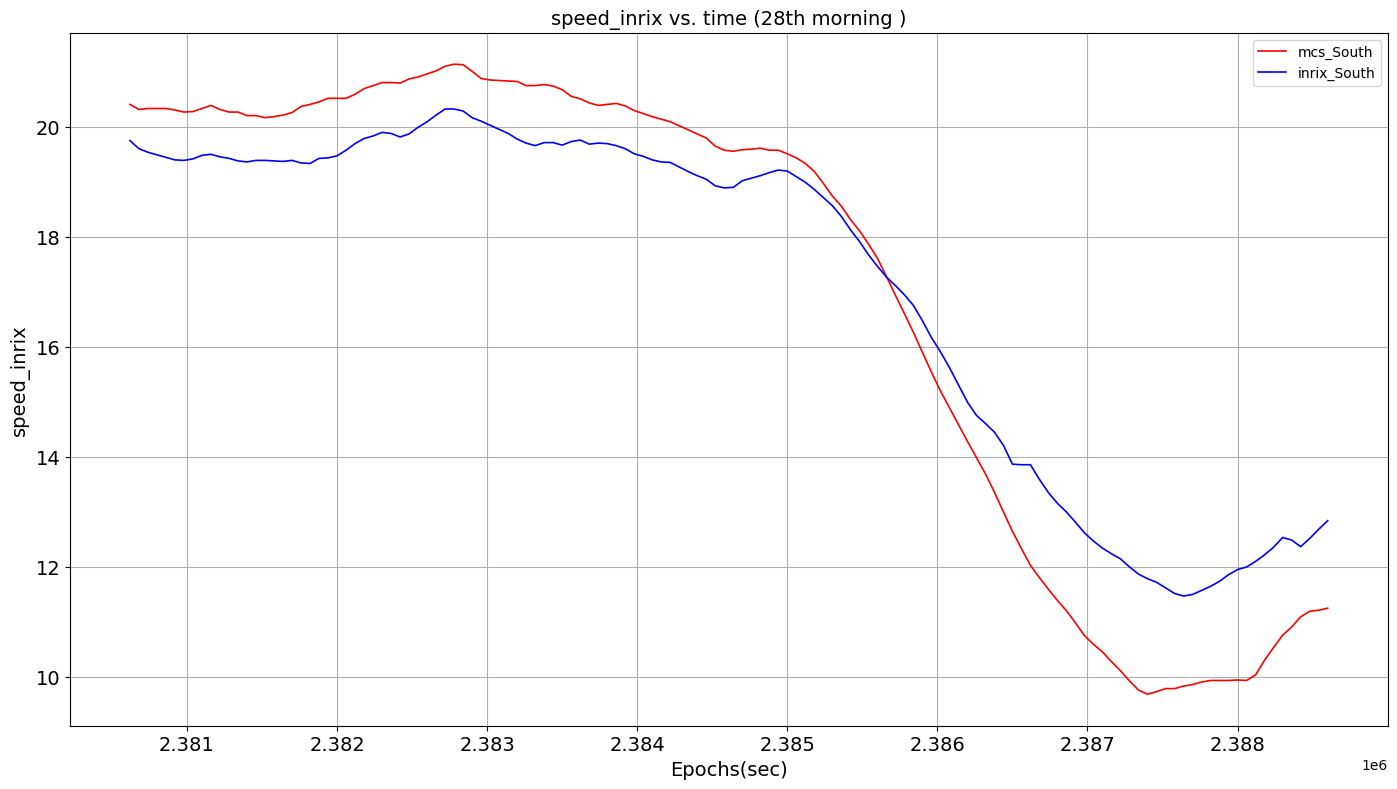

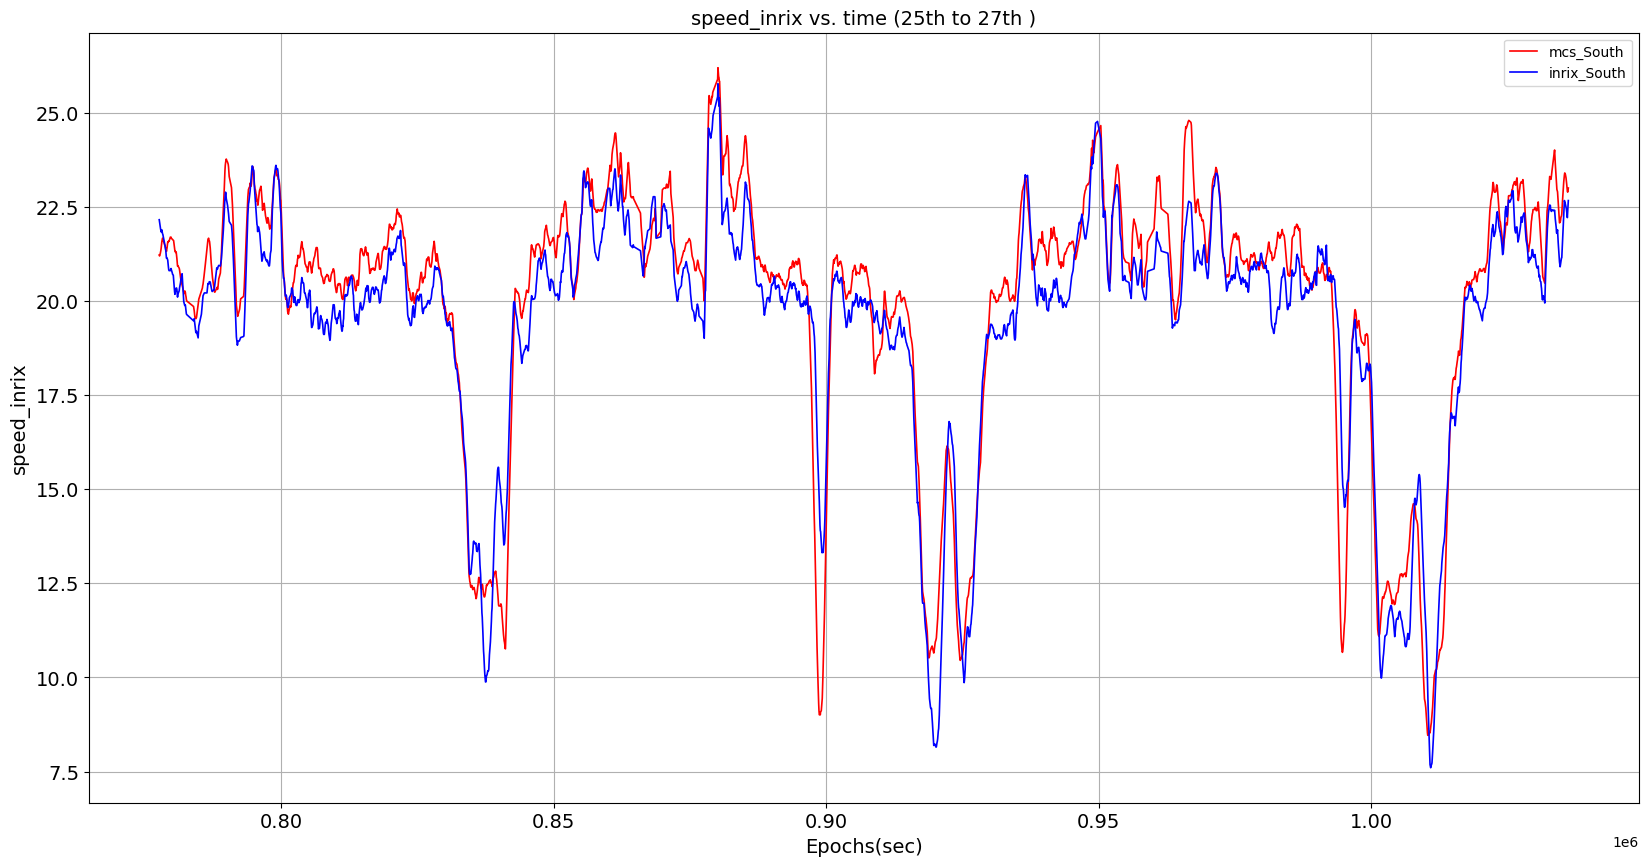

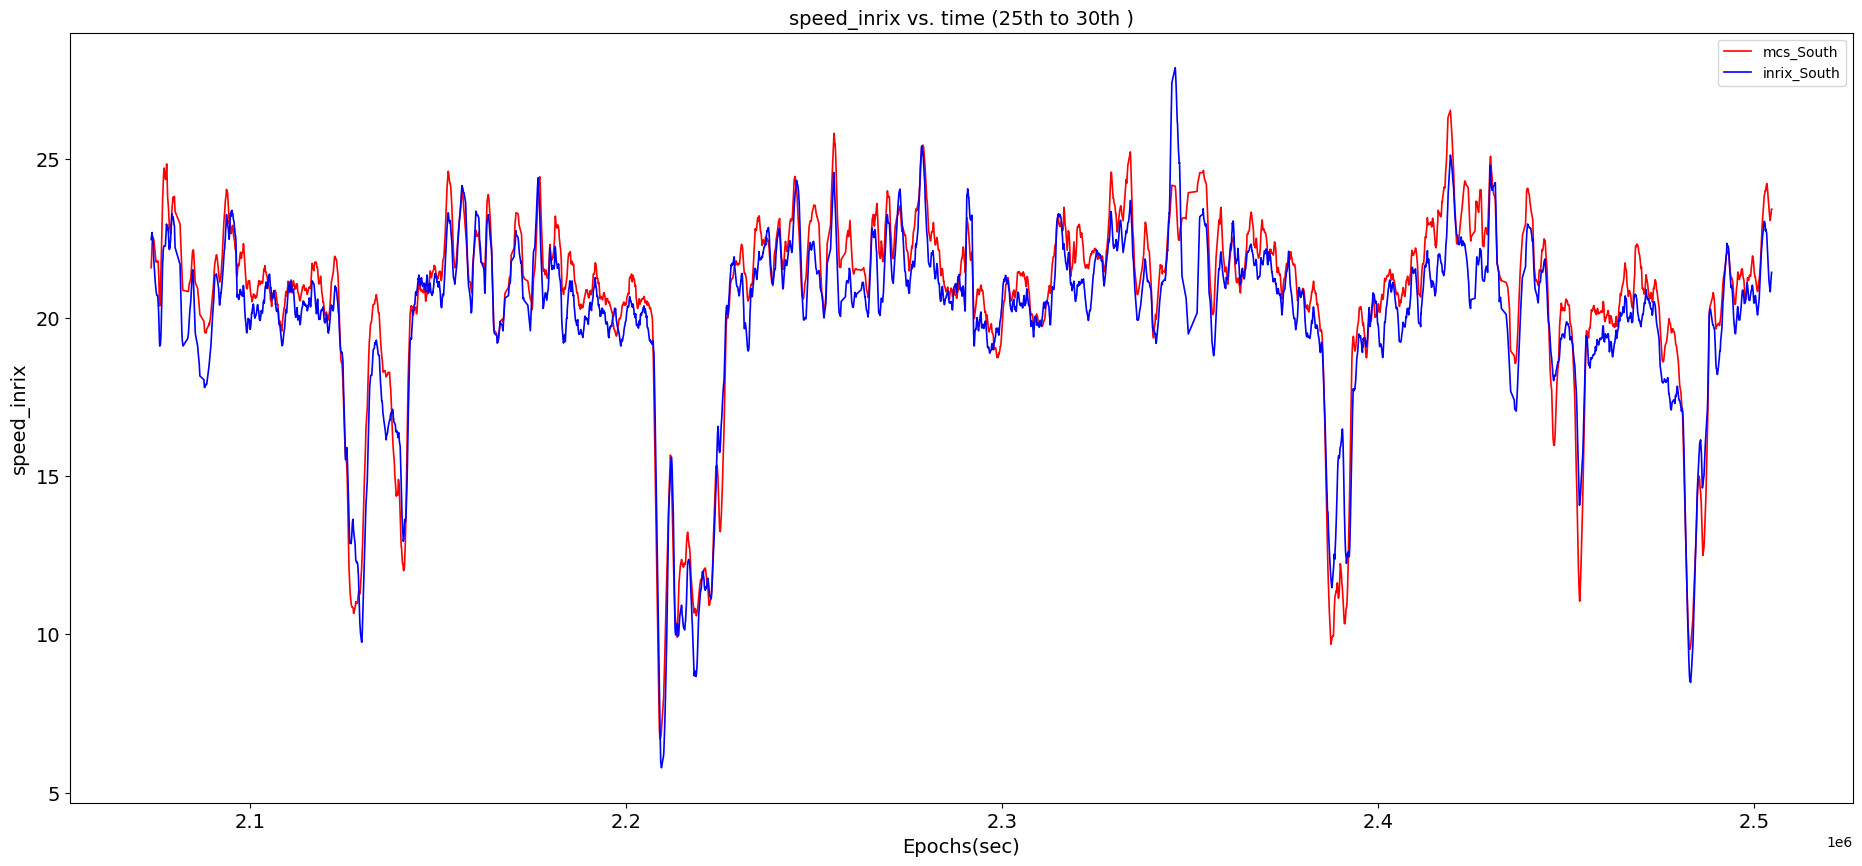

In [ ]:
combinedSouthT_shifted = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 28) + 700: idx(combinedSouth_shifted, 29) - 500] 
plt.figure(figsize=(17, 9))
plt.grid()
plot2Attr('28th morning', combinedSouthT_shifted, 'speed_inrix', 'speed_inrix_up', 'South')

plt.figure(figsize=(20, 10))
combinedSouthT2_shifted = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 10) :idx(combinedSouth_shifted, 13)]
plt.grid()
plot2Attr('25th to 27th', combinedSouthT2_shifted, 'speed_inrix', 'speed_inrix_up', 'South')

plt.figure(figsize=(23, 10))
combinedSouthT3_shifted = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 25) :idx(combinedSouth_shifted, 30)]
plot2Attr('25th to 30th', combinedSouthT3_shifted, 'speed_inrix', 'speed_inrix_up', 'South')

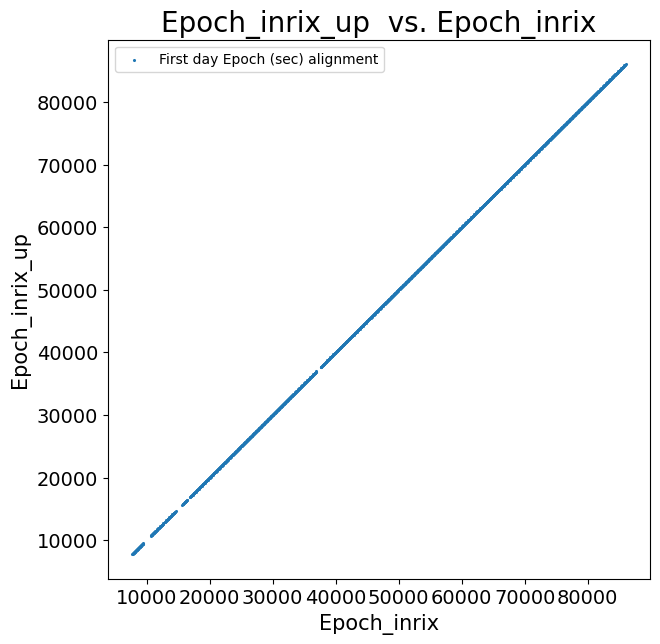

In [ ]:
# draw plot of epoch_mcs vs. epoch_inrix after shifting
plt.figure(figsize = (7, 7))
combinedSouth1day_shifted = combinedSouth_shifted.iloc[:idx(combinedSouth_shifted, 2)]
plotScatter(combinedSouth1day_shifted, combinedSouth1day_shifted, 'Epoch_inrix', 'Epoch_inrix_up','First day Epoch (sec) alignment')

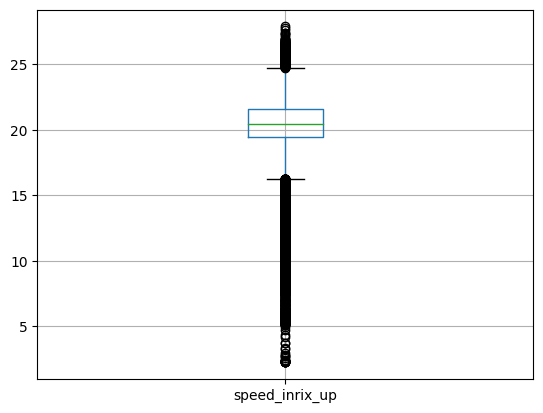

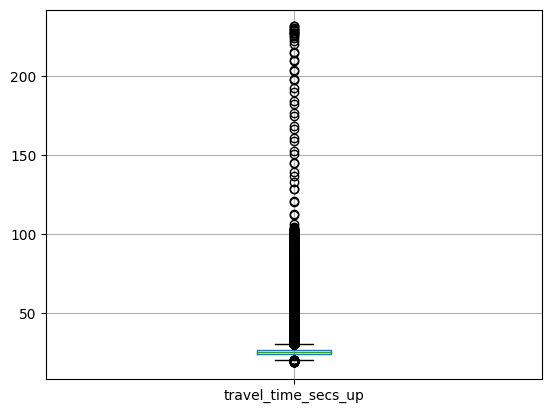

In [ ]:
# check distribution of speed_inrix and tracel_time_secs after remove low score data and match the timesteps among MCS and INRIX

plt.figure(1)
boxplot = combinedSouth_shifted.boxplot(column=['speed_inrix_up'])

plt.figure(2)
boxplot = combinedSouth_shifted.boxplot(column=['travel_time_secs_up'])

             speed_inrix     speed
speed_inrix     1.000000  0.921197
speed           0.921197  1.000000


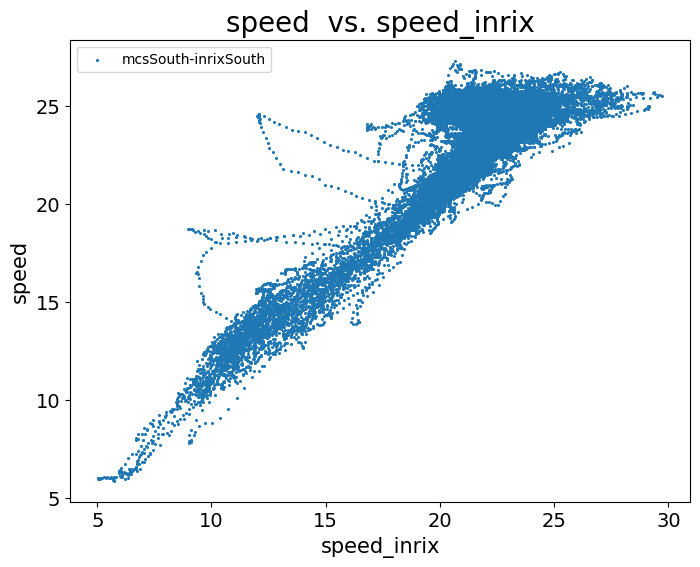

In [ ]:
# draw plot of Speed_mcs vs. Speed_inrix after timestep matching
combinedCorr1 = combinedSouth_shifted.iloc[:idx(combinedSouth_shifted, 28)][['speed_inrix', 'speed']].copy() 
print(combinedCorr1.corr())

plt.figure(figsize=(8,6))
plotScatter(combinedCorr1, combinedCorr1, 'speed_inrix', 'speed', 'mcsSouth-inrixSouth')

                speed_inrix  speed_inrix_up
speed_inrix        1.000000        0.956047
speed_inrix_up     0.956047        1.000000


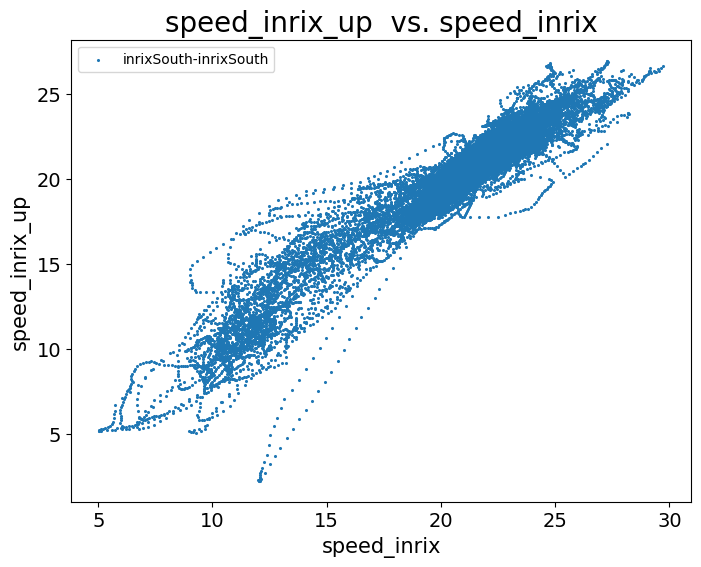

In [ ]:
# draw plot of Speed_inrix(South) vs. Speed_inrix_up (North) after timestep matching
Corr1 = combinedSouth_shifted.iloc[:idx(combinedSouth_shifted, 28)][['speed_inrix', 'speed_inrix_up']].copy() 
print(Corr1.corr())

plt.figure(figsize=(8,6))
plotScatter(Corr1, Corr1, 'speed_inrix', 'speed_inrix_up', 'inrixSouth-inrixSouth')

             speed_inrix      flow
speed_inrix     1.000000 -0.590272
flow           -0.590272  1.000000


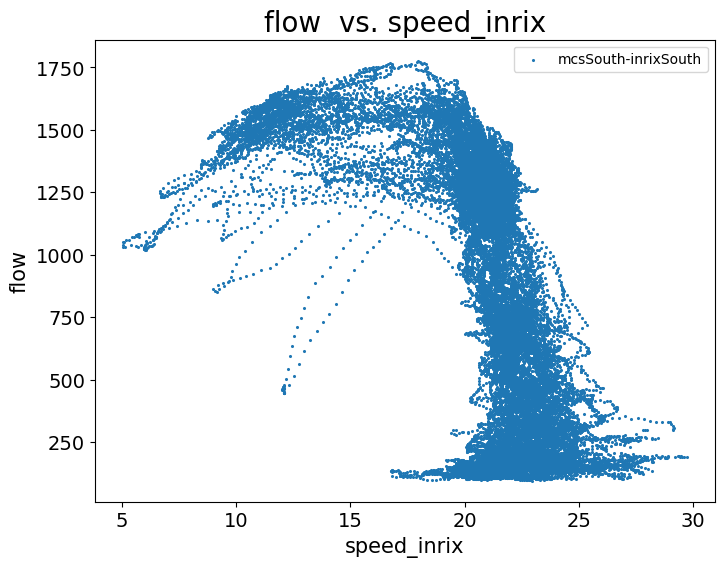

In [ ]:
# draw flow_mcs vs. Speed_inrix after time step matched
combinedCorr2 = combinedSouth_shifted.iloc[:idx(combinedSouth_shifted, 28)][['speed_inrix', 'flow']].copy() # until 27th Oct
print(combinedCorr2.corr())

plt.figure(figsize=(8,6))
plotScatter(combinedCorr2, combinedCorr2, 'speed_inrix', 'flow', 'mcsSouth-inrixSouth')

                speed_inrix_up      flow
speed_inrix_up        1.000000 -0.552844
flow                 -0.552844  1.000000


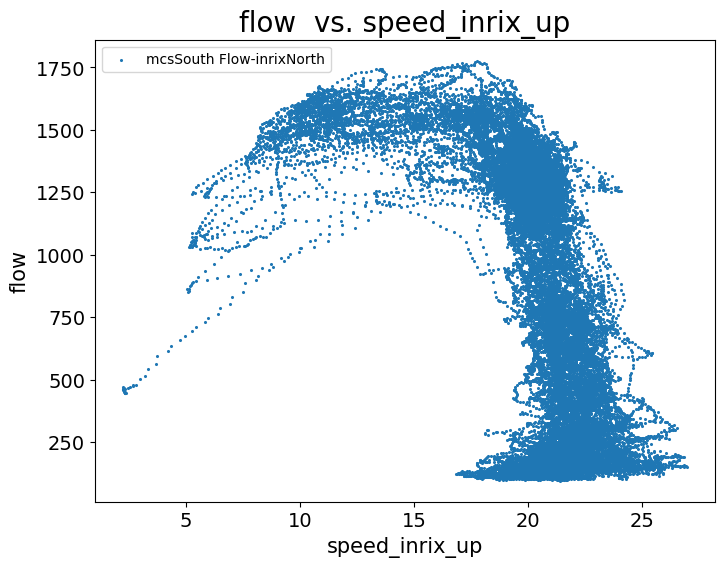

In [ ]:
# draw flow_mcs vs. Speed_inrix_up (North) after time step matched
Corr2 = combinedSouth_shifted.iloc[:idx(combinedSouth_shifted, 28)][['speed_inrix_up', 'flow']].copy() # until 27th Oct 23:59
print(Corr2.corr())

plt.figure(figsize=(8,6))
plotScatter(Corr2, Corr2, 'speed_inrix_up', 'flow', 'mcsSouth Flow-inrixNorth')

          speed      flow
speed  1.000000 -0.746619
flow  -0.746619  1.000000


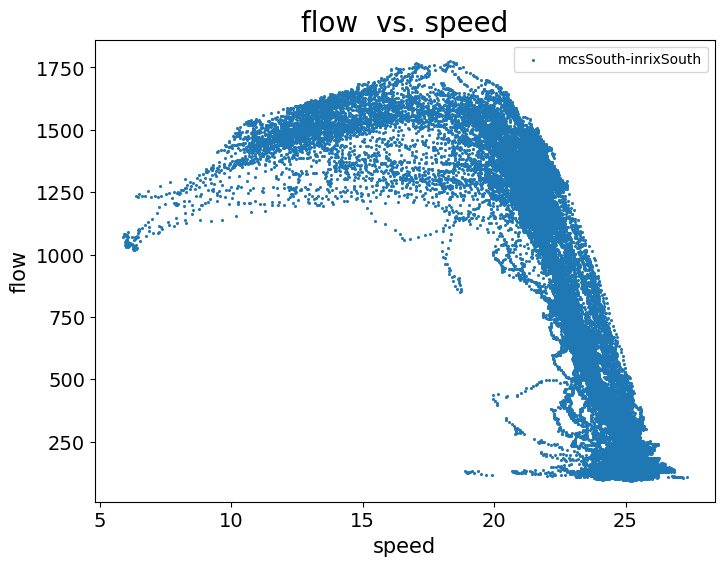

In [ ]:
# draw flow_mcs vs. Speed_mcs after time step matched
combinedCorr3 = combinedSouth_shifted.iloc[:][['speed', 'flow']].copy()
print(combinedCorr3.corr())

plt.figure(figsize=(8,6))
plotScatter(combinedCorr3, combinedCorr3, 'speed', 'flow', 'mcsSouth-inrixSouth')

## 4.4 add temporal factor: day/night

In [ ]:
# load the combined/processed dataframe
# start from this cell if data frame has been processed before
combinedSouth_shifted = pd.read_pickle('OutData/inrixMcsSouth.pkl')

In [ ]:
# function to plot 1 attribute vs. atrribute from 1 sensor
def plotAttrDatetime(days, dataFrame, xAttr, yAttr, sensor_name, color):
  plt.style.use('default')
  ax = plt.axes()
  ax.plot(dataFrame[xAttr], dataFrame[yAttr], color, linewidth = 1.2, label = sensor_name)
  my_formatter = DateFormatter("%H:%M")
  auto_locator = AutoDateLocator()
  ax.xaxis.set_major_locator(HourLocator(interval=1))
  ax.xaxis.set_major_formatter(my_formatter)
  plt.gcf().autofmt_xdate()
  plt.xlabel(xAttr, fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(yAttr, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(yAttr + ' vs. ' + xAttr + ' (' + str(days) + ' )', fontsize = 18)
  plt.legend()
  plt.grid()
  plt.show()

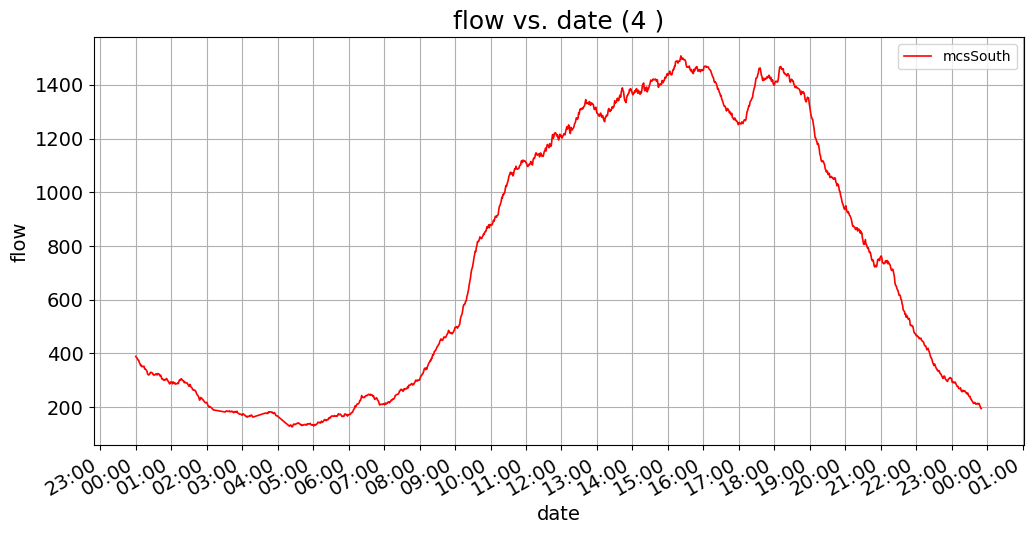

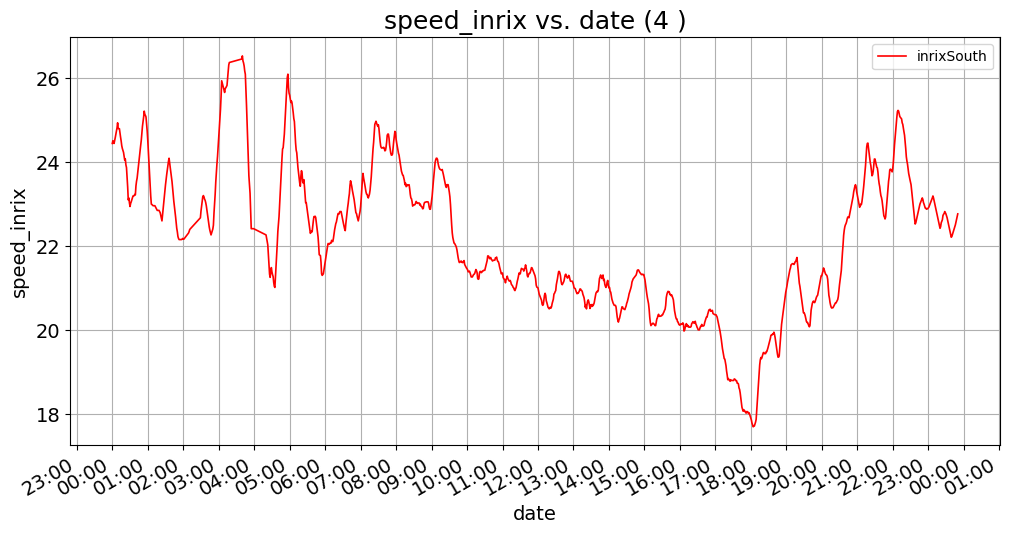

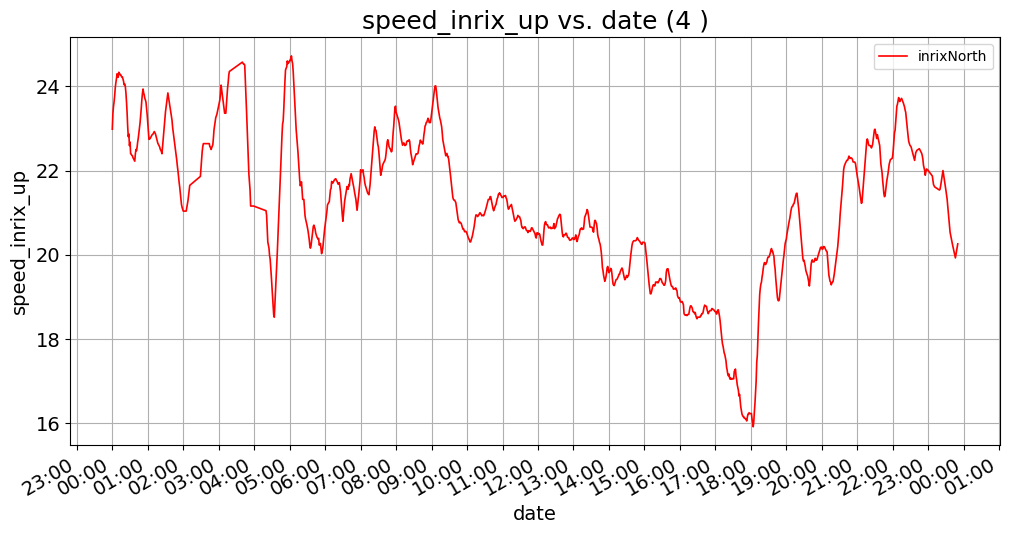

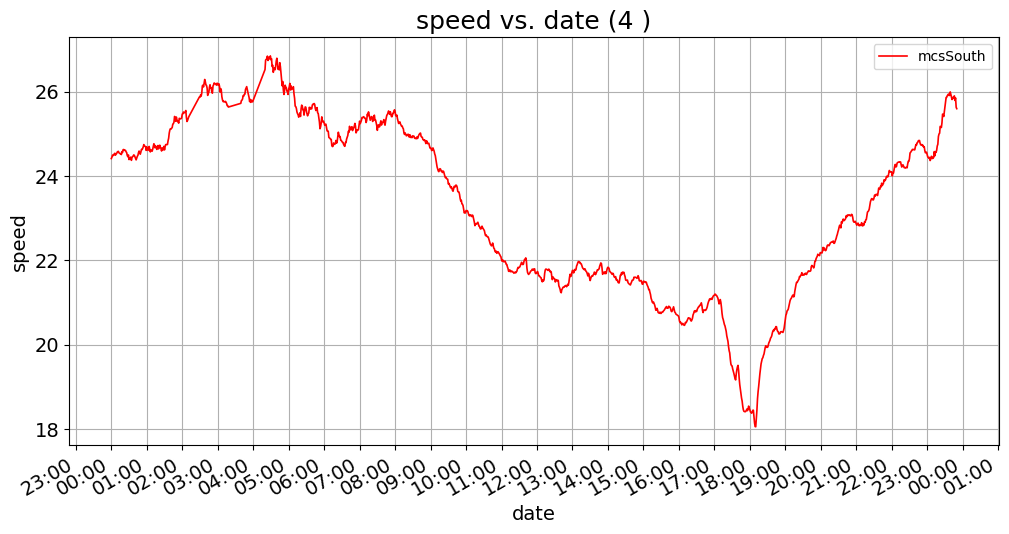

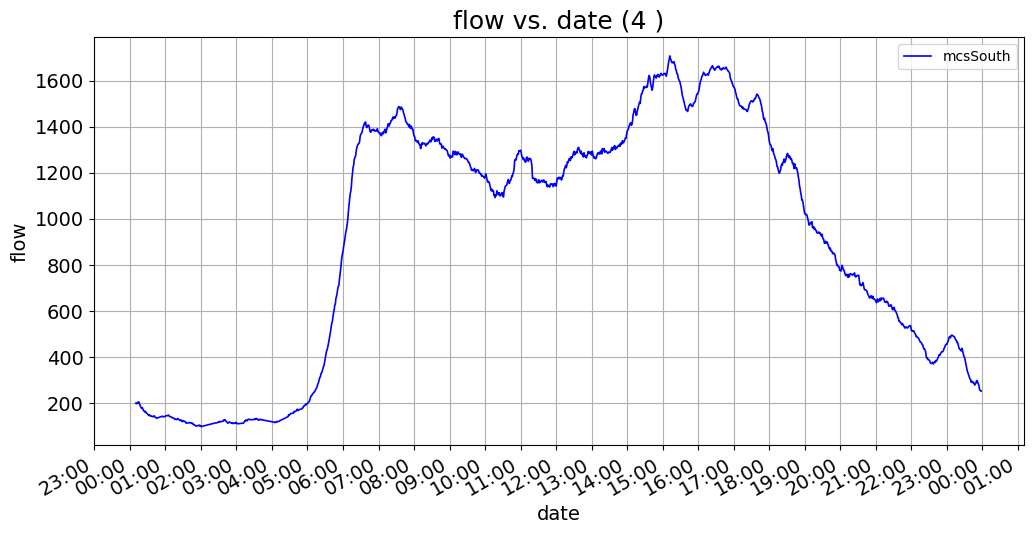

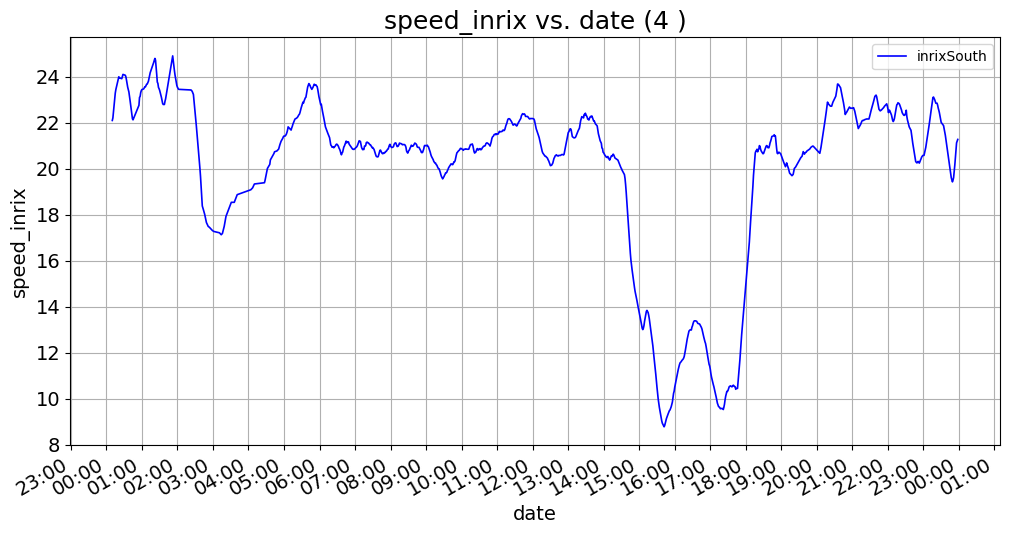

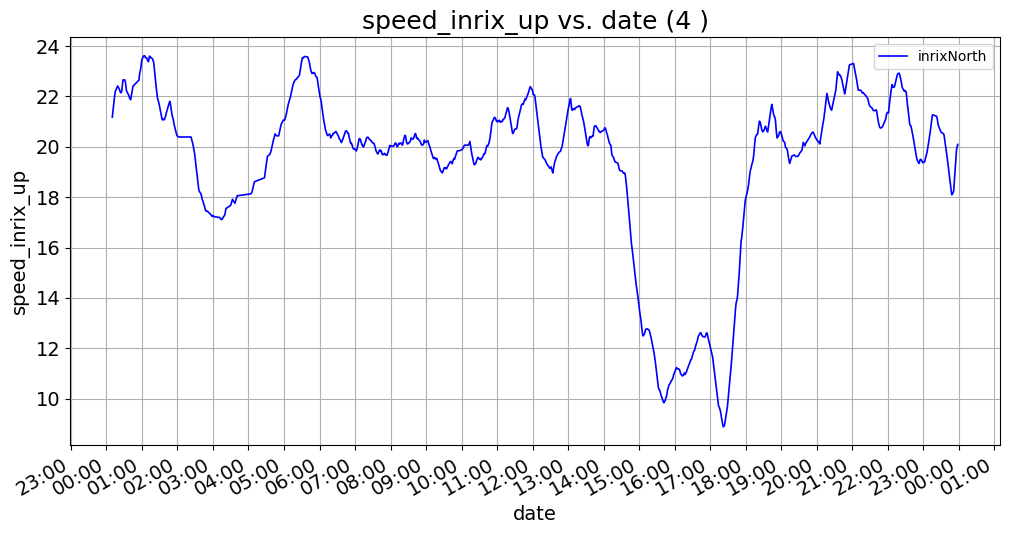

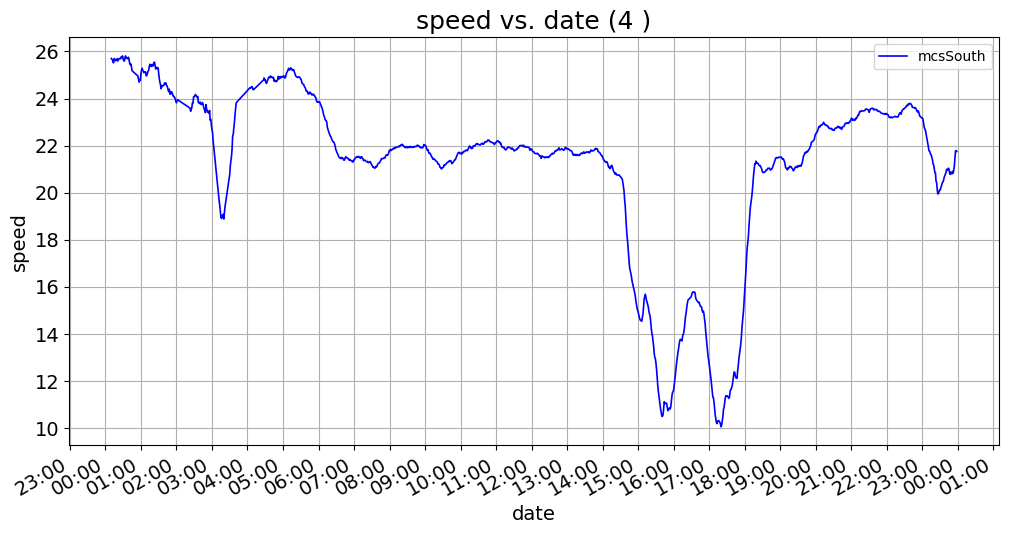

In [ ]:
# Decide the boundaries of daytime according to the flow-datetime relation 
#weekends
WEEKEND1 = 14
WEEKEND2 = 15
plt.figure(figsize=(12,6))
plotAttrDatetime(4, combinedSouth_shifted[idx(combinedSouth_shifted,WEEKEND1):idx(combinedSouth_shifted, WEEKEND2)], 
                 'date', 'flow', 'mcsSouth', 'r')
plt.figure(figsize=(12,6))
plotAttrDatetime(4, combinedSouth_shifted[idx(combinedSouth_shifted,WEEKEND1):idx(combinedSouth_shifted, WEEKEND2)],
                 'date', 'speed_inrix', 'inrixSouth', 'r')
plt.figure(figsize=(12,6))
plotAttrDatetime(4, combinedSouth_shifted[idx(combinedSouth_shifted,WEEKEND1):idx(combinedSouth_shifted, WEEKEND2)],
                 'date', 'speed_inrix_up', 'inrixNorth', 'r')
plt.figure(figsize=(12,6))
plotAttrDatetime(4, combinedSouth_shifted[idx(combinedSouth_shifted,WEEKEND1):idx(combinedSouth_shifted, WEEKEND2)],
                 'date', 'speed', 'mcsSouth', 'r')

#weekdays 6:00 to 20:00
WEEKDAY1 = 16
WEEKDAY2 = 17
plt.figure(figsize=(12,6))
plotAttrDatetime(4, combinedSouth_shifted[idx(combinedSouth_shifted,WEEKDAY1):idx(combinedSouth_shifted, WEEKDAY2)], 
                 'date', 'flow', 'mcsSouth', 'b')
plt.figure(figsize=(12,6))
plotAttrDatetime(4, combinedSouth_shifted[idx(combinedSouth_shifted,WEEKDAY1):idx(combinedSouth_shifted, WEEKDAY2)],
                 'date', 'speed_inrix', 'inrixSouth', 'b')
plt.figure(figsize=(12,6))
plotAttrDatetime(4, combinedSouth_shifted[idx(combinedSouth_shifted,WEEKDAY1):idx(combinedSouth_shifted, WEEKDAY2)],
                 'date', 'speed_inrix_up', 'inrixNorth', 'b')
plt.figure(figsize=(12,6))
plotAttrDatetime(4, combinedSouth_shifted[idx(combinedSouth_shifted,WEEKDAY1):idx(combinedSouth_shifted, WEEKDAY2)],
                 'date', 'speed', 'mcsSouth', 'b')

In [ ]:
# add temporal factor for dataset:
# DAYTIMESTARTHOUR< hour < DAYTIMEENDHOUR : 1.0 (daytime)
# else: 0.0 (night)
func = lambda x: DAYTIME if (x.hour >= DAYTIMESTARTHOUR and x.hour < DAYTIMEENDHOUR) else 0.0

combinedSouth_shifted['daytime'] = combinedSouth_shifted.date.apply(func)

In [ ]:
# save the processed dataframe into the directory
combinedSouth_shifted.to_pickle('OutData/inrixMcsSouth_temp.pkl')

# 5. Linear (Polynomial) Regression Models
  Use linear (polynomial) regression model to capture the relation between speed/travel time and MCS flow/denstiy

*   Ground Truth Model: Mcs speed -> Mcs Flow ( or Density)
*   INRIX speed -> MCS Flow



In [ ]:
# load the combined/processed dataframe
# start from this cell if data frame has been processed before
combinedSouth_shifted = pd.read_pickle('OutData/inrixMcsSouth_temp.pkl')

## 5.0 helper function to plot fitting results

In [ ]:
# function to plot the predicted value and real label value according to training/testing dataset
def plotResult(xTrain, yTrain, yPredTrain, xTest, yTest, yPredTest, timeRange, xLabel, yLabel, plotStyle = 's'):
  plt.style.use('default')
  if (xTest is not None):
    plt.scatter(xTrain, yTrain, s=3, color='black', label='real flow(train_set)')
    plt.scatter(xTrain, yPredTrain, s= 25, color='blue', marker = "s", label='predicted flow(train_set)')
    plt.scatter(xTest, yTest, color='red', s=3, label='real flow(test_set)')
    plt.scatter(xTest, yPredTest, color='green', s=25, marker = 's', label='predicted flow(test_set)')
  elif (plotStyle == 'p'):
    plt.plot(xTrain, yPredTrain, linewidth=1.5, color='blue', linestyle = 'dashed', mfc='none',  label='predicted flow', zorder= 0, marker='o')
    plt.scatter(xTrain, yTrain, s=3, color='red', label='real flow', zorder= 10)
  elif (plotStyle == 's'):
    plt.scatter(xTrain, yTrain, s = 3, color='green', label='real flow(train_set)')
    plt.scatter(xTrain, yPredTrain, s= 15, color='red', marker = "s", facecolors='none', label='predicted flow(train_set)')
    
  plt.xlabel(xLabel, fontsize= 15) 
  plt.xticks(fontsize = 10)
  plt.ylabel(yLabel, fontsize=15)
  plt.yticks(fontsize = 10)
  plt.title('Regression model for estimation of ' + yLabel + ' in ' + timeRange, fontsize= 14)
  plt.legend(fontsize=12, loc=1)
  plt.grid()
  plt.show()

## 5.1 Reference linear regression model: MCS Speed -> MCS FLow

In [ ]:
# function for turning single feature into polynomial feature columns 
# Input X: numpy array with shape(sample number, )
# Output X_poly: numpy array with shape(sample #, polynomial degree + 1) *1: for bias
def makePoly(deg, X, bias = True):
  poly = PolynomialFeatures(degree = deg,include_bias = bias)
  X_1 = X.reshape(-1, 1)
  X_poly = poly.fit_transform(X_1)
  return X_poly

In [ ]:
# funtion for normalizing the feature columns
# Input: X: Numpy array with shape(sample #, polynomial degree + 1)
# Output X_scaled: normalized Numpy array with shape(sample #, polynomial degree + 1)
# Output scaler: scaler, which fitted on input array, for normalization
def normalize(X, Scaler=None):
  # remove the bias column
  X_1 = np.delete(X, 0, 1)

  # scale the remaining feature columns
  scaler = None
  X_2 = None

  if(Scaler==None):
    scaler = StandardScaler()
    X_2 = scaler.fit_transform(X_1)
  else:
    scaler = Scaler
    X_2 = scaler.transform(X_1)

  # add the bias column back to the features columns
  ones = np.ones((len(X_2), 1))
  X_scaled = np.append(ones, X_2, 1)
  
  return X_scaled, scaler

In [ ]:
# function to build and fit linear model on input arrays
def LRmodel(X_train, Y_train):
  regressor = LinearRegression(fit_intercept=False)
  regressor.fit(X_train, Y_train)
  return regressor

In [ ]:
# function used to print the cross-validation scores on training set
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean()) 
  print("Standard deviation:", scores.std())

In [ ]:
# select 2~3 weeks data to build model
combinedSouth_2w = combinedSouth_shifted.iloc[:idx(combinedSouth_shifted, 22)]

# prepare the feature "MCS speed" + "temporal factor"
X_epoch = combinedSouth_2w['Epoch_mcs'].values
X_mcs_speed = combinedSouth_2w['speed'].values
X_temporal = combinedSouth_2w['daytime'].values
Y_flow = combinedSouth_2w['flow'].values

# turn single feature into polynomial features matrix: 1, s, s^2, s^3, ...
X_mcs_speed = makePoly(3, X_mcs_speed)
X_mcs_speed, scaler_mcs_speed = normalize(X_mcs_speed)

# append temporal factor to the polynomialized/scaled X_mcs_speed
X_mcs_speed_temp = np.append(X_mcs_speed, X_temporal.reshape(-1,1), axis=1)

# code for monitoring feature matrix
# could be commented out while don't want to print out
dfRawFeatures = pd.DataFrame(X_mcs_speed_temp)
dfRawFeatures.describe()

0             1             2             3             4
count  28387.0  2.838700e+04  2.838700e+04  2.838700e+04  28387.000000
mean       1.0 -1.190719e-14 -3.839713e-15 -1.295532e-14      0.619509
std        0.0  1.000018e+00  1.000018e+00  1.000018e+00      0.485516
min        1.0 -4.967381e+00 -3.668334e+00 -2.890966e+00      0.000000
25%        1.0 -1.960567e-01 -3.038539e-01 -3.995223e-01      0.000000
50%        1.0  7.093544e-02 -2.726643e-03 -7.741623e-02      1.000000
75%        1.0  7.201136e-01  7.793484e-01  8.166483e-01      1.000000
max        1.0  1.522198e+00  1.843292e+00  2.156109e+00      1.000000

In [ ]:
# assign normalized polynomial features matrix into feature matrix,
# assign predict target to label array
X_features = X_mcs_speed_temp
Y_label = Y_flow

# split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)

In [ ]:
# Use 10 folds cross-validation to fit and validate the model by training set
scores = cross_val_score(LinearRegression(fit_intercept=False), X_train, Y_train, scoring='r2', cv=10)
display_scores(scores)

Scores: [0.91717358 0.92046882 0.91509082 0.91228295 0.90930196 0.91280814
 0.91631489 0.90597251 0.91397074 0.91290666]
Mean: 0.9136291068017351
Standard deviation: 0.0038622222129410027


In [ ]:
# Build the regression model fitted on train dataset
regressor = LRmodel(X_train, Y_train)
regressor.fit(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = regressor.predict(X_train)
print("Root Mean Square Error for training set: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for training set: ", r2_score(Y_train, Y_predict_train))

# Evaluate Performance of testing set
Y_predict_test = regressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

Root Mean Square Error for training set:  149.72976504364263
R2 Score for training set:  0.9137434023442358
Root Mean Square Error:  149.77638674852386
R2 Score:  0.9153251488434642


6:00 ~ 18:00: R2=0.8944627156998969 <br>
6:00 ~ 20:00: R2= 0.902 <br>

In [ ]:
# print the coefficient of the linear model
regressor.coef_

array([  670.77237324,    66.08396502,  1002.38574316, -1376.08388991,
         370.23732954])

  R2 experiments:
  * d = 2 (0.71)
  * d = 3 (0.53, 0.533) 
  * d = 4 (0.80)
  * d = 5 (0.81)
  * d = 6 (0.83)



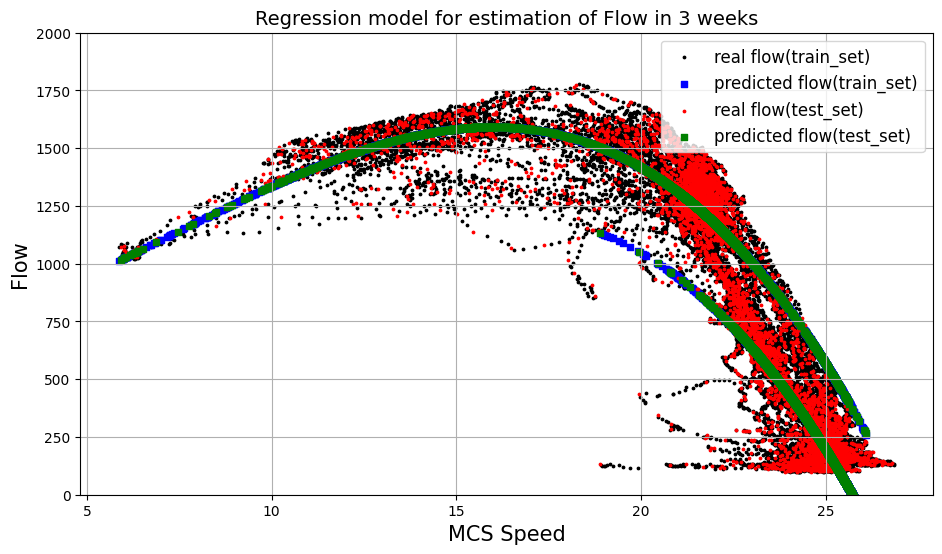

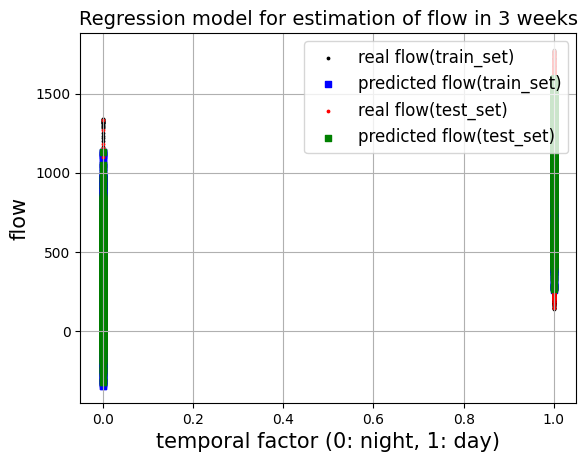

In [ ]:
# Plot real and predicted flow for X_train, X_test
X_train_denormalized = scaler_mcs_speed.inverse_transform(X_train[:,1:-1])
X_test_denormalized = scaler_mcs_speed.inverse_transform(X_test[:, 1:-1])
plt.figure(figsize=(11, 6))
plt.ylim(top = 2000)
#plt.xlim(left=-7, right = 2)
plotResult(X_train_denormalized[:, 0], Y_train, Y_predict_train, 
           X_test_denormalized[:, 0], Y_test, Y_predict_test, '3 weeks', 'MCS Speed', 'Flow')

# plot flow vs. temporal factor
plotResult(X_train[:, -1], Y_train, Y_predict_train, 
           X_test[:, -1], Y_test, Y_predict_test, '3 weeks', 'temporal factor (0: night, 1: day)', 'flow')

In [ ]:
# Use all data to train and predict the flow
Y_predict = regressor.predict(X_features)

In [ ]:
combinedSouth_2w.iloc[idx(combinedSouth_2w, ENDDATE) + DELTA_STEP].date

NameError: ignored

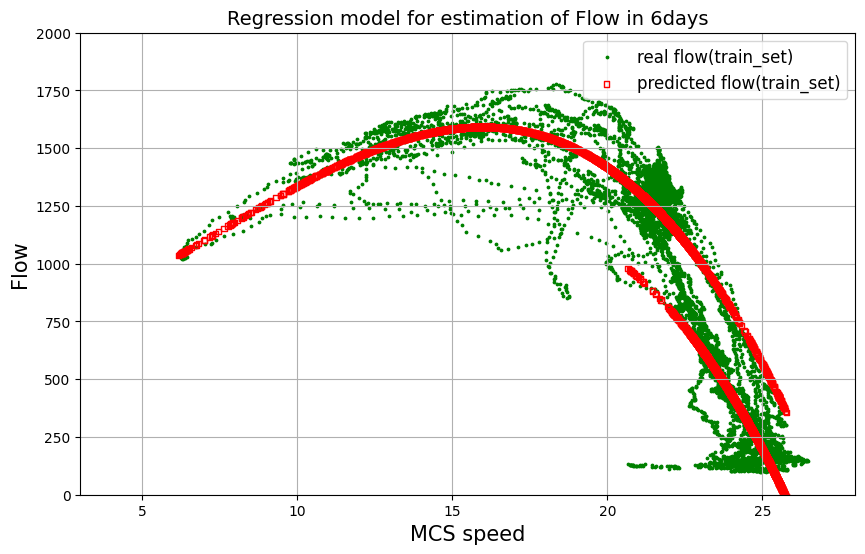

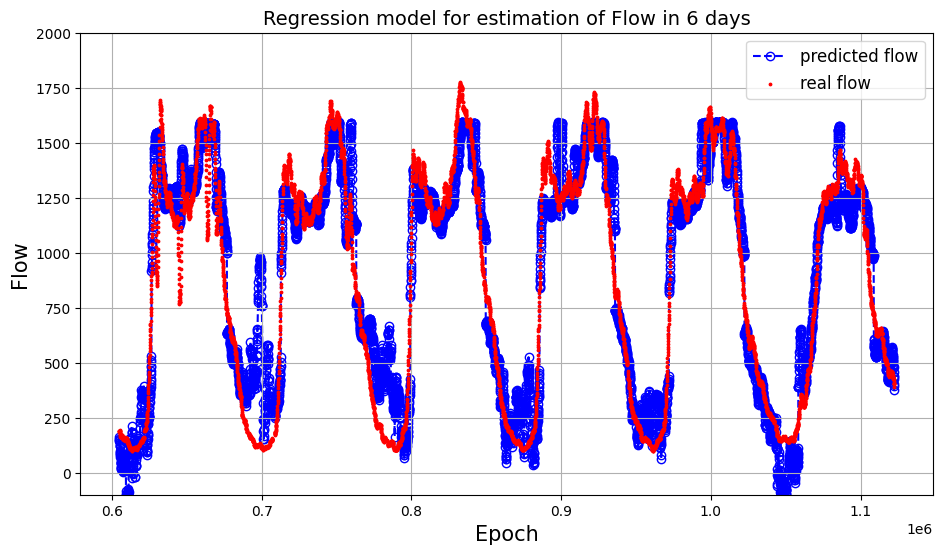

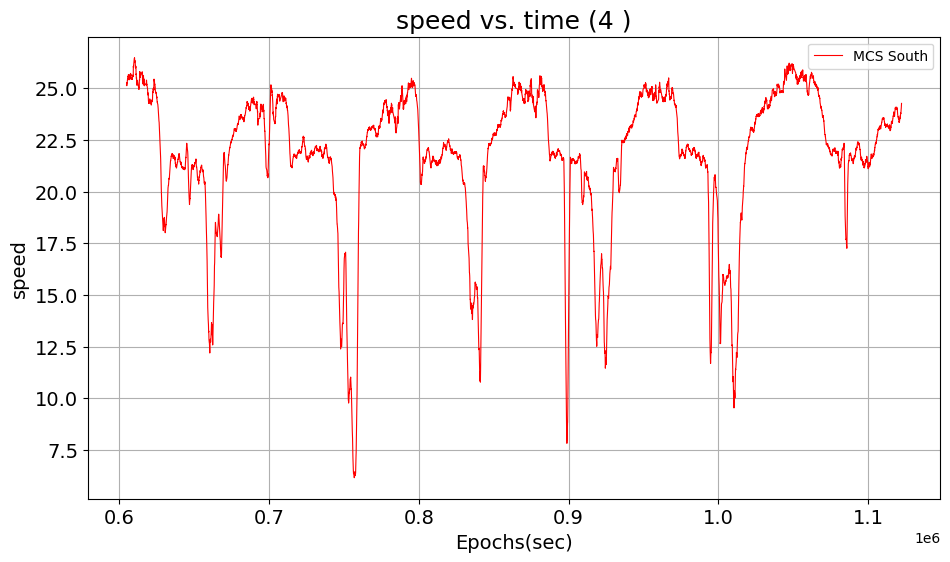

In [ ]:
STARTDATE = 8
ENDDATE = 14
DELTA_STEP = 00
# Plot real and predicted flow vs. X_features (speed_mcs)
X_features_mcs_denormalized = scaler_mcs_speed.inverse_transform(X_features[:,1:-1])
plt.figure(figsize=(10, 6))
plt.ylim(bottom = 0, top=2000)
plt.xlim(left = 3, right=28)
plotResult(X_features_mcs_denormalized[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 0], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '6days', 'MCS speed', 'Flow')

# plotResult(X_features_mcs_denormalized[:, 0], Y_label, Y_predict, 
#            None,  None, None, '3 weeks', 'MCS speed', 'Flow')


# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(11, 6))
plt.ylim(bottom = -100, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_label[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None, None, None, '6 days', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs speed 
plt.figure(figsize=(11, 6))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 'speed', 'MCS South')


    test the model on the future dataset 22nd - 26th

## 5.2 Linear regression model: INRIX Speed -> MCS Flow

In [ ]:
# prepare the feature "INRIX speed"
X_inrix_speed = combinedSouth_2w['speed_inrix'].values
X_inrix_speed_up = combinedSouth_2w['speed_inrix_up'].values
Y_flow = combinedSouth_2w['flow'].values
X_temporal = combinedSouth_2w['daytime'].values

# turn single features into polynomial features matrix: 1, s, s^2, s^3, ...
X_inrix_speed = makePoly(4, X_inrix_speed)
X_inrix_speed, scaler_inrix_speed = normalize(X_inrix_speed)
X_inrix_speed_up = makePoly(4, X_inrix_speed_up) # upstream speed
X_inrix_speed_up, scaler_inrix_speed_up = normalize(X_inrix_speed_up)
X_inrix_speed_up = np.delete(X_inrix_speed_up, 0, axis=1)

# combine (normalized/polymerized) speed, speed_upstream, temporal factor to a feature vector
X_inrix_features = np.concatenate((X_inrix_speed, X_inrix_speed_up, X_temporal.reshape(-1,1)), axis=1)


# code for monitoring feature matrix
# could be commented out while don't want to print out
dfRawFeatures = pd.DataFrame(X_inrix_features)
dfRawFeatures.describe()

0             1  ...             8             9
count  28387.0  2.838700e+04  ...  2.838700e+04  28387.000000
mean       1.0  3.785811e-15  ...  6.826790e-15      0.619509
std        0.0  1.000018e+00  ...  1.000018e+00      0.485516
min        1.0 -4.825326e+00  ... -2.391580e+00      0.000000
25%        1.0 -1.274934e-01  ... -4.484131e-01      0.000000
50%        1.0  1.522075e-01  ... -1.933442e-02      1.000000
75%        1.0  5.032606e-01  ...  5.267678e-01      1.000000
max        1.0  2.780825e+00  ...  4.603013e+00      1.000000

[8 rows x 10 columns]

In [ ]:
# assign normalized polynomial features matrix into feature matrix,
# assign predict target to label array
X_features = X_inrix_features
Y_label = Y_flow

# split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)

In [ ]:
# Use 10 folds cross-validation to fit and validate the model by training set
scores = cross_val_score(LinearRegression(fit_intercept=False), X_train, Y_train, scoring='r2', cv=10)
display_scores(scores)

Scores: [0.79564019 0.79500391 0.78216115 0.7741053  0.79389138 0.78527707
 0.79604678 0.79049906 0.78874636 0.78247907]
Mean: 0.7883850275035403
Standard deviation: 0.006908374047687341


In [ ]:
# Build the regression model fitted on whole train dataset
regressor = LRmodel(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = regressor.predict(X_train)
print("Root Mean Square Error for training set: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for training set: ", r2_score(Y_train, Y_predict_train))

# Evaluate Performance of testing set
Y_predict_test = regressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

Root Mean Square Error for training set:  234.40421282155984
R2 Score for training set:  0.7885990848744227
Root Mean Square Error:  235.30679713220616
R2 Score:  0.7910046188244672


6:00 to 18:00: 0.7204284190785<br>
6:00 to 20:00: 0.787160 <br>

In [ ]:
# print the coefficient of the linear model
regressor.coef_

array([   477.09348491,  -2247.68075055,   9200.04725344, -11881.57913895,
         4832.05885566,   1546.08778485,  -4225.10714718,   3744.50739869,
        -1076.09543724,    685.09168399])

    R2 Experiment(10-folds cross validation on train dataset):
    * d = 2: 
    * d = 3: 0.45
    * d = 4: 0.477
    * d = 5: 0.49
    * d = 6: 0.48
    * d = 7: 0.49
    * d = 8: 

  

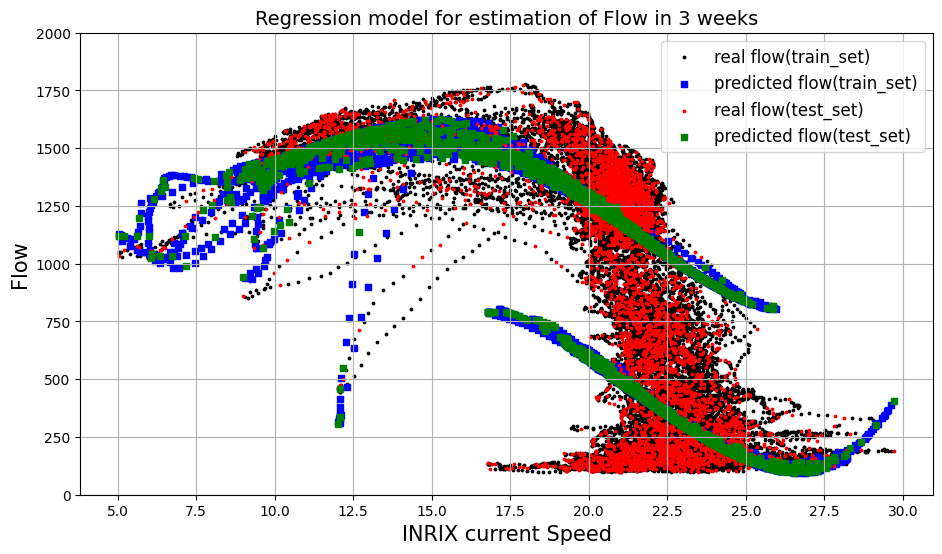

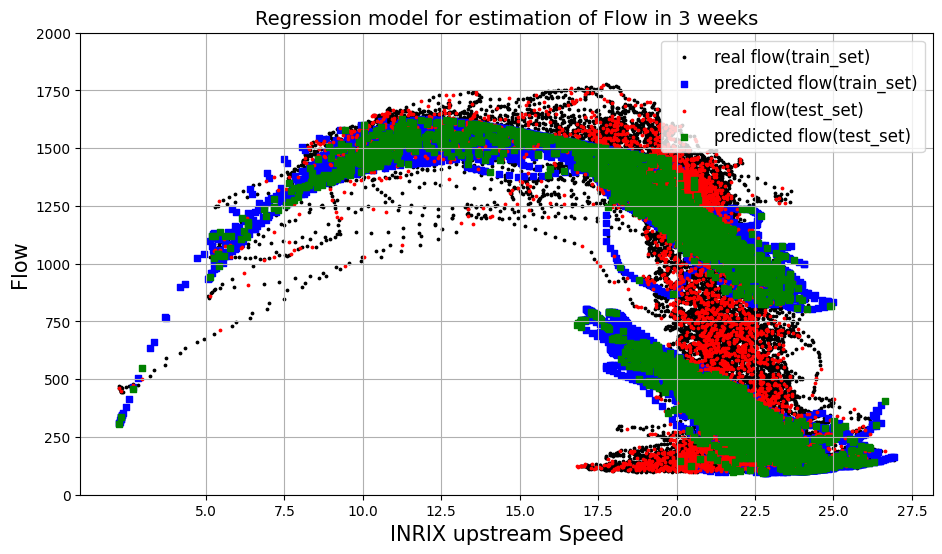

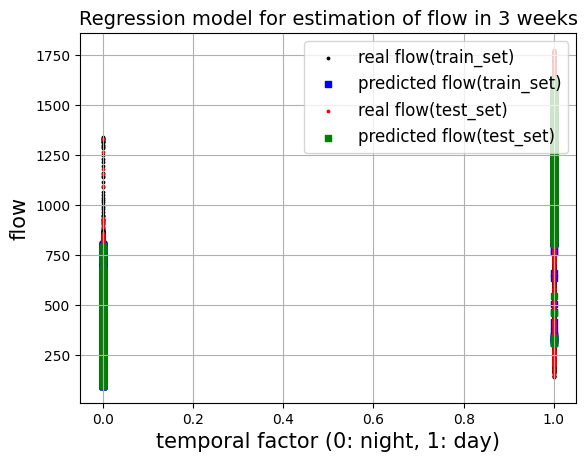

In [ ]:
X_train_denormalized = scaler_inrix_speed.inverse_transform(X_train[:,1:5])
X_test_denormalized = scaler_inrix_speed.inverse_transform(X_test[:, 1:5])
X_train_up_denormalized = scaler_inrix_speed_up.inverse_transform(X_train[:,5:9])
X_test_up_denormalized = scaler_inrix_speed_up.inverse_transform(X_test[:,5:9])

# Plot real and predicted flow for X_train(South), X_test
plt.figure(figsize=(11, 6))
plt.ylim(top = 2000)
#plt.xlim(left=-7, right = 2)
plt.xticks(np.arange(5, 40, step=2.5))
plotResult(X_train_denormalized[:, 0], Y_train, Y_predict_train, 
           X_test_denormalized[:, 0], Y_test, Y_predict_test, '3 weeks', 'INRIX current Speed', 'Flow')

# Plot real and predicted flow for X_train(South), X_test
plt.figure(figsize=(11, 6))
plt.ylim(top = 2000)
#plt.xlim(left=-7, right = 2)
plt.xticks(np.arange(5, 40, step=2.5))
plotResult(X_train_up_denormalized[:, 0], Y_train, Y_predict_train, 
           X_test_up_denormalized[:, 0], Y_test, Y_predict_test, '3 weeks', 'INRIX upstream Speed', 'Flow')

# plot flow vs. temporal factor
plotResult(X_train[:, -1], Y_train, Y_predict_train, 
           X_test[:, -1], Y_test, Y_predict_test, '3 weeks', 'temporal factor (0: night, 1: day)', 'flow')

In [ ]:
# Use all dataset to train and predict the flow 
#(only for drawing plot, accuracy is not important)
Y_predict = regressor.predict(X_features)

In [ ]:
print(combinedSouth_2w.iloc[idx(combinedSouth_2w, STARTDATE) + DELTA_STEP].date)
print(combinedSouth_2w.iloc[idx(combinedSouth_2w, ENDDATE) + DELTA_STEP2].date)

2018-10-08 00:00:00
2018-10-14 00:00:00


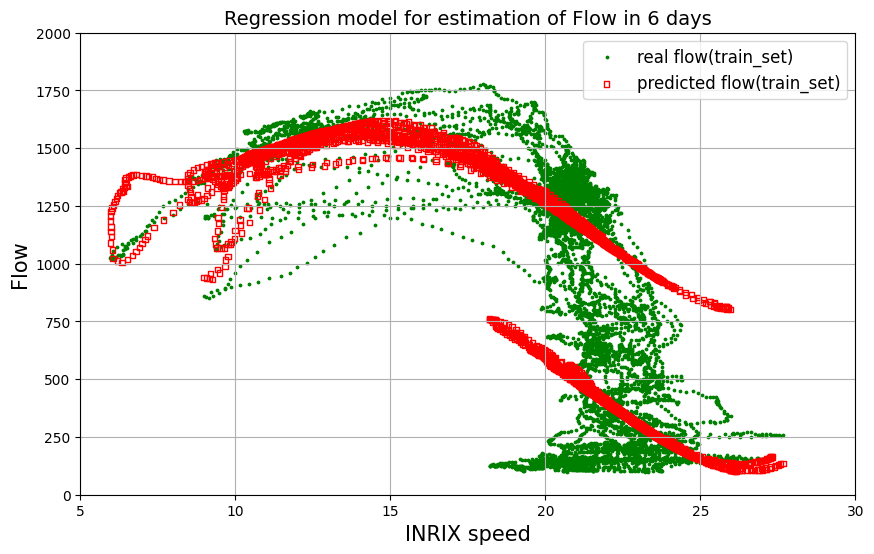

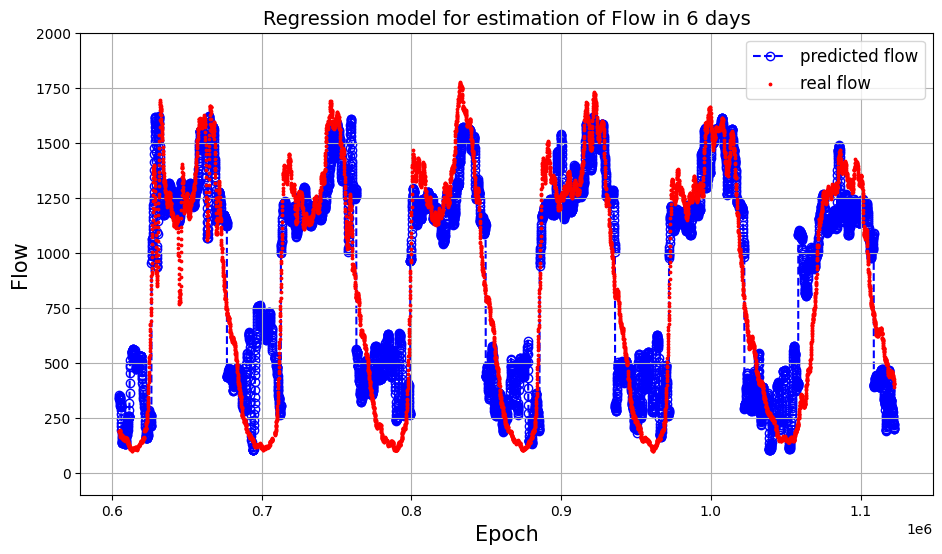

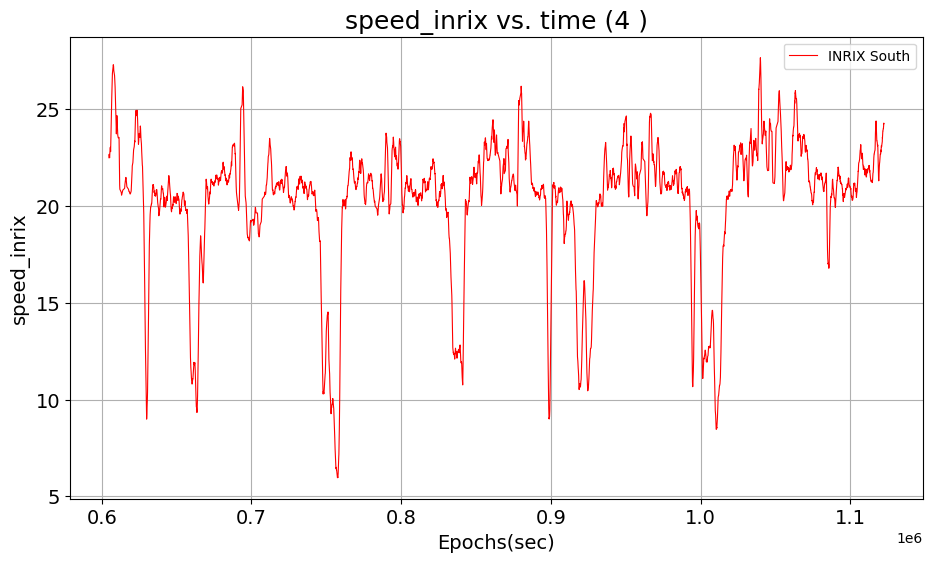

In [ ]:
STARTDATE = 8
ENDDATE = 14
DELTA_STEP = 0
DELTA_STEP2 = 0
X_features_inrix_denormalized = scaler_inrix_speed.inverse_transform(X_features[:,1:5])
# Plot real and predicted flow vs. X_features (speed_inrix)
plt.figure(figsize=(10, 6))
plt.ylim(bottom = 0, top=2000)
plt.xlim(left = 5, right=30)
plotResult(X_features_inrix_denormalized[idx(combinedSouth_2w, STARTDATE) +DELTA_STEP: idx(combinedSouth_2w, ENDDATE) + DELTA_STEP2, 0], 
           Y_label[idx(combinedSouth_2w, STARTDATE)+DELTA_STEP: idx(combinedSouth_2w, ENDDATE) + DELTA_STEP2], 
           Y_predict[idx(combinedSouth_2w, STARTDATE)+DELTA_STEP : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP2], 
           None,  None, None, '6 days', 'INRIX speed', 'Flow')

# plotResult(X_features_mcs_denormalized[:, 0], Y_label, Y_predict, 
#            None,  None, None, '3 weeks', 'MCS speed', 'Flow')


# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(11, 6))
plt.ylim(bottom = -100, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, STARTDATE)+DELTA_STEP:idx(combinedSouth_2w, ENDDATE) + DELTA_STEP2], 
           Y_label[idx(combinedSouth_2w, STARTDATE)+DELTA_STEP:idx(combinedSouth_2w, ENDDATE) + DELTA_STEP2], 
           Y_predict[idx(combinedSouth_2w, STARTDATE)+DELTA_STEP:idx(combinedSouth_2w, ENDDATE) + DELTA_STEP2], 
           None, None, None, '6 days', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs speed 
plt.figure(figsize=(11, 6))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 'speed_inrix', 'INRIX South')


      add future prediction!!

# 6. Dicision Tree


*   Use decision tree to extract dependency between MCS speed and (MCS) flow
*   Use decision tree to extract dependency between INRIX speed, INRIX travel time and (MCS) flow



## 6.1 Decision tree model: MCS speed -> MCS flow



In [ ]:
# function for quickly tuning the depth of the decision tree 
# (should use cross validation for hyper-parameter tuning)
# Input: decision tree model, train and test datasets, and a list that specifies the 
# depth splits, eg: split = [2, 3, 4, 5, 6] tests depth from 2 to 6
# Output: return the experiment result in as dataframe with 3 columns:
# depth split, r2 for test dataset, r2 for train dataset.
def quickSplitTuning(model, x_train, y_train, x_test, y_test, split):
  trainR2Array = []
  testR2Array = []
  for i in split:
    estimator = model(max_depth = i, random_state = 0)
    estimator.fit(x_train, y_train)
    trainR2Array.append(estimator.score(x_train, y_train))
    testR2Array.append(estimator.score(x_test, y_test))
  result = pd.DataFrame({'split': split, 'Train_R2': trainR2Array, 'Test_R2': testR2Array})
  
  return result


In [ ]:
# prepare the features [MCS speed] and label [flow]
# Notice: Y_flow was already defined in previous section 3.
# X_epoch was already defined
X_mcs_speed_temp = combinedSouth_2w[['speed', 'daytime']].values

X_features = X_mcs_speed_temp
Y_label = Y_flow

print(X_features.shape)

# split the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)


(28387, 2)


In [ ]:
# quick eperiment the max_depth splits(hyperparameters) 
split = list(range(1, 15))
print(split)
result = quickSplitTuning(DecisionTreeRegressor, X_train, Y_train, X_test, Y_test, split)
print(result)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    split  Train_R2   Test_R2
0       1  0.793459  0.798461
1       2  0.878046  0.879464
2       3  0.918226  0.919181
3       4  0.933230  0.932643
4       5  0.939454  0.937972
5       6  0.941061  0.938749
6       7  0.942724  0.938032
7       8  0.943990  0.937195
8       9  0.945320  0.936144
9      10  0.947118  0.934778
10     11  0.949103  0.931899
11     12  0.951341  0.930126
12     13  0.954053  0.926392
13     14  0.956736  0.923853


    Split Experiment Result:
    depth = 5 or 6 has largest accuracy while not over-fitting

In [ ]:
# Hyperparameter tuning: depth of tree
# by using training set
DTRegressor = DecisionTreeRegressor()
print(DTRegressor.get_params)

param_grid = {'max_depth': [int(x) for x in np.arange(7, 8, 1)], 
              'min_samples_leaf': [int(x) for x in np.arange(20, 30, 1)]}

# param_grid = {'max_depth': [5], 
#               'min_samples_leaf': [int(x) for x in np.arange(1, 20, step=1)]}
              
grid_search = GridSearchCV(DTRegressor, param_grid, cv=7, scoring='r2', n_jobs = -1)
grid_search.fit(X_train, Y_train)

grid_search.best_params_

<bound method BaseEstimator.get_params of DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')>


{'max_depth': 7, 'min_samples_leaf': 23}

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
  print(mean_score, params)

0.9193755294694602 {'max_depth': 6, 'min_samples_leaf': 8}
0.9195110624607128 {'max_depth': 6, 'min_samples_leaf': 9}
0.9193318933205131 {'max_depth': 6, 'min_samples_leaf': 10}
0.9192607146888935 {'max_depth': 6, 'min_samples_leaf': 11}
0.919297334845966 {'max_depth': 6, 'min_samples_leaf': 12}
0.9192924493605367 {'max_depth': 6, 'min_samples_leaf': 13}
0.919312423598309 {'max_depth': 6, 'min_samples_leaf': 14}


In [ ]:
# train the model with train dataset and check the accuracy
DT_MAXDEPTH = 7
DT_MSL = 23 # minimum sample leaf
DTRegressor = DecisionTreeRegressor(max_depth = DT_MAXDEPTH, min_samples_leaf=10, random_state=0)
DTRegressor.fit(X_train, Y_train)

# Use 10 folds cross-validation to fit and validate the model by training set
scores = cross_val_score(DecisionTreeRegressor(max_depth = DT_MAXDEPTH, min_samples_leaf=10, random_state=0), 
                         X_train, Y_train, scoring='r2', cv=10)
display_scores(scores)
print()

# Evaluate Performance of training set
Y_predict_train = DTRegressor.predict(X_train)
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", DTRegressor.score(X_train, Y_train))

# Evaluate Performance of testing set
Y_predict_test = DTRegressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))


Scores: [0.94068231 0.94422676 0.937187   0.93817412 0.9320614  0.93601905
 0.93812576 0.93566048 0.94386902 0.93954634]
Mean: 0.9385552230578016
Standard deviation: 0.003536845349574994

Root Mean Square Error:  122.87287485690321
R2 Score:  0.9419117789235191
Root Mean Square Error:  127.68934319187636
R2 Score:  0.9384572286263995


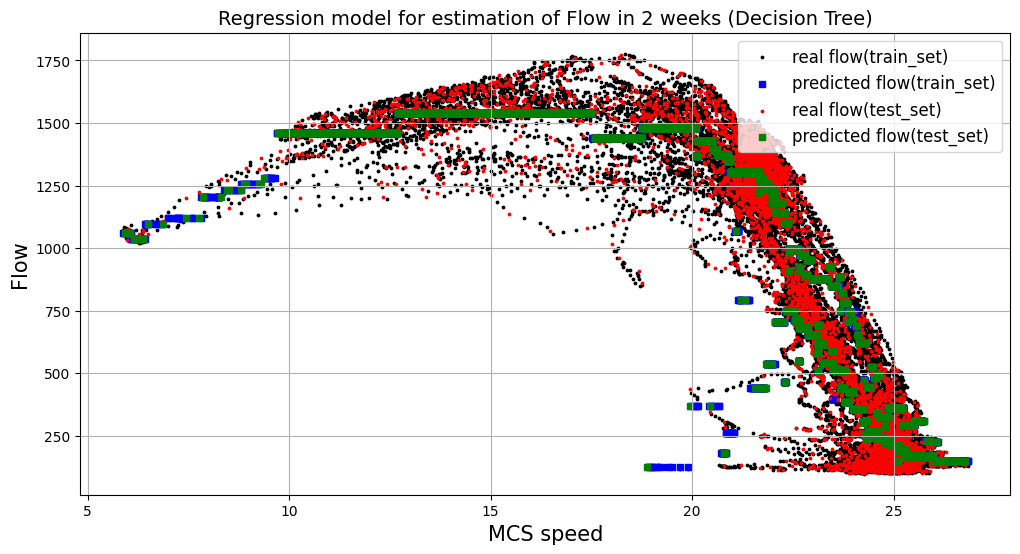

In [ ]:
# Plot real and predicted 'flow' vs 'mcs speed' 
plt.figure(figsize=(12, 6))
# plt.ylim(top = 2000)
plotResult(X_train[:, 0], Y_train, Y_predict_train, X_test[:, 0], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'MCS speed', 'Flow')


In [ ]:
# Use all data to predict the flow
# DTRegressor.fit(X_features, Y_label)
Y_predict = DTRegressor.predict(X_features)

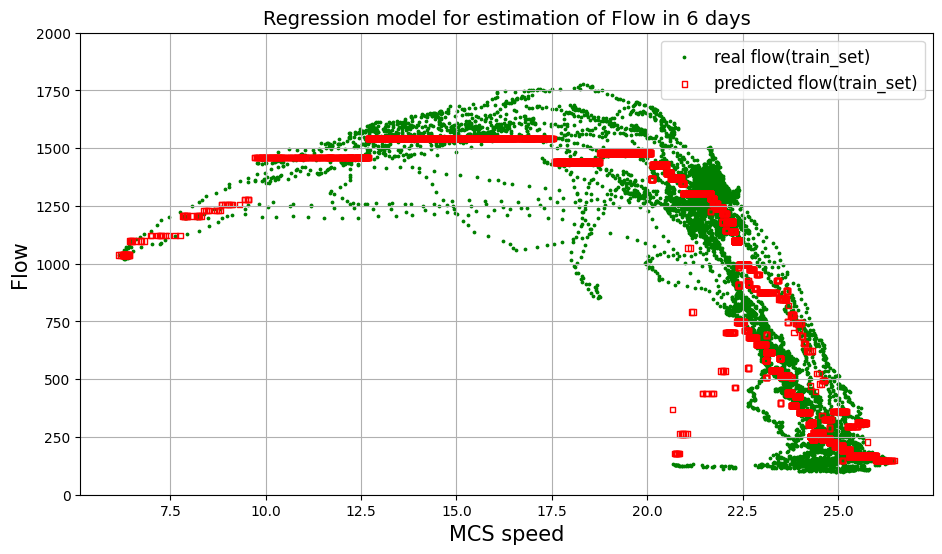

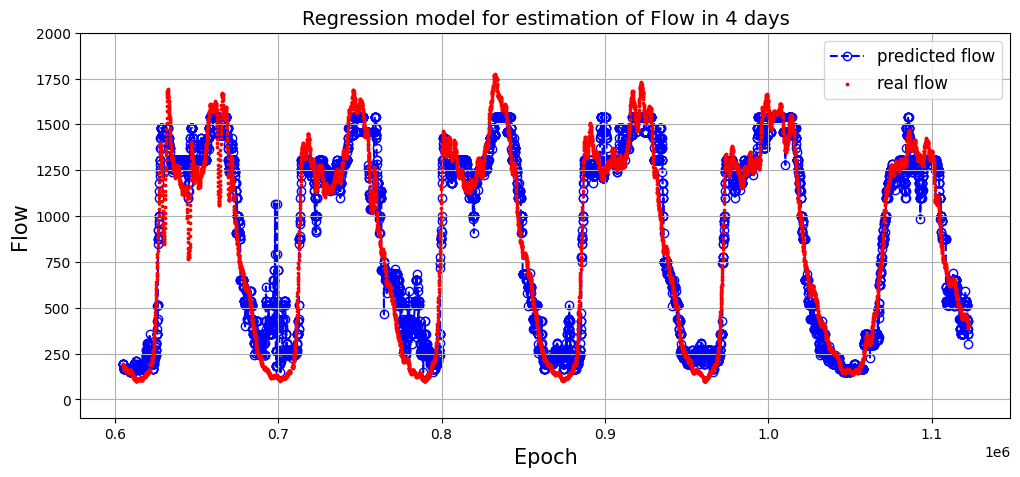

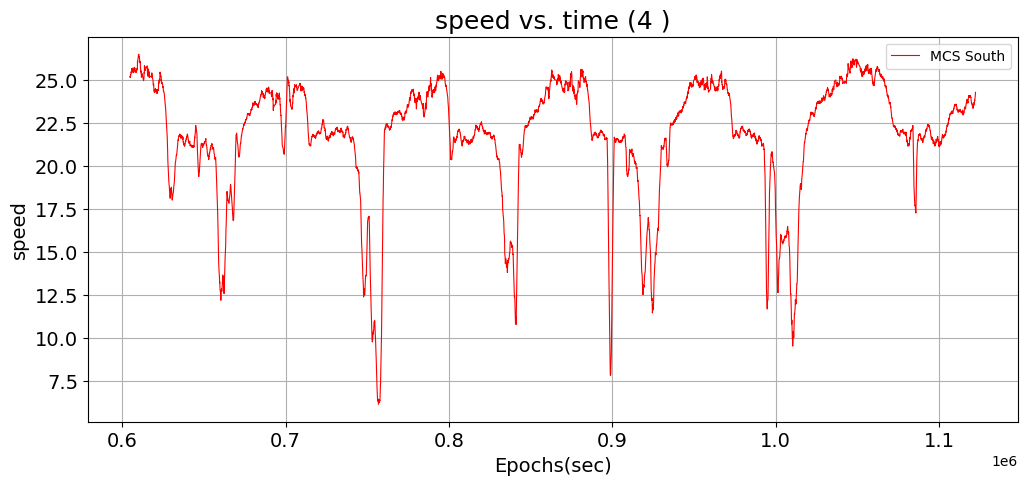

In [ ]:
STARTDATE = 8
ENDDATE = 14
DELTA_STEP = 0
# Plot real and predicted flow vs. X_features (speed_inrix)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
# plt.xlim(left = 5, right=30)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 0], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '6 days', 'MCS speed', 'Flow')

# plotResult(X_features_mcs_denormalized[:, 0], Y_label, Y_predict, 
#            None,  None, None, '3 weeks', 'MCS speed', 'Flow')


# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(12, 5))
plt.ylim(bottom = -100, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_label[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None, None, None, '4 days', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs speed 
plt.figure(figsize=(12, 5))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 'speed', 'MCS South')



In [ ]:
# test model on future datasets (22th to 27th):
combinedFuture = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 22): idx(combinedSouth_shifted, 27)]
X_future = combinedFuture[['speed', 'daytime']].values
Y_future = combinedFuture[['flow']].values
print(X_future.shape)
Y_future_predict = DTRegressor.predict(X_future)
print("Root Mean Square Error: ", mean_squared_error(Y_future, Y_future_predict, squared=False))
print("R2 Score: ", r2_score(Y_future, Y_future_predict))

(6637, 2)
Root Mean Square Error:  108.08946366599017
R2 Score:  0.955051776532326


## 4.2 Decision tree model: INRIX speed & Travel Time -> MCS flow



In [ ]:
# prepare the features [MCS speed] and label [flow]
# Notice: Y_flow was already defined in previous section 3.
# X_epoch was already defined
X_inrix_speed_travelTime_neighbor = combinedSouth_2w[['speed_inrix', 'travel_time_secs', 'speed_inrix_up','travel_time_secs_up', 'daytime']].values

X_features = X_inrix_speed_travelTime_neighbor
Y_label = Y_flow

print(X_features.shape)

# split the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)

(28387, 5)


In [ ]:
# temporarily tune the max_depth (hyperparameters) 
# Notice: should use cross-validation instead, here only for quick result
split = list(range(1, 15))
print(split)
result = quickSplitTuning(DecisionTreeRegressor, X_train, Y_train, X_test, Y_test, split)
print(result)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    split  Train_R2   Test_R2
0       1  0.701902  0.705129
1       2  0.799805  0.808741
2       3  0.837543  0.846314
3       4  0.853769  0.859664
4       5  0.863909  0.866551
5       6  0.870917  0.870369
6       7  0.876796  0.870943
7       8  0.882361  0.873256
8       9  0.889835  0.875646
9      10  0.898707  0.876966
10     11  0.906851  0.875613
11     12  0.916304  0.876165
12     13  0.925063  0.870331
13     14  0.934236  0.870422


In [ ]:
# Hyperparameter tuning: depth of tree
# by using training set
DTRegressor = DecisionTreeRegressor()
print(DTRegressor.get_params)

# param_grid = {'max_depth': [int(x) for x in np.arange(10, 16, step=1)], 
#               'min_samples_leaf': [int(x) for x in np.arange(10,100 ,step = 10)]     
#               }

param_grid = {'max_depth': [11], 
              'min_samples_leaf': [int(x) for x in np.arange(8, 25, step=1)]}

              
grid_search = GridSearchCV(DTRegressor, param_grid, cv=7, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, Y_train)

grid_search.best_params_

<bound method BaseEstimator.get_params of DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')>


{'max_depth': 11, 'min_samples_leaf': 14}

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
  print(mean_score, params)

0.871635390414788 {'max_depth': 11, 'min_samples_leaf': 8}
0.8723038843317602 {'max_depth': 11, 'min_samples_leaf': 9}
0.8724359908347462 {'max_depth': 11, 'min_samples_leaf': 10}
0.8727127581145488 {'max_depth': 11, 'min_samples_leaf': 11}
0.8727738562701225 {'max_depth': 11, 'min_samples_leaf': 12}
0.8725535533258072 {'max_depth': 11, 'min_samples_leaf': 13}
0.8730459143664449 {'max_depth': 11, 'min_samples_leaf': 14}
0.8722260989802094 {'max_depth': 11, 'min_samples_leaf': 15}
0.8726463048489167 {'max_depth': 11, 'min_samples_leaf': 16}
0.8726926112916616 {'max_depth': 11, 'min_samples_leaf': 17}
0.8720884750660639 {'max_depth': 11, 'min_samples_leaf': 18}
0.871981229538763 {'max_depth': 11, 'min_samples_leaf': 19}
0.8717634722979296 {'max_depth': 11, 'min_samples_leaf': 20}
0.8715676319671425 {'max_depth': 11, 'min_samples_leaf': 21}
0.8716702592714969 {'max_depth': 11, 'min_samples_leaf': 22}
0.8715548153104862 {'max_depth': 11, 'min_samples_leaf': 23}
0.8716288127089865 {'max_dep

In [ ]:
# train the model with train dataset and check the accuracy
DT_MAXDEPTH = 11
DT_MSL = 15
DTRegressor = DecisionTreeRegressor(max_depth = DT_MAXDEPTH, min_samples_leaf= DT_MSL, random_state=0)
DTRegressor.fit(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = DTRegressor.predict(X_train)
scores = cross_val_score(DTRegressor, X_train, Y_train, scoring='r2', cv=10)
display_scores(scores)
print()
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for training set: ", DTRegressor.score(X_train, Y_train))

# Evaluate Performance of testing set
Y_predict_test = DTRegressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score for testing set: ", r2_score(Y_test, Y_predict_test))


Scores: [0.89005736 0.87028411 0.86724261 0.86589322 0.87436119 0.86760835
 0.87234916 0.87019911 0.87073571 0.87463625]
Mean: 0.8723367053314697
Standard deviation: 0.006515976286566271

Root Mean Square Error:  165.38051722464164
R2 Score for training set:  0.8947687500223386
Root Mean Square Error:  178.23201748517516
R2 Score for testing set:  0.8800944765233711


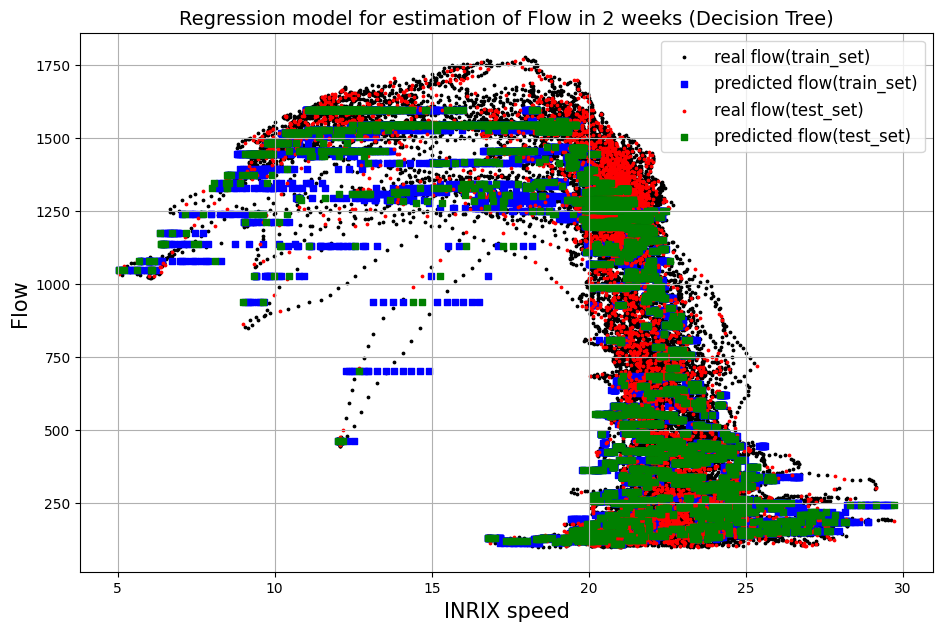

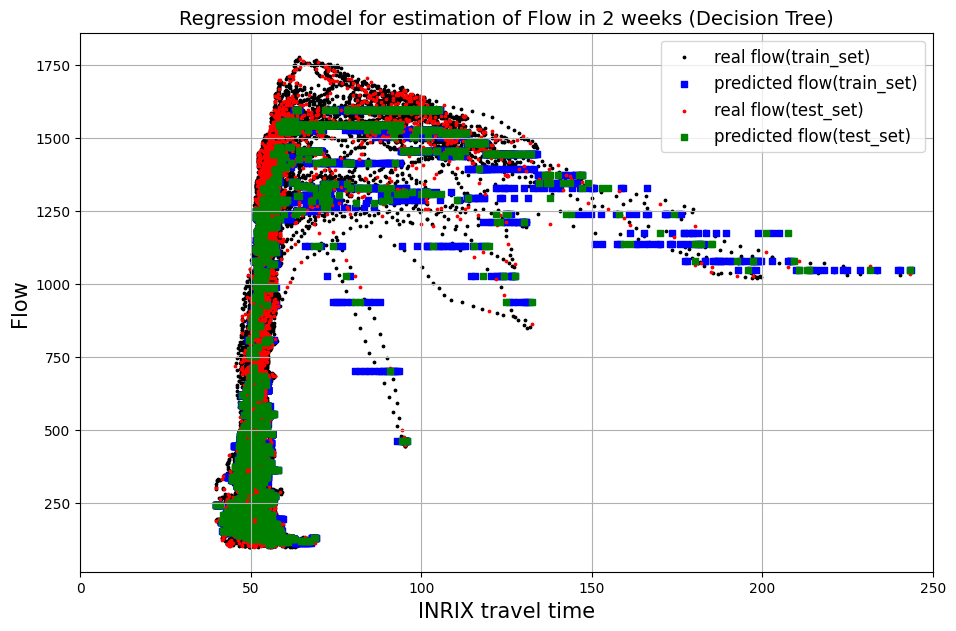

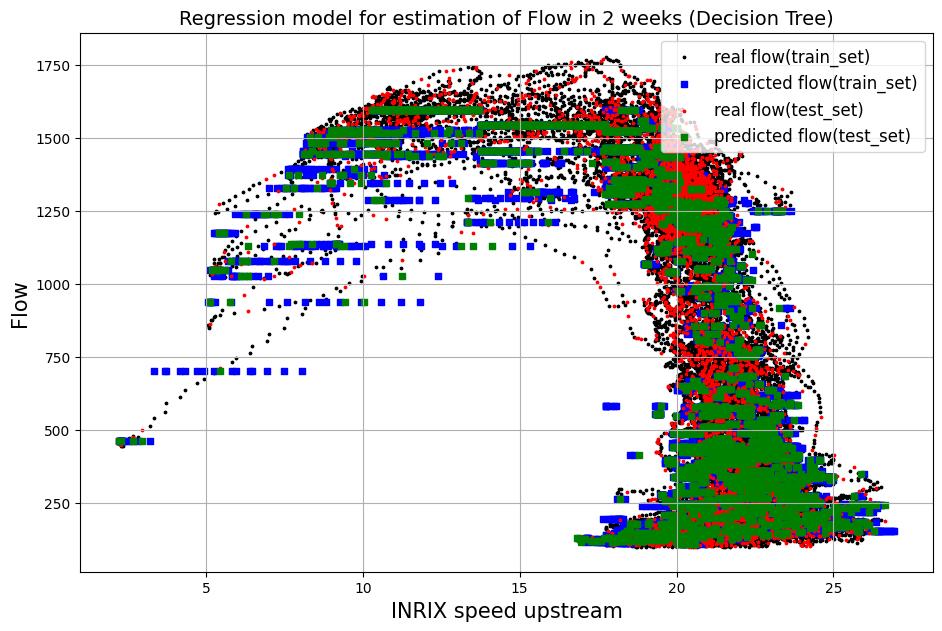

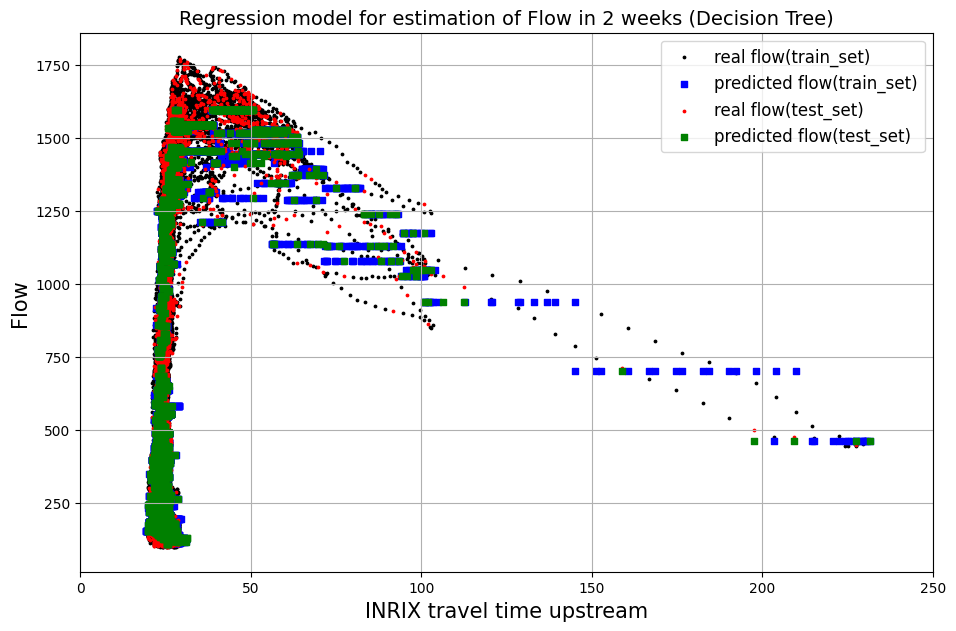

In [ ]:
# Plot real and predicted 'flow' vs 'speed current' 
plt.figure(figsize=(11, 7))
# plt.ylim(top = 2000)
plotResult(X_train[:, 0], Y_train, Y_predict_train, X_test[:, 0], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX speed', 'Flow')

# Plot real and predicted 'flow' vs 'speed current' 
plt.figure(figsize=(11, 7))
plt.xlim(right = 250)
plotResult(X_train[:, 1], Y_train, Y_predict_train, X_test[:, 1], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX travel time', 'Flow')

# Plot real and predicted 'flow' vs 'speed upstream' 
plt.figure(figsize=(11, 7))
# plt.ylim(top = 2000)
plotResult(X_train[:, 2], Y_train, Y_predict_train, X_test[:, 2], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX speed upstream', 'Flow')

# Plot real and predicted 'flow' vs 'speed upstream' 
plt.figure(figsize=(11, 7))
plt.xlim(right = 250)
plotResult(X_train[:, 3], Y_train, Y_predict_train, X_test[:, 3], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX travel time upstream', 'Flow')

In [ ]:
# Use all data to predict the flow
DTRegressor.fit(X_features, Y_label)
Y_predict = DTRegressor.predict(X_features)

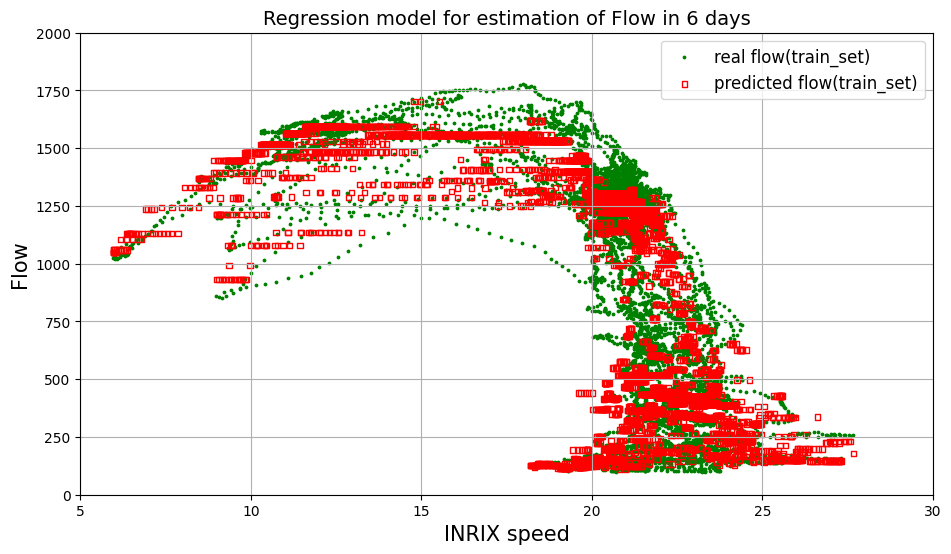

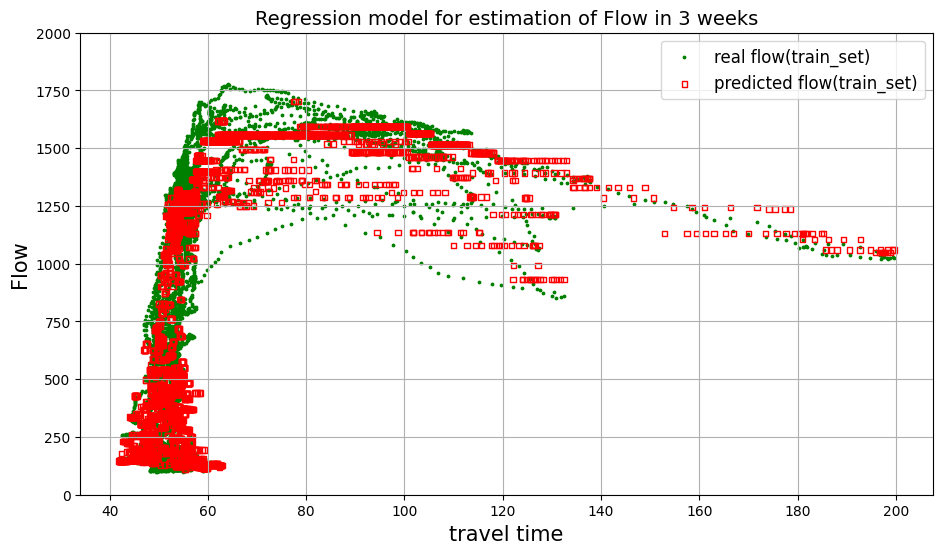

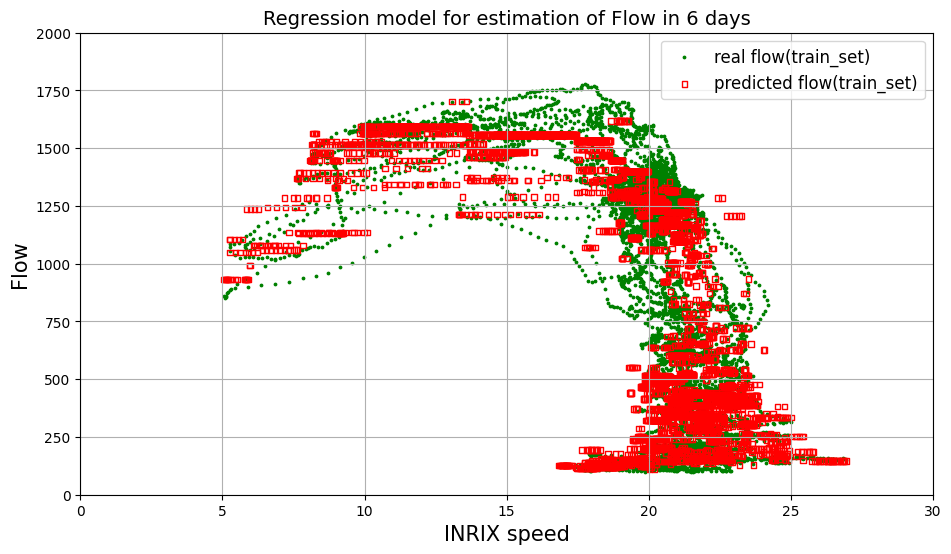

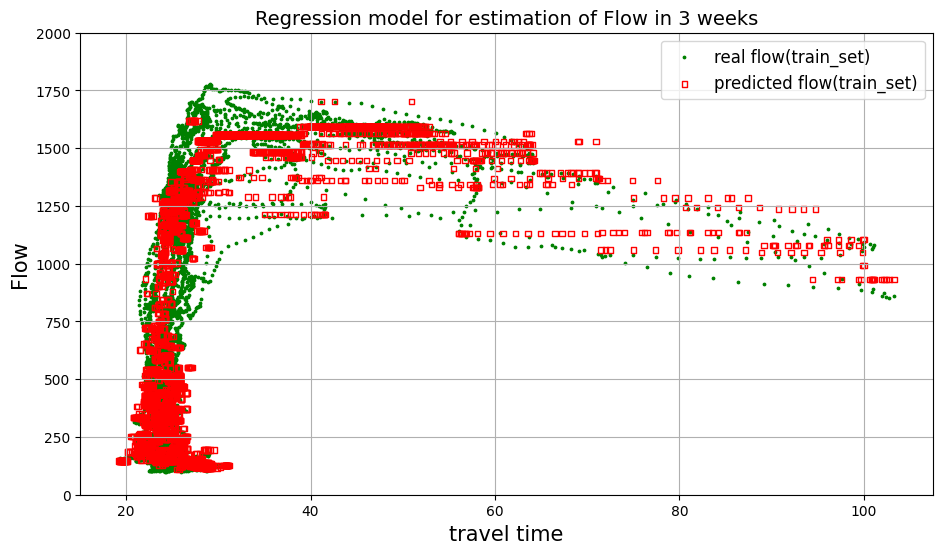

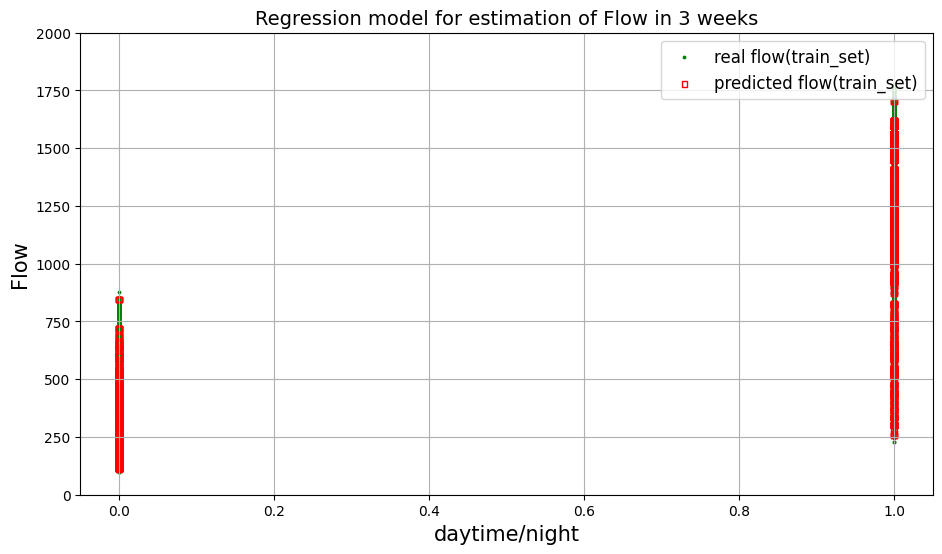

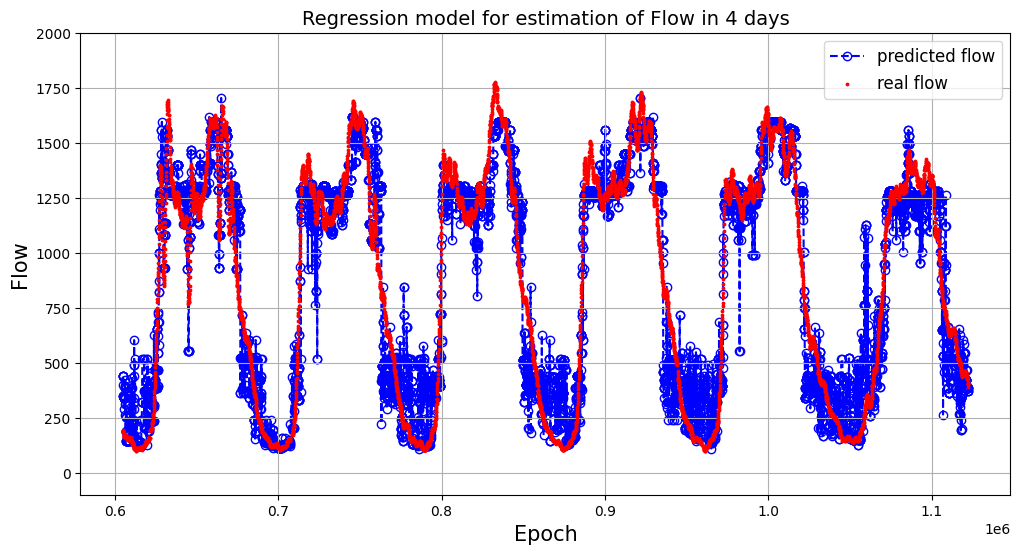

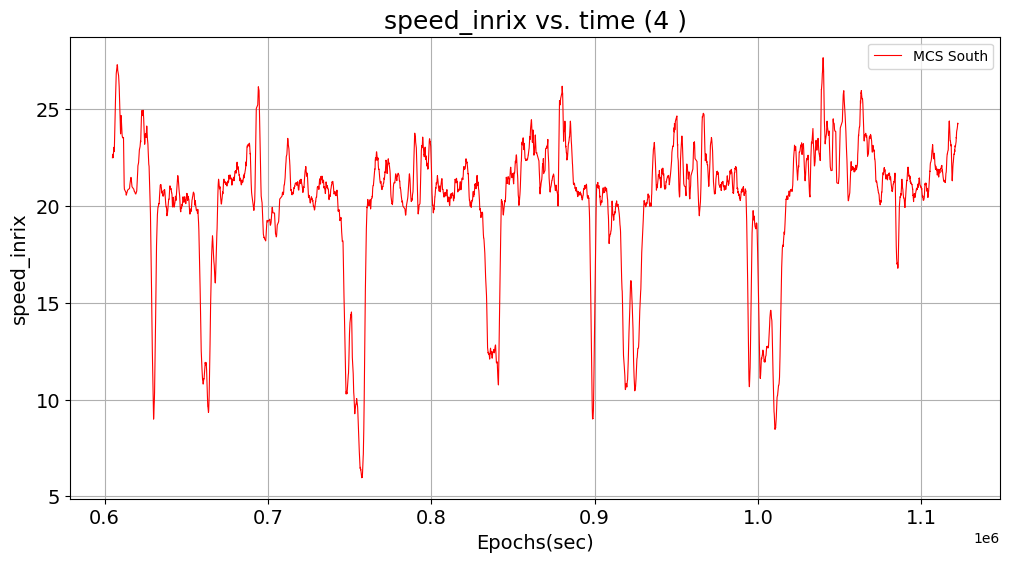

In [ ]:
STARTDATE = 8
ENDDATE = 14
DELTA_STEP = 0

# Plot real and predicted flow vs. X_features (speed_inrix current)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
plt.xlim(left = 5, right=30)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 0], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '6 days', 'INRIX speed', 'Flow')



# Plot real and predicted flow vs. X_features (travel_inrix upstream)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
# plt.xlim(left = 5, right=30)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 1], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '3 weeks', 'travel time', 'Flow')

# Plot real and predicted flow vs. X_features (speed_inrix upstream)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
plt.xlim(left = 0, right=30)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 2], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '6 days', 'INRIX speed', 'Flow')



# Plot real and predicted flow vs. X_features (travel_inrix)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
# plt.xlim(left = 5, right=30)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 3], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '3 weeks', 'travel time', 'Flow')

# Plot real and predicted flow vs. X_features (temporal factor)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 4], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '3 weeks', 'daytime/night', 'Flow')


# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(12, 6))
plt.ylim(bottom = -100, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_label[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None, None, None, '4 days', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs speed 
plt.figure(figsize=(12, 6))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 'speed_inrix', 'MCS South')



In [ ]:
# test model on future datasets (22th to 27th):
combinedFuture = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 22): idx(combinedSouth_shifted, 27)]
X_future = combinedFuture[['speed_inrix', 'travel_time_secs', 'speed_inrix_up', 'travel_time_secs_up', 'daytime']].values
Y_future = combinedFuture[['flow']].values
print(X_future.shape)
Y_future_predict = DTRegressor.predict(X_future)
print("Root Mean Square Error: ", mean_squared_error(Y_future, Y_future_predict, squared=False))
print("R2 Score: ", r2_score(Y_future, Y_future_predict))

(6637, 5)
Root Mean Square Error:  177.0596641956307
R2 Score:  0.8793895105166243


# 5. Random Forest


*   Random Forest for mapping MCS speed -> MCS flow
*   Random Forest for mapping INRIX speed -> MCS flow
*   Cross Validation for tunig hyperparameters( depth & tree number) in random forest tree




## 5.1 Random Forest tree for mapping MCS speed to MCS flow

In [ ]:
# prepare the features [MCS speed] and label [flow]
# Notice: Y_flow was already defined in previous section 3.
# X_epoch was already defined
# X_mcs_speed was already assigned at 4.1 
X_features = X_mcs_speed_temp
Y_label = Y_flow

print(X_features.shape)

# split the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)


(28387, 2)


In [ ]:
## Hyperparameter tuning: random search
RFRegressor = RandomForestRegressor()
print(RFRegressor.get_params)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)


# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = RFRegressor, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='r2')
# rf_random.fit(X_train, Y_train)

# rf_random.best_params_

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>


NameError: ignored

In [ ]:
## Hyperparameter tuning: random search
RFRegressor = RandomForestRegressor()
print(RFRegressor.get_params)

# Hyperparameter tuning: grid search
param_grid = {'n_estimators': [int(x) for x in np.arange(50, 250, 20)],
              'max_depth': [7],
              'min_samples_leaf': [23]} 
              
grid_search = GridSearchCV(estimator = RFRegressor, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1, scoring='r2')
grid_search.fit(X_train, Y_train)

grid_search.best_params_

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   34.9s finished


{'max_depth': 7, 'min_samples_leaf': 23, 'n_estimators': 210}

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
  print(mean_score, params)

AttributeError: ignored

In [ ]:
# fit the random forest model with tuned hyperparameters
RF_MAXDEPTH = 7
RF_NTREE = 210
RF_MSL = 11

RFRegressor = RandomForestRegressor(n_estimators= RF_NTREE, max_depth= RF_MAXDEPTH, min_samples_leaf=RF_MSL, n_jobs=-1)

# Use 10 folds cross-validation to fit and validate the model by training set
scores = cross_val_score(RFRegressor, X_train, Y_train, scoring='neg_root_mean_squared_error', cv=10)
display_scores(scores)

# fit the model on whole training set
# evaluate Performance of model (fitting result) on training set
RFRegressor.fit(X_train, Y_train)
Y_predict_train = RFRegressor.predict(X_train)
print('\nfitting result on whole training set:')
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for fitting result on training set: ", RFRegressor.score(X_train, Y_train))

# Evaluate Performance of the fitted model on testing set
Y_predict_test = RFRegressor.predict(X_test)
print('\nprediction result on testing set:')
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score on testing set: ", r2_score(Y_test, Y_predict_test))

Scores: [-124.77989091 -119.86532292 -126.94524868 -126.35173985 -130.02394698
 -127.47199375 -125.50758695 -126.61136834 -121.26094814 -125.23143639]
Mean: -125.40494829097949
Standard deviation: 2.8039924923023576

fitting result on whole training set:
Root Mean Square Error:  122.44731470310455
R2 Score for fitting result on training set:  0.9423134497466163

prediction result on testing set:
Root Mean Square Error:  126.3670191441201
R2 Score on testing set:  0.939725276688749


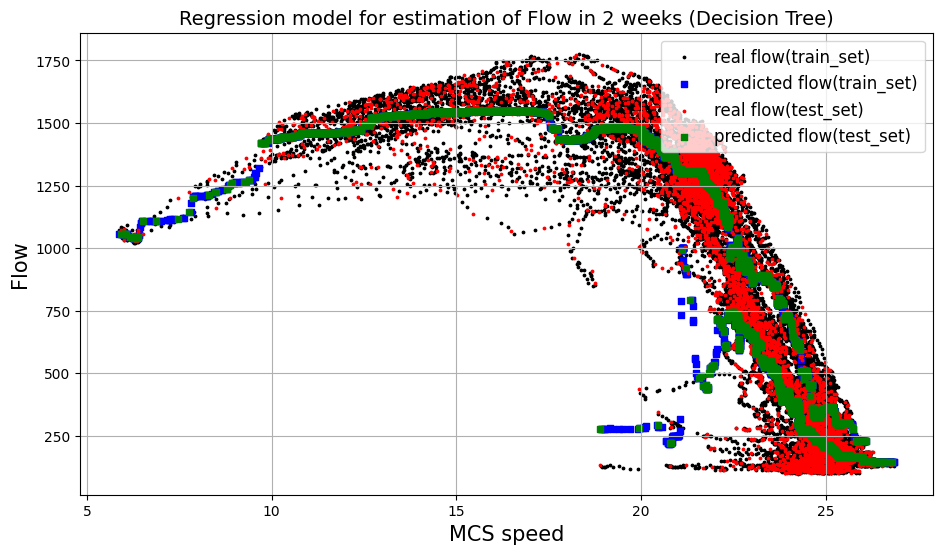

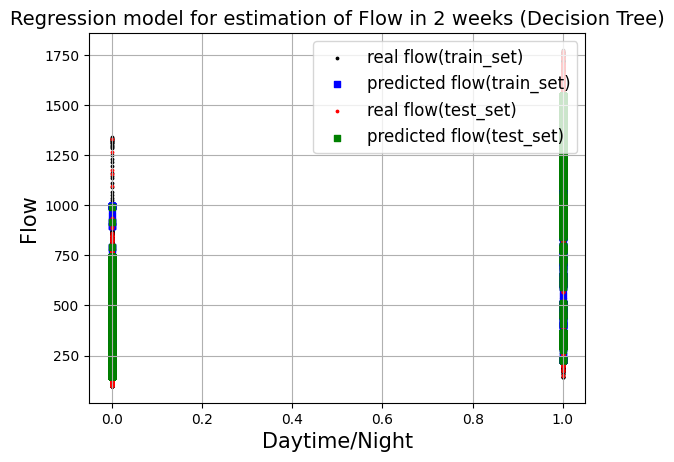

In [ ]:
# Plot real and predicted 'flow' vs 'mcs speed' 
plt.figure(figsize=(11, 6))
# plt.ylim(top = 2000)
plotResult(X_train[:, 0], Y_train, Y_predict_train, X_test[:, 0], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'MCS speed', 'Flow')
# plt.ylim(top = 2000)
plotResult(X_train[:, 1], Y_train, Y_predict_train, X_test[:, 1], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'Daytime/Night', 'Flow')

In [ ]:
# Use all data and the fitted model to predict the flow (used for drawing the plot)
Y_predict = RFRegressor.predict(X_features)

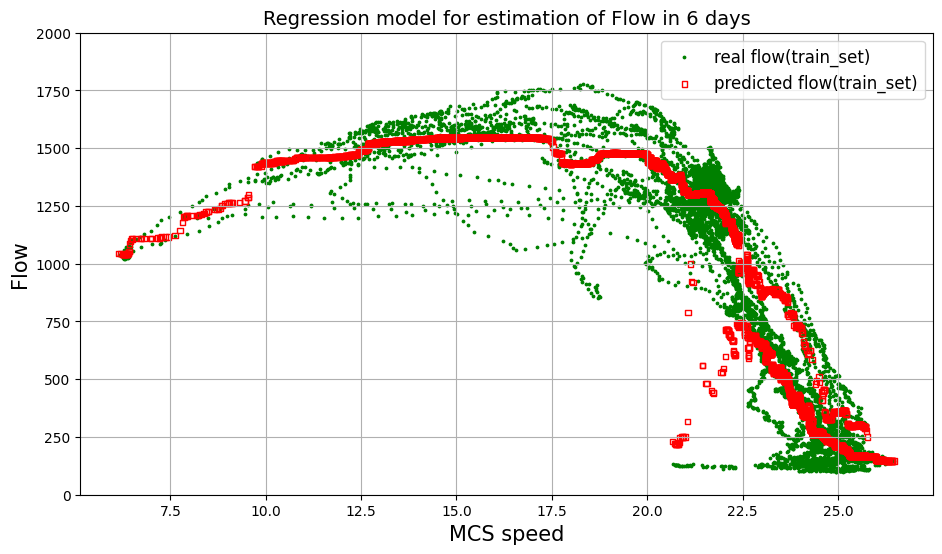

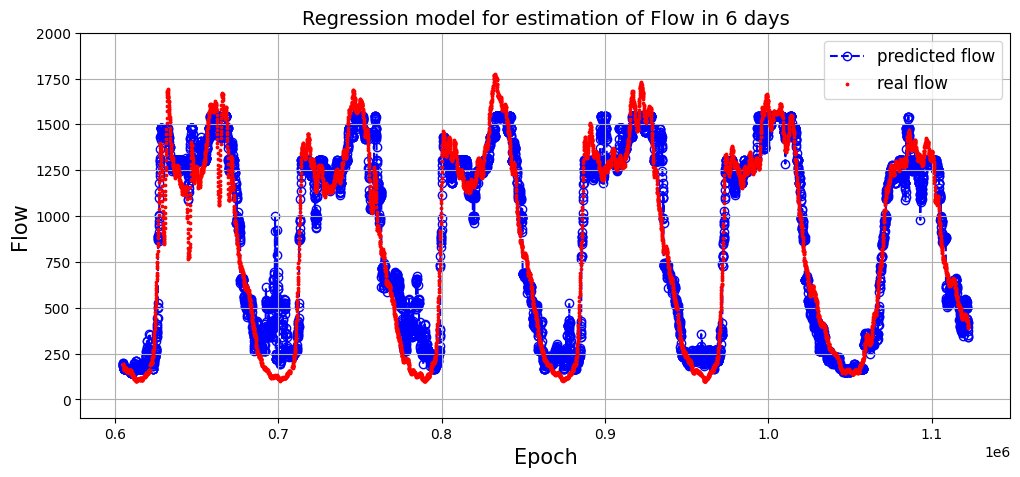

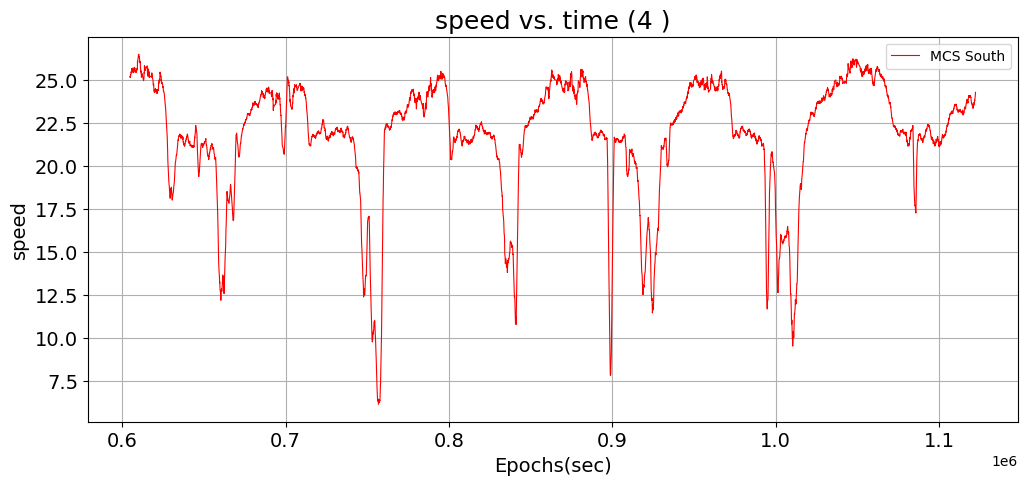

In [ ]:
STARTDATE = 8
ENDDATE = 14
DELTA_STEP = 0
# Plot real and predicted flow vs. X_features (speed_inrix)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
# plt.xlim(left = 5, right=30)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 0], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '6 days', 'MCS speed', 'Flow')

# plotResult(X_features_mcs_denormalized[:, 0], Y_label, Y_predict, 
#            None,  None, None, '3 weeks', 'MCS speed', 'Flow')


# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(12, 5))
plt.ylim(bottom = -100, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_label[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None, None, None, '6 days', 'Epoch', 'Flow', 'p')

# Plot corresponding mcs speed 
plt.figure(figsize=(12, 5))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 'speed', 'MCS South')



In [ ]:
# test model on future datasets (22th to 27th):
combinedFuture = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 22): idx(combinedSouth_shifted, 27)]
X_future = combinedFuture[['speed', 'daytime']].values
Y_future = combinedFuture[['flow']].values
print(X_future.shape)
Y_future_predict = RFRegressor.predict(X_future)
print("Root Mean Square Error: ", mean_squared_error(Y_future, Y_future_predict, squared=False))
print("R2 Score: ", r2_score(Y_future, Y_future_predict))

(6637, 2)
Root Mean Square Error:  107.04747958800446
R2 Score:  0.9559142026179624


## 5.2 Random Forest tree for mapping INRIX speed to MCS flow

In [ ]:
# prepare the features [INRIX speed] and label [flow]
# Notice: Y_flow was already defined in previous section 3.
# X_epoch was already defined
# X_inrix_speed was already assigned at section 4
X_features = X_inrix_speed_travelTime_neighbor
Y_label = Y_flow

print(X_features.shape)

# split the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=1)


(28387, 5)


In [ ]:
# Hyperparameter tuning: # and depth of tree, minimum # of samples in a leaf
# by using training set
RFRegressor = RandomForestRegressor()
print(RFRegressor.get_params)
param_grid = {'n_estimators': [int(x) for x in np.arange(400, 600, step=20)],
              'max_depth': [11],
              'min_samples_leaf': [15]
              }
grid_search = GridSearchCV(estimator = RFRegressor, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1, scoring='r2')
grid_search.fit(X_train, Y_train)

grid_search.best_params_

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.1min finished


{'max_depth': 11, 'min_samples_leaf': 15, 'n_estimators': 500}

{'max_depth': 18, 'min_samples_leaf': 1, 'n_estimators': 350}<br>
param_grid = {'n_estimators': [int(x) for x in np.arange(250, 351, 50)],
              'max_depth': [int(x) for x in np.arange(14, 19, step=2)],
              'min_samples_leaf': [int(x) for x in np.arange(1, 5, step=2)]
              }


In [ ]:
# print the results of cross-validation for hyper-parameters
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
  print(mean_score, params)

0.8892995523994472 {'max_depth': 18, 'min_samples_leaf': 1, 'n_estimators': 350}
0.8890342187666421 {'max_depth': 18, 'min_samples_leaf': 1, 'n_estimators': 400}
0.8879663456288239 {'max_depth': 18, 'min_samples_leaf': 3, 'n_estimators': 350}
0.8879236198790847 {'max_depth': 18, 'min_samples_leaf': 3, 'n_estimators': 400}
0.8864019924329941 {'max_depth': 18, 'min_samples_leaf': 5, 'n_estimators': 350}
0.8863948490274641 {'max_depth': 18, 'min_samples_leaf': 5, 'n_estimators': 400}
0.8890374657363699 {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 350}
0.8891123741046538 {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 400}
0.8879802801968695 {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 350}
0.8881114649691445 {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 400}
0.886549261942125 {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 350}
0.8866524030729215 {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 400}
0.8891424433352016 {'max_dept

Hyperparameter-tuning: <br>
RF_NTREE = 350
RF_MAXDEPTH = 18
RF_MSL = 1

In [ ]:
# fit the random forest model on whole training set with the tuned hyperparameters
RF_NTREE = 500
RF_MAXDEPTH = 11
RF_MSL = 15

RFRegressor = RandomForestRegressor(n_estimators= RF_NTREE, max_depth=RF_MAXDEPTH, min_samples_leaf=RF_MSL, n_jobs=-1)

# Use 10 folds cross-validation to fit and validate the model by training set
scores = cross_val_score(RFRegressor, X_train, Y_train, scoring='r2', cv=10)
display_scores(scores)

# fit the model on whole training set
# evaluate Performance of model (fitting result) on training set
RFRegressor.fit(X_train, Y_train)
Y_predict_train = RFRegressor.predict(X_train)
print('\nfitting result on whole training set:')
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score for fitting result on training set: ", RFRegressor.score(X_train, Y_train))

# Evaluate Performance of the fitted model on testing set
Y_predict_test = RFRegressor.predict(X_test)
print('\nprediction result on testing set:')
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score on testing set: ", r2_score(Y_test, Y_predict_test))

Scores: [0.9009346  0.88002021 0.8817155  0.87880768 0.88222407 0.8795595
 0.88378763 0.88112823 0.87878814 0.88422792]
Mean: 0.8831193471532618
Standard deviation: 0.0062082401478654875

fitting result on whole training set:
Root Mean Square Error:  162.09179132618118
R2 Score for fitting result on training set:  0.8989123545337676

prediction result on testing set:
Root Mean Square Error:  171.94224516352133
R2 Score on testing set:  0.8884080337604502


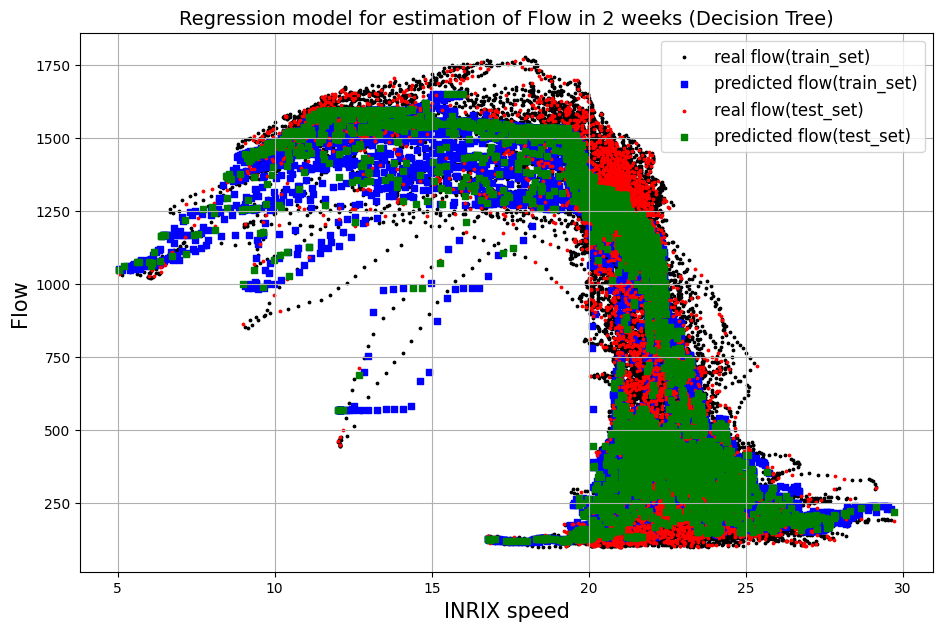

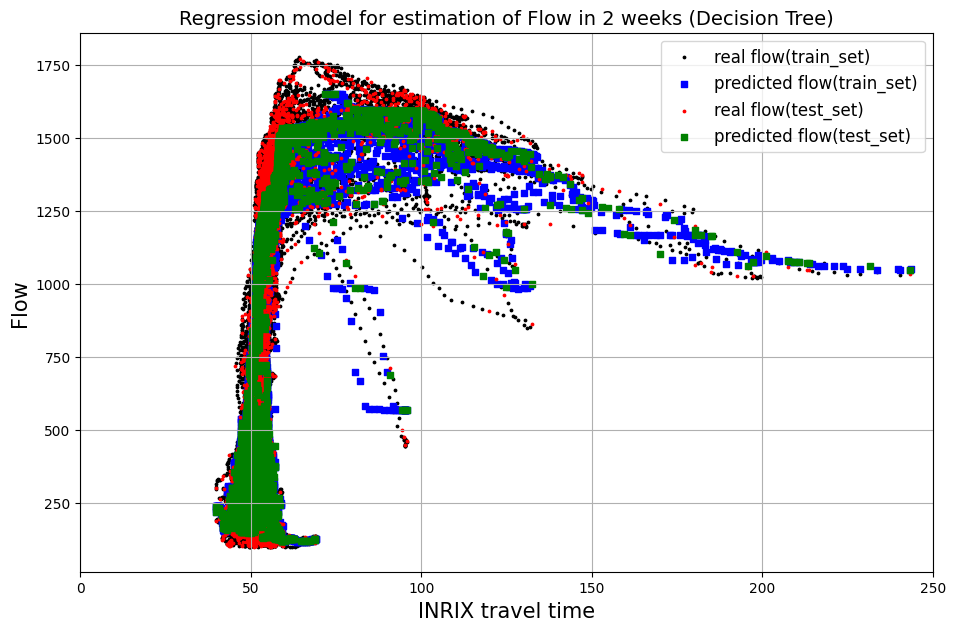

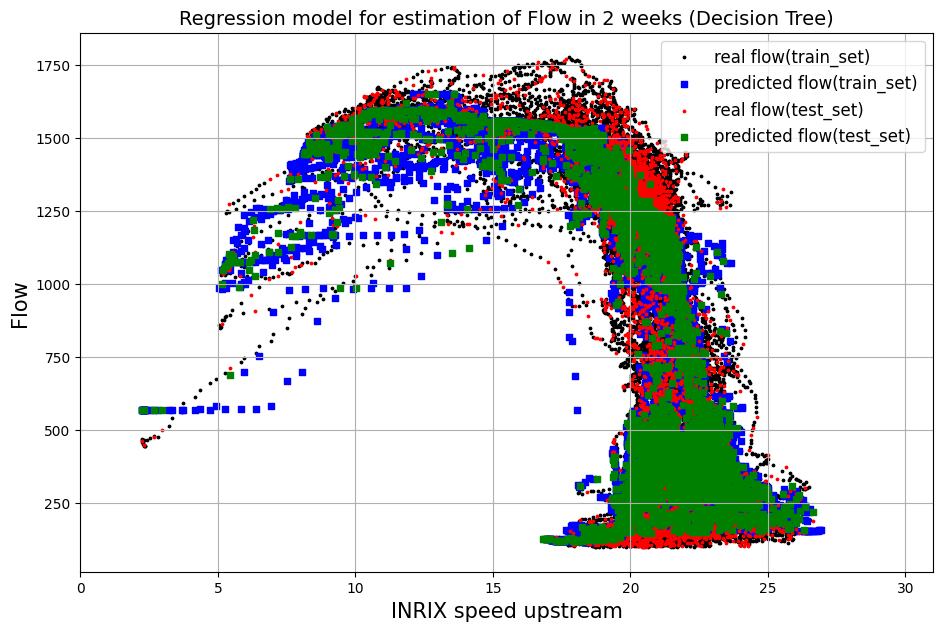

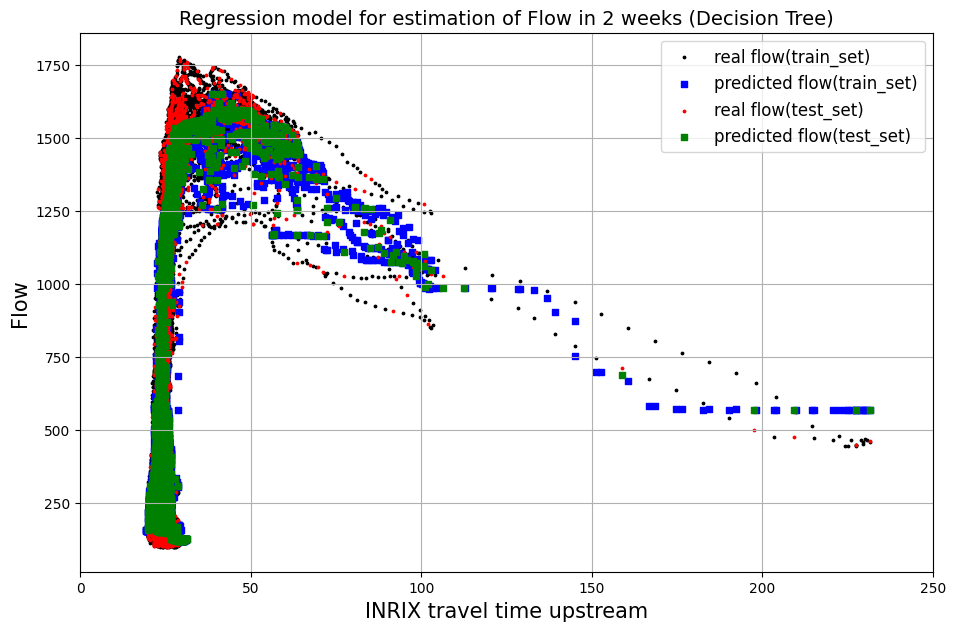

In [ ]:
# Plot real and predicted 'flow' vs 'speed current' 
plt.figure(figsize=(11, 7))
# plt.ylim(top = 2000)
plotResult(X_train[:, 0], Y_train, Y_predict_train, X_test[:, 0], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX speed', 'Flow')

# Plot real and predicted 'flow' vs 'speed current' 
plt.figure(figsize=(11, 7))
plt.xlim(right = 250)
plotResult(X_train[:, 1], Y_train, Y_predict_train, X_test[:, 1], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX travel time', 'Flow')

# Plot real and predicted 'flow' vs 'speed upstream' 
plt.figure(figsize=(11, 7))
# plt.ylim(top = 2000)
plt.xlim(right = 31)
plotResult(X_train[:, 2], Y_train, Y_predict_train, X_test[:, 2], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX speed upstream', 'Flow')

# Plot real and predicted 'flow' vs 'speed upstream' 
plt.figure(figsize=(11, 7))
plt.xlim(right = 250)
plotResult(X_train[:, 3], Y_train, Y_predict_train, X_test[:, 3], Y_test, Y_predict_test, '2 weeks (Decision Tree)', 'INRIX travel time upstream', 'Flow')

In [ ]:
# Use all data and the fitted model to predict the flow (used for drawing the plot)
Y_predict = RFRegressor.predict(X_features)

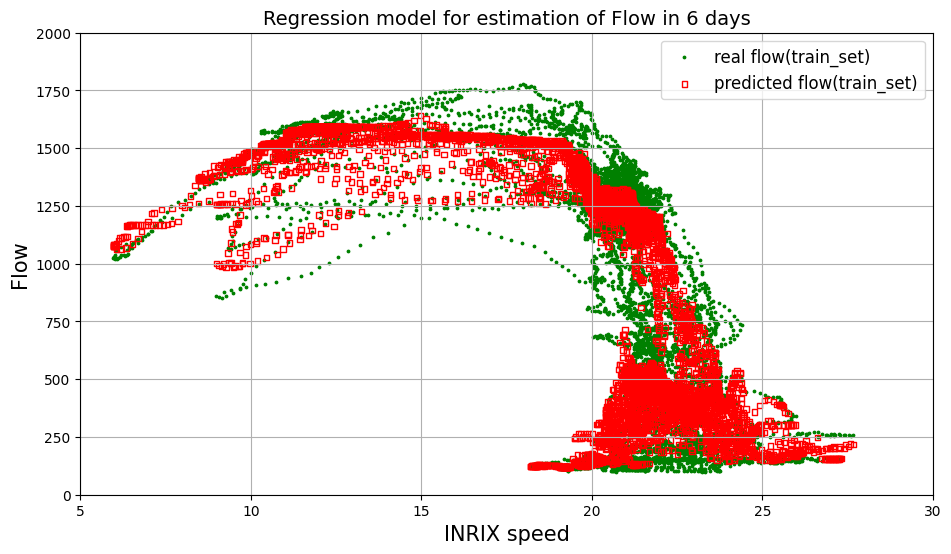

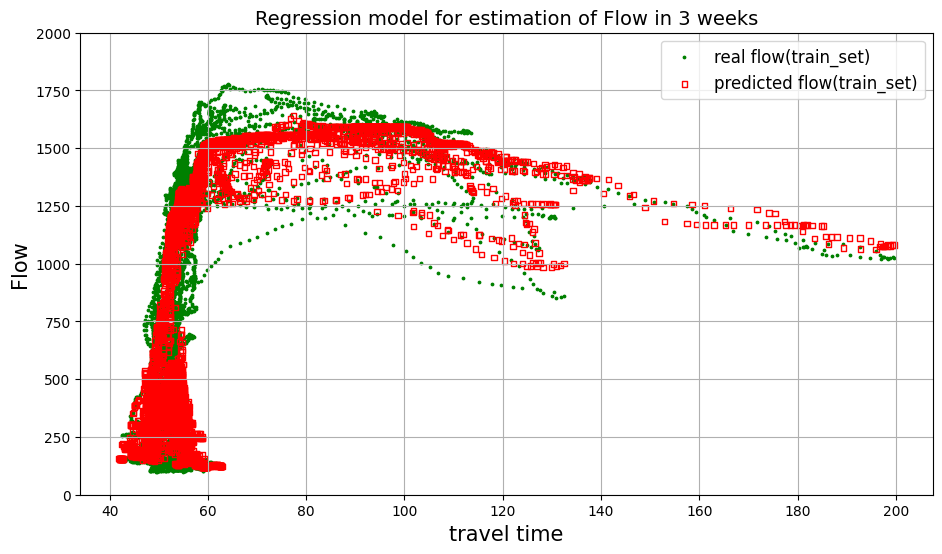

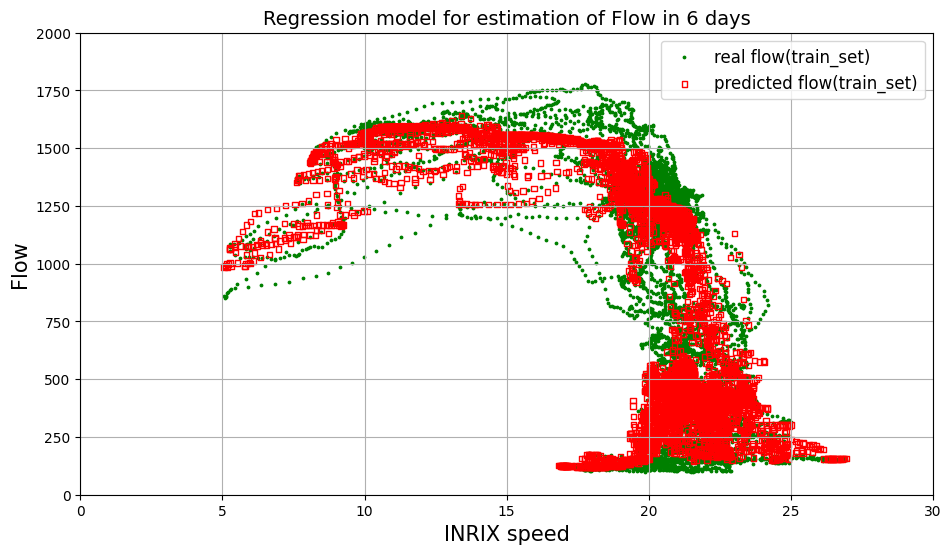

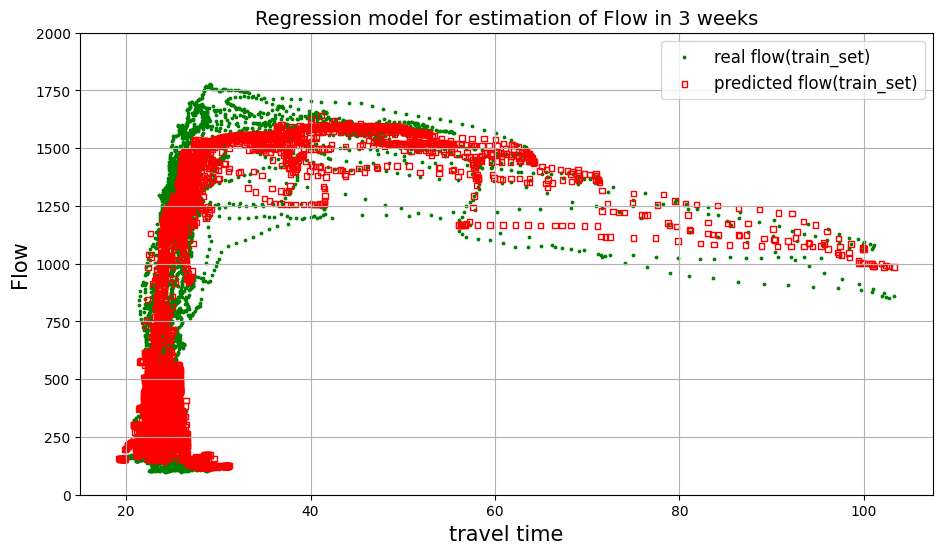

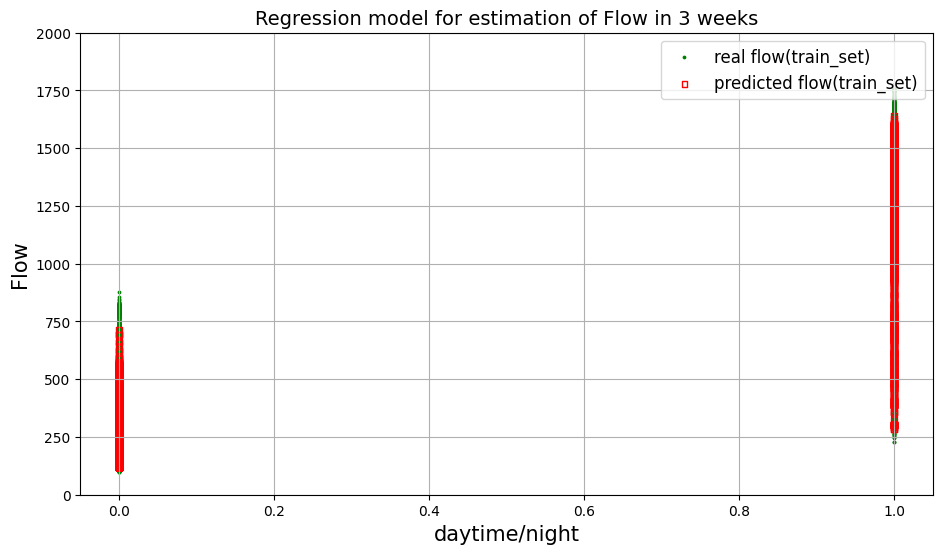

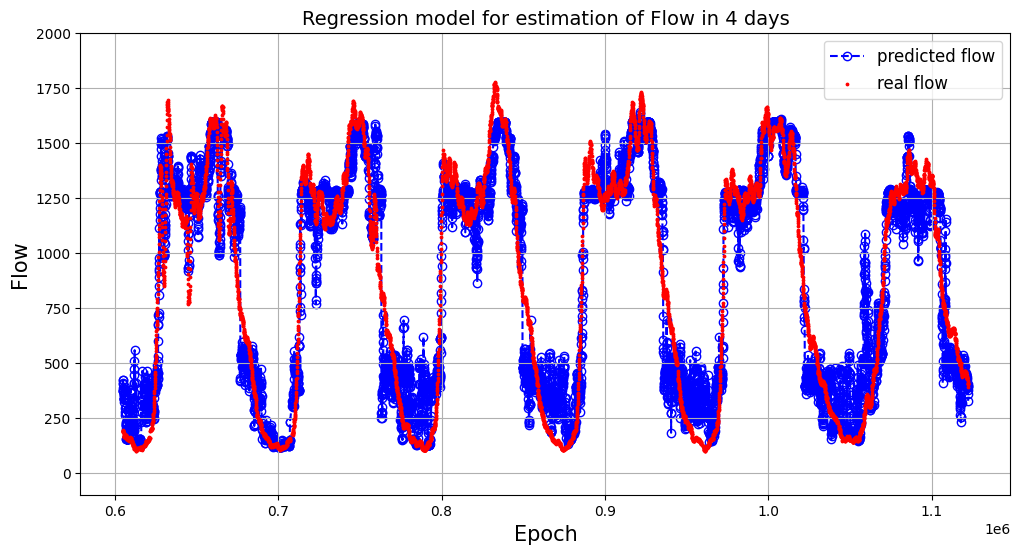

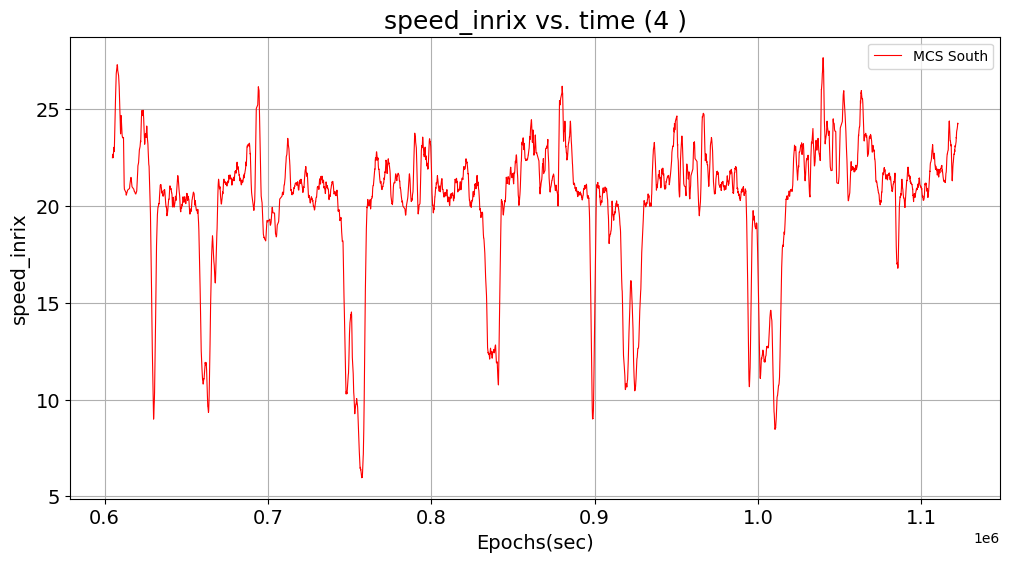

In [ ]:
STARTDATE = 8
ENDDATE = 14
DELTA_STEP = 0

# Plot real and predicted flow vs. X_features (speed_inrix current)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
plt.xlim(left = 5, right=30)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 0], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '6 days', 'INRIX speed', 'Flow')



# Plot real and predicted flow vs. X_features (travel_inrix upstream)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
# plt.xlim(left = 5, right=30)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 1], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '3 weeks', 'travel time', 'Flow')

# Plot real and predicted flow vs. X_features (speed_inrix upstream)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
plt.xlim(left = 0, right=30)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 2], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '6 days', 'INRIX speed', 'Flow')



# Plot real and predicted flow vs. X_features (travel_inrix)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
# plt.xlim(left = 5, right=30)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 3], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '3 weeks', 'travel time', 'Flow')

# Plot real and predicted flow vs. X_features (temporal factor)
plt.figure(figsize=(11, 6))
plt.ylim(bottom = 0, top=2000)
plotResult(X_features[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP, 4], 
           Y_label[idx(combinedSouth_2w, STARTDATE): idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE) : idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None,  None, None, '3 weeks', 'daytime/night', 'Flow')


# Plot real and predicted flow vs. Epoch 
plt.figure(figsize=(12, 6))
plt.ylim(bottom = -100, top = 2000)
plotResult(X_epoch[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_label[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           Y_predict[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 
           None, None, None, '4 days', 'Epoch', 'Flow', 'p')

# Plot corresponding inrix speed 
plt.figure(figsize=(12, 6))
plotAttr(4, combinedSouth_2w.iloc[idx(combinedSouth_2w, STARTDATE):idx(combinedSouth_2w, ENDDATE) + DELTA_STEP], 'speed_inrix', 'MCS South')



In [ ]:
# test model on future datasets (22th to 27th):
combinedFuture = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 22): idx(combinedSouth_shifted, 27)]
X_future = combinedFuture[['speed_inrix', 'travel_time_secs','speed_inrix_up', 'travel_time_secs_up', 'daytime']].values
Y_future = combinedFuture[['flow']].values
print(X_future.shape)
Y_future_predict = RFRegressor.predict(X_future)
print("Root Mean Square Error: ", mean_squared_error(Y_future, Y_future_predict, squared=False))
print("R2 Score: ", r2_score(Y_future, Y_future_predict))

(6637, 5)
Root Mean Square Error:  162.39742561667407
R2 Score:  0.8985378435895001


# Part II. Deep Learning for Traffic Flow Estimation

## Deep Learning Models
Part II of this notebook aims to implement deep learning models (neural networks) to estimate the traffic flow based on Mcs data and INRIX data: 
* Backpropagation neural network
* Recurrent neural network

# 1. Backpropagation neural network